CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [6]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import time


# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [3]:
X_train = np.load(DATA_PATH + 'X_train_aug_flip_scale.npy')
y_train = np.load(DATA_PATH + 'y_train_aug_flip_scale.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((300, 512, 512, 1), (300, 512, 512, 1), (30, 512, 512, 1))

In [4]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((270, 512, 512, 1), (30, 512, 512, 1), (270, 512, 512, 1), (30, 512, 512, 1))

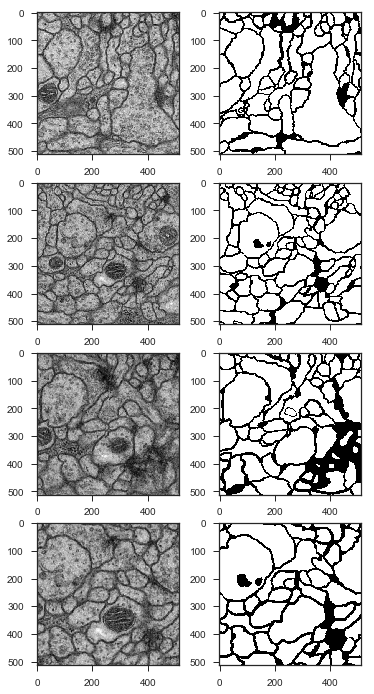

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(6, 12))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [10]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from U_Net import u_net_fuse_v7, u_net_fuse_v6, u_net_fuse_v7_2
from Loss_Functions import dice_coef, dice_coef_loss, jaccard_coef, pixel_error, pixel_error_2

Unet_Fuse_v5

In [9]:
model_unet_fuse_v6 = u_net_fuse_v6(input_shape=(512, 512, 1))
model_unet_fuse_v6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 832         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [10]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v6', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v6.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_fuse_v6.fit(X_train, [y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=80, callbacks=callback_list, verbose=2)

Train on 270 samples, validate on 30 samples


Epoch 1/80


 - 44s - loss: -1.9171e+00 - o1_loss: -3.9040e-01 - o2_loss: -3.9767e-01 - o3_loss: -3.7486e-01 - o4_loss: -4.2524e-01 - ofuse_loss: -3.2896e-01 - ofuse_dice_coef: 0.3290 - ofuse_jaccard_coef: 0.1973 - ofuse_pixel_error: 0.4436 - val_loss: -1.2070e+00 - val_o1_loss: -2.7234e-01 - val_o2_loss: -1.2921e-01 - val_o3_loss: -2.3795e-01 - val_o4_loss: -3.0518e-01 - val_ofuse_loss: -2.6229e-01 - val_ofuse_dice_coef: 0.2623 - val_ofuse_jaccard_coef: 0.0999 - val_ofuse_pixel_error: 0.3526



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.35263, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/80


 - 17s - loss: -2.7843e+00 - o1_loss: -5.2203e-01 - o2_loss: -6.0010e-01 - o3_loss: -5.7182e-01 - o4_loss: -5.4340e-01 - ofuse_loss: -5.4690e-01 - ofuse_dice_coef: 0.5469 - ofuse_jaccard_coef: 0.3782 - ofuse_pixel_error: 0.2515 - val_loss: -2.8525e+00 - val_o1_loss: -4.7304e-01 - val_o2_loss: -6.0519e-01 - val_o3_loss: -6.1066e-01 - val_o4_loss: -6.1429e-01 - val_ofuse_loss: -5.4927e-01 - val_ofuse_dice_coef: 0.5493 - val_ofuse_jaccard_coef: 0.3797 - val_ofuse_pixel_error: 0.2634



Epoch 00002: val_ofuse_pixel_error improved from 0.35263 to 0.26338, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/80


 - 17s - loss: -3.3546e+00 - o1_loss: -5.7837e-01 - o2_loss: -6.8720e-01 - o3_loss: -7.1743e-01 - o4_loss: -6.7259e-01 - ofuse_loss: -6.9903e-01 - ofuse_dice_coef: 0.6990 - ofuse_jaccard_coef: 0.5367 - ofuse_pixel_error: 0.1507 - val_loss: -2.5667e+00 - val_o1_loss: -4.6282e-01 - val_o2_loss: -5.3059e-01 - val_o3_loss: -5.3268e-01 - val_o4_loss: -5.1660e-01 - val_ofuse_loss: -5.2404e-01 - val_ofuse_dice_coef: 0.5240 - val_ofuse_jaccard_coef: 0.3730 - val_ofuse_pixel_error: 0.3819



Epoch 00003: val_ofuse_pixel_error did not improve
Epoch 4/80


 - 17s - loss: -3.6335e+00 - o1_loss: -6.2215e-01 - o2_loss: -7.3244e-01 - o3_loss: -7.6512e-01 - o4_loss: -7.6015e-01 - ofuse_loss: -7.5368e-01 - ofuse_dice_coef: 0.7537 - ofuse_jaccard_coef: 0.6038 - ofuse_pixel_error: 0.1204 - val_loss: -3.4302e+00 - val_o1_loss: -5.8459e-01 - val_o2_loss: -6.9956e-01 - val_o3_loss: -7.2526e-01 - val_o4_loss: -7.0718e-01 - val_ofuse_loss: -7.1359e-01 - val_ofuse_dice_coef: 0.7136 - val_ofuse_jaccard_coef: 0.5564 - val_ofuse_pixel_error: 0.1321



Epoch 00004: val_ofuse_pixel_error improved from 0.26338 to 0.13205, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/80


 - 17s - loss: -3.7580e+00 - o1_loss: -6.4799e-01 - o2_loss: -7.6072e-01 - o3_loss: -7.8339e-01 - o4_loss: -7.9009e-01 - ofuse_loss: -7.7579e-01 - ofuse_dice_coef: 0.7758 - ofuse_jaccard_coef: 0.6326 - ofuse_pixel_error: 0.1091 - val_loss: -2.5000e+00 - val_o1_loss: -4.8458e-01 - val_o2_loss: -5.1044e-01 - val_o3_loss: -5.0342e-01 - val_o4_loss: -4.9530e-01 - val_ofuse_loss: -5.0624e-01 - val_ofuse_dice_coef: 0.5062 - val_ofuse_jaccard_coef: 0.3445 - val_ofuse_pixel_error: 0.4274



Epoch 00005: val_ofuse_pixel_error did not improve
Epoch 6/80


 - 17s - loss: -3.8178e+00 - o1_loss: -6.6301e-01 - o2_loss: -7.7581e-01 - o3_loss: -7.9179e-01 - o4_loss: -8.0060e-01 - ofuse_loss: -7.8659e-01 - ofuse_dice_coef: 0.7866 - ofuse_jaccard_coef: 0.6472 - ofuse_pixel_error: 0.1033 - val_loss: -2.4255e+00 - val_o1_loss: -4.9106e-01 - val_o2_loss: -4.9435e-01 - val_o3_loss: -4.7883e-01 - val_o4_loss: -4.7575e-01 - val_ofuse_loss: -4.8546e-01 - val_ofuse_dice_coef: 0.4855 - val_ofuse_jaccard_coef: 0.3274 - val_ofuse_pixel_error: 0.4752



Epoch 00006: val_ofuse_pixel_error did not improve
Epoch 7/80


 - 17s - loss: -3.8795e+00 - o1_loss: -6.7466e-01 - o2_loss: -7.8878e-01 - o3_loss: -8.0407e-01 - o4_loss: -8.1217e-01 - ofuse_loss: -7.9985e-01 - ofuse_dice_coef: 0.7998 - ofuse_jaccard_coef: 0.6656 - ofuse_pixel_error: 0.0968 - val_loss: -3.7399e+00 - val_o1_loss: -6.5379e-01 - val_o2_loss: -7.5277e-01 - val_o3_loss: -7.7685e-01 - val_o4_loss: -7.8151e-01 - val_ofuse_loss: -7.7502e-01 - val_ofuse_dice_coef: 0.7750 - val_ofuse_jaccard_coef: 0.6303 - val_ofuse_pixel_error: 0.0959



Epoch 00007: val_ofuse_pixel_error improved from 0.13205 to 0.09590, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/80


 - 17s - loss: -3.8890e+00 - o1_loss: -6.7845e-01 - o2_loss: -7.9064e-01 - o3_loss: -8.0538e-01 - o4_loss: -8.1230e-01 - ofuse_loss: -8.0227e-01 - ofuse_dice_coef: 0.8023 - ofuse_jaccard_coef: 0.6691 - ofuse_pixel_error: 0.0952 - val_loss: -3.4829e+00 - val_o1_loss: -6.4885e-01 - val_o2_loss: -6.9140e-01 - val_o3_loss: -7.1488e-01 - val_o4_loss: -7.1190e-01 - val_ofuse_loss: -7.1585e-01 - val_ofuse_dice_coef: 0.7159 - val_ofuse_jaccard_coef: 0.5689 - val_ofuse_pixel_error: 0.1647



Epoch 00008: val_ofuse_pixel_error did not improve
Epoch 9/80


 - 17s - loss: -3.9312e+00 - o1_loss: -6.8752e-01 - o2_loss: -7.9886e-01 - o3_loss: -8.1376e-01 - o4_loss: -8.1973e-01 - ofuse_loss: -8.1137e-01 - ofuse_dice_coef: 0.8114 - ofuse_jaccard_coef: 0.6816 - ofuse_pixel_error: 0.0904 - val_loss: -3.9270e+00 - val_o1_loss: -6.9420e-01 - val_o2_loss: -8.0185e-01 - val_o3_loss: -8.1038e-01 - val_o4_loss: -8.1083e-01 - val_ofuse_loss: -8.0969e-01 - val_ofuse_dice_coef: 0.8097 - val_ofuse_jaccard_coef: 0.6783 - val_ofuse_pixel_error: 0.0935



Epoch 00009: val_ofuse_pixel_error improved from 0.09590 to 0.09351, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/80


 - 17s - loss: -3.9702e+00 - o1_loss: -6.9484e-01 - o2_loss: -8.0654e-01 - o3_loss: -8.2189e-01 - o4_loss: -8.2688e-01 - ofuse_loss: -8.2004e-01 - ofuse_dice_coef: 0.8200 - ofuse_jaccard_coef: 0.6939 - ofuse_pixel_error: 0.0860 - val_loss: -3.9135e+00 - val_o1_loss: -6.9412e-01 - val_o2_loss: -7.9282e-01 - val_o3_loss: -8.0965e-01 - val_o4_loss: -8.1111e-01 - val_ofuse_loss: -8.0585e-01 - val_ofuse_dice_coef: 0.8058 - val_ofuse_jaccard_coef: 0.6732 - val_ofuse_pixel_error: 0.0929



Epoch 00010: val_ofuse_pixel_error improved from 0.09351 to 0.09291, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/80


 - 16s - loss: -3.9874e+00 - o1_loss: -6.9896e-01 - o2_loss: -8.0943e-01 - o3_loss: -8.2565e-01 - o4_loss: -8.2958e-01 - ofuse_loss: -8.2377e-01 - ofuse_dice_coef: 0.8238 - ofuse_jaccard_coef: 0.6992 - ofuse_pixel_error: 0.0844 - val_loss: -3.9174e+00 - val_o1_loss: -6.9319e-01 - val_o2_loss: -7.9155e-01 - val_o3_loss: -8.0979e-01 - val_o4_loss: -8.1311e-01 - val_ofuse_loss: -8.0971e-01 - val_ofuse_dice_coef: 0.8097 - val_ofuse_jaccard_coef: 0.6781 - val_ofuse_pixel_error: 0.0838



Epoch 00011: val_ofuse_pixel_error improved from 0.09291 to 0.08382, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/80


 - 16s - loss: -4.0030e+00 - o1_loss: -7.0243e-01 - o2_loss: -8.1188e-01 - o3_loss: -8.2869e-01 - o4_loss: -8.3255e-01 - ofuse_loss: -8.2741e-01 - ofuse_dice_coef: 0.8274 - ofuse_jaccard_coef: 0.7045 - ofuse_pixel_error: 0.0824 - val_loss: -3.9761e+00 - val_o1_loss: -7.0611e-01 - val_o2_loss: -7.9897e-01 - val_o3_loss: -8.2060e-01 - val_o4_loss: -8.2610e-01 - val_ofuse_loss: -8.2436e-01 - val_ofuse_dice_coef: 0.8244 - val_ofuse_jaccard_coef: 0.6990 - val_ofuse_pixel_error: 0.0784



Epoch 00012: val_ofuse_pixel_error improved from 0.08382 to 0.07844, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 13/80


 - 16s - loss: -4.0213e+00 - o1_loss: -7.0517e-01 - o2_loss: -8.1534e-01 - o3_loss: -8.3293e-01 - o4_loss: -8.3601e-01 - ofuse_loss: -8.3183e-01 - ofuse_dice_coef: 0.8318 - ofuse_jaccard_coef: 0.7111 - ofuse_pixel_error: 0.0800 - val_loss: -3.9954e+00 - val_o1_loss: -7.0642e-01 - val_o2_loss: -8.0759e-01 - val_o3_loss: -8.2625e-01 - val_o4_loss: -8.2917e-01 - val_ofuse_loss: -8.2598e-01 - val_ofuse_dice_coef: 0.8260 - val_ofuse_jaccard_coef: 0.7019 - val_ofuse_pixel_error: 0.0798



Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/80


 - 16s - loss: -4.0414e+00 - o1_loss: -7.1001e-01 - o2_loss: -8.1903e-01 - o3_loss: -8.3695e-01 - o4_loss: -8.3961e-01 - ofuse_loss: -8.3584e-01 - ofuse_dice_coef: 0.8358 - ofuse_jaccard_coef: 0.7169 - ofuse_pixel_error: 0.0781 - val_loss: -3.8736e+00 - val_o1_loss: -6.9356e-01 - val_o2_loss: -7.8107e-01 - val_o3_loss: -7.9716e-01 - val_o4_loss: -7.9872e-01 - val_ofuse_loss: -8.0310e-01 - val_ofuse_dice_coef: 0.8031 - val_ofuse_jaccard_coef: 0.6687 - val_ofuse_pixel_error: 0.0830



Epoch 00014: val_ofuse_pixel_error did not improve
Epoch 15/80


 - 16s - loss: -4.0377e+00 - o1_loss: -7.0941e-01 - o2_loss: -8.1757e-01 - o3_loss: -8.3637e-01 - o4_loss: -8.3868e-01 - ofuse_loss: -8.3569e-01 - ofuse_dice_coef: 0.8357 - ofuse_jaccard_coef: 0.7168 - ofuse_pixel_error: 0.0780 - val_loss: -4.0174e+00 - val_o1_loss: -7.1283e-01 - val_o2_loss: -8.1044e-01 - val_o3_loss: -8.2870e-01 - val_o4_loss: -8.3435e-01 - val_ofuse_loss: -8.3104e-01 - val_ofuse_dice_coef: 0.8310 - val_ofuse_jaccard_coef: 0.7089 - val_ofuse_pixel_error: 0.0761



Epoch 00015: val_ofuse_pixel_error improved from 0.07844 to 0.07609, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 16/80


 - 16s - loss: -4.0563e+00 - o1_loss: -7.1421e-01 - o2_loss: -8.2135e-01 - o3_loss: -8.3982e-01 - o4_loss: -8.4175e-01 - ofuse_loss: -8.3914e-01 - ofuse_dice_coef: 0.8391 - ofuse_jaccard_coef: 0.7217 - ofuse_pixel_error: 0.0766 - val_loss: -3.9655e+00 - val_o1_loss: -7.0768e-01 - val_o2_loss: -8.0596e-01 - val_o3_loss: -8.1904e-01 - val_o4_loss: -8.1629e-01 - val_ofuse_loss: -8.1649e-01 - val_ofuse_dice_coef: 0.8165 - val_ofuse_jaccard_coef: 0.6882 - val_ofuse_pixel_error: 0.0913



Epoch 00016: val_ofuse_pixel_error did not improve
Epoch 17/80


 - 16s - loss: -4.0728e+00 - o1_loss: -7.1651e-01 - o2_loss: -8.2447e-01 - o3_loss: -8.4359e-01 - o4_loss: -8.4536e-01 - ofuse_loss: -8.4283e-01 - ofuse_dice_coef: 0.8428 - ofuse_jaccard_coef: 0.7271 - ofuse_pixel_error: 0.0745 - val_loss: -4.0271e+00 - val_o1_loss: -7.1695e-01 - val_o2_loss: -8.1642e-01 - val_o3_loss: -8.2866e-01 - val_o4_loss: -8.3232e-01 - val_ofuse_loss: -8.3276e-01 - val_ofuse_dice_coef: 0.8328 - val_ofuse_jaccard_coef: 0.7109 - val_ofuse_pixel_error: 0.0734



Epoch 00017: val_ofuse_pixel_error improved from 0.07609 to 0.07337, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 18/80


 - 16s - loss: -4.0909e+00 - o1_loss: -7.2018e-01 - o2_loss: -8.2789e-01 - o3_loss: -8.4720e-01 - o4_loss: -8.4895e-01 - ofuse_loss: -8.4668e-01 - ofuse_dice_coef: 0.8467 - ofuse_jaccard_coef: 0.7330 - ofuse_pixel_error: 0.0726 - val_loss: -4.0229e+00 - val_o1_loss: -7.1558e-01 - val_o2_loss: -8.1344e-01 - val_o3_loss: -8.2883e-01 - val_o4_loss: -8.3327e-01 - val_ofuse_loss: -8.3183e-01 - val_ofuse_dice_coef: 0.8318 - val_ofuse_jaccard_coef: 0.7095 - val_ofuse_pixel_error: 0.0736



Epoch 00018: val_ofuse_pixel_error did not improve
Epoch 19/80


 - 16s - loss: -4.0921e+00 - o1_loss: -7.2114e-01 - o2_loss: -8.2800e-01 - o3_loss: -8.4715e-01 - o4_loss: -8.4890e-01 - ofuse_loss: -8.4692e-01 - ofuse_dice_coef: 0.8469 - ofuse_jaccard_coef: 0.7334 - ofuse_pixel_error: 0.0724 - val_loss: -4.0369e+00 - val_o1_loss: -7.1743e-01 - val_o2_loss: -8.1053e-01 - val_o3_loss: -8.3489e-01 - val_o4_loss: -8.3835e-01 - val_ofuse_loss: -8.3569e-01 - val_ofuse_dice_coef: 0.8357 - val_ofuse_jaccard_coef: 0.7155 - val_ofuse_pixel_error: 0.0727



Epoch 00019: val_ofuse_pixel_error improved from 0.07337 to 0.07273, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 20/80


 - 16s - loss: -4.1012e+00 - o1_loss: -7.2298e-01 - o2_loss: -8.2981e-01 - o3_loss: -8.4899e-01 - o4_loss: -8.5067e-01 - ofuse_loss: -8.4877e-01 - ofuse_dice_coef: 0.8488 - ofuse_jaccard_coef: 0.7359 - ofuse_pixel_error: 0.0715 - val_loss: -4.0785e+00 - val_o1_loss: -7.2619e-01 - val_o2_loss: -8.2490e-01 - val_o3_loss: -8.4114e-01 - val_o4_loss: -8.4397e-01 - val_ofuse_loss: -8.4230e-01 - val_ofuse_dice_coef: 0.8423 - val_ofuse_jaccard_coef: 0.7253 - val_ofuse_pixel_error: 0.0717



Epoch 00020: val_ofuse_pixel_error improved from 0.07273 to 0.07171, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 21/80


 - 16s - loss: -4.1124e+00 - o1_loss: -7.2510e-01 - o2_loss: -8.3202e-01 - o3_loss: -8.5132e-01 - o4_loss: -8.5299e-01 - ofuse_loss: -8.5094e-01 - ofuse_dice_coef: 0.8509 - ofuse_jaccard_coef: 0.7393 - ofuse_pixel_error: 0.0706 - val_loss: -4.0828e+00 - val_o1_loss: -7.2232e-01 - val_o2_loss: -8.2551e-01 - val_o3_loss: -8.4367e-01 - val_o4_loss: -8.4677e-01 - val_ofuse_loss: -8.4455e-01 - val_ofuse_dice_coef: 0.8445 - val_ofuse_jaccard_coef: 0.7288 - val_ofuse_pixel_error: 0.0702



Epoch 00021: val_ofuse_pixel_error improved from 0.07171 to 0.07025, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 22/80


 - 16s - loss: -4.1222e+00 - o1_loss: -7.2731e-01 - o2_loss: -8.3384e-01 - o3_loss: -8.5328e-01 - o4_loss: -8.5482e-01 - ofuse_loss: -8.5296e-01 - ofuse_dice_coef: 0.8530 - ofuse_jaccard_coef: 0.7425 - ofuse_pixel_error: 0.0695 - val_loss: -4.0827e+00 - val_o1_loss: -7.2717e-01 - val_o2_loss: -8.2542e-01 - val_o3_loss: -8.4216e-01 - val_o4_loss: -8.4413e-01 - val_ofuse_loss: -8.4379e-01 - val_ofuse_dice_coef: 0.8438 - val_ofuse_jaccard_coef: 0.7277 - val_ofuse_pixel_error: 0.0701



Epoch 00022: val_ofuse_pixel_error improved from 0.07025 to 0.07005, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 23/80


 - 16s - loss: -4.1262e+00 - o1_loss: -7.2832e-01 - o2_loss: -8.3439e-01 - o3_loss: -8.5396e-01 - o4_loss: -8.5558e-01 - ofuse_loss: -8.5395e-01 - ofuse_dice_coef: 0.8540 - ofuse_jaccard_coef: 0.7441 - ofuse_pixel_error: 0.0690 - val_loss: -4.0715e+00 - val_o1_loss: -7.2626e-01 - val_o2_loss: -8.2279e-01 - val_o3_loss: -8.3986e-01 - val_o4_loss: -8.4150e-01 - val_ofuse_loss: -8.4107e-01 - val_ofuse_dice_coef: 0.8411 - val_ofuse_jaccard_coef: 0.7237 - val_ofuse_pixel_error: 0.0714



Epoch 00023: val_ofuse_pixel_error did not improve
Epoch 24/80


 - 16s - loss: -4.1438e+00 - o1_loss: -7.3110e-01 - o2_loss: -8.3811e-01 - o3_loss: -8.5769e-01 - o4_loss: -8.5929e-01 - ofuse_loss: -8.5759e-01 - ofuse_dice_coef: 0.8576 - ofuse_jaccard_coef: 0.7497 - ofuse_pixel_error: 0.0671 - val_loss: -4.0844e+00 - val_o1_loss: -7.2779e-01 - val_o2_loss: -8.2410e-01 - val_o3_loss: -8.4345e-01 - val_o4_loss: -8.4572e-01 - val_ofuse_loss: -8.4332e-01 - val_ofuse_dice_coef: 0.8433 - val_ofuse_jaccard_coef: 0.7267 - val_ofuse_pixel_error: 0.0719



Epoch 00024: val_ofuse_pixel_error did not improve
Epoch 25/80


 - 16s - loss: -4.1429e+00 - o1_loss: -7.3129e-01 - o2_loss: -8.3791e-01 - o3_loss: -8.5735e-01 - o4_loss: -8.5903e-01 - ofuse_loss: -8.5730e-01 - ofuse_dice_coef: 0.8573 - ofuse_jaccard_coef: 0.7492 - ofuse_pixel_error: 0.0673 - val_loss: -4.0778e+00 - val_o1_loss: -7.2839e-01 - val_o2_loss: -8.2413e-01 - val_o3_loss: -8.4185e-01 - val_o4_loss: -8.4286e-01 - val_ofuse_loss: -8.4059e-01 - val_ofuse_dice_coef: 0.8406 - val_ofuse_jaccard_coef: 0.7228 - val_ofuse_pixel_error: 0.0747



Epoch 00025: val_ofuse_pixel_error did not improve
Epoch 26/80


 - 16s - loss: -4.1565e+00 - o1_loss: -7.3347e-01 - o2_loss: -8.4054e-01 - o3_loss: -8.6026e-01 - o4_loss: -8.6191e-01 - ofuse_loss: -8.6029e-01 - ofuse_dice_coef: 0.8603 - ofuse_jaccard_coef: 0.7538 - ofuse_pixel_error: 0.0657 - val_loss: -4.1097e+00 - val_o1_loss: -7.3257e-01 - val_o2_loss: -8.3076e-01 - val_o3_loss: -8.4859e-01 - val_o4_loss: -8.4975e-01 - val_ofuse_loss: -8.4800e-01 - val_ofuse_dice_coef: 0.8480 - val_ofuse_jaccard_coef: 0.7340 - val_ofuse_pixel_error: 0.0706



Epoch 00026: val_ofuse_pixel_error did not improve
Epoch 27/80


 - 16s - loss: -4.1590e+00 - o1_loss: -7.3451e-01 - o2_loss: -8.4092e-01 - o3_loss: -8.6064e-01 - o4_loss: -8.6218e-01 - ofuse_loss: -8.6079e-01 - ofuse_dice_coef: 0.8608 - ofuse_jaccard_coef: 0.7544 - ofuse_pixel_error: 0.0655 - val_loss: -4.1039e+00 - val_o1_loss: -7.3116e-01 - val_o2_loss: -8.3064e-01 - val_o3_loss: -8.4746e-01 - val_o4_loss: -8.4826e-01 - val_ofuse_loss: -8.4634e-01 - val_ofuse_dice_coef: 0.8463 - val_ofuse_jaccard_coef: 0.7317 - val_ofuse_pixel_error: 0.0723



Epoch 00027: val_ofuse_pixel_error did not improve
Epoch 28/80


 - 16s - loss: -4.1696e+00 - o1_loss: -7.3586e-01 - o2_loss: -8.4291e-01 - o3_loss: -8.6309e-01 - o4_loss: -8.6463e-01 - ofuse_loss: -8.6311e-01 - ofuse_dice_coef: 0.8631 - ofuse_jaccard_coef: 0.7581 - ofuse_pixel_error: 0.0644 - val_loss: -4.1085e+00 - val_o1_loss: -7.3254e-01 - val_o2_loss: -8.3000e-01 - val_o3_loss: -8.4756e-01 - val_o4_loss: -8.5010e-01 - val_ofuse_loss: -8.4829e-01 - val_ofuse_dice_coef: 0.8483 - val_ofuse_jaccard_coef: 0.7342 - val_ofuse_pixel_error: 0.0682



Epoch 00028: val_ofuse_pixel_error improved from 0.07005 to 0.06820, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 29/80


 - 16s - loss: -4.1801e+00 - o1_loss: -7.3732e-01 - o2_loss: -8.4530e-01 - o3_loss: -8.6524e-01 - o4_loss: -8.6676e-01 - ofuse_loss: -8.6544e-01 - ofuse_dice_coef: 0.8654 - ofuse_jaccard_coef: 0.7618 - ofuse_pixel_error: 0.0632 - val_loss: -4.0865e+00 - val_o1_loss: -7.3255e-01 - val_o2_loss: -8.2749e-01 - val_o3_loss: -8.3924e-01 - val_o4_loss: -8.4345e-01 - val_ofuse_loss: -8.4377e-01 - val_ofuse_dice_coef: 0.8438 - val_ofuse_jaccard_coef: 0.7280 - val_ofuse_pixel_error: 0.0684



Epoch 00029: val_ofuse_pixel_error did not improve
Epoch 30/80


 - 16s - loss: -4.1922e+00 - o1_loss: -7.3948e-01 - o2_loss: -8.4739e-01 - o3_loss: -8.6782e-01 - o4_loss: -8.6943e-01 - ofuse_loss: -8.6809e-01 - ofuse_dice_coef: 0.8681 - ofuse_jaccard_coef: 0.7660 - ofuse_pixel_error: 0.0619 - val_loss: -4.0849e+00 - val_o1_loss: -7.2804e-01 - val_o2_loss: -8.2636e-01 - val_o3_loss: -8.4138e-01 - val_o4_loss: -8.4442e-01 - val_ofuse_loss: -8.4466e-01 - val_ofuse_dice_coef: 0.8447 - val_ofuse_jaccard_coef: 0.7291 - val_ofuse_pixel_error: 0.0692



Epoch 00030: val_ofuse_pixel_error did not improve
Epoch 31/80


 - 17s - loss: -4.1912e+00 - o1_loss: -7.3914e-01 - o2_loss: -8.4736e-01 - o3_loss: -8.6762e-01 - o4_loss: -8.6909e-01 - ofuse_loss: -8.6794e-01 - ofuse_dice_coef: 0.8679 - ofuse_jaccard_coef: 0.7656 - ofuse_pixel_error: 0.0619 - val_loss: -4.1325e+00 - val_o1_loss: -7.3258e-01 - val_o2_loss: -8.3487e-01 - val_o3_loss: -8.5464e-01 - val_o4_loss: -8.5595e-01 - val_ofuse_loss: -8.5442e-01 - val_ofuse_dice_coef: 0.8544 - val_ofuse_jaccard_coef: 0.7436 - val_ofuse_pixel_error: 0.0667



Epoch 00031: val_ofuse_pixel_error improved from 0.06820 to 0.06670, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 32/80


 - 16s - loss: -4.1998e+00 - o1_loss: -7.4125e-01 - o2_loss: -8.4893e-01 - o3_loss: -8.6926e-01 - o4_loss: -8.7070e-01 - ofuse_loss: -8.6965e-01 - ofuse_dice_coef: 0.8697 - ofuse_jaccard_coef: 0.7683 - ofuse_pixel_error: 0.0611 - val_loss: -4.1341e+00 - val_o1_loss: -7.3635e-01 - val_o2_loss: -8.3624e-01 - val_o3_loss: -8.5379e-01 - val_o4_loss: -8.5416e-01 - val_ofuse_loss: -8.5353e-01 - val_ofuse_dice_coef: 0.8535 - val_ofuse_jaccard_coef: 0.7427 - val_ofuse_pixel_error: 0.0694



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/80


 - 16s - loss: -4.2106e+00 - o1_loss: -7.4289e-01 - o2_loss: -8.5097e-01 - o3_loss: -8.7170e-01 - o4_loss: -8.7305e-01 - ofuse_loss: -8.7195e-01 - ofuse_dice_coef: 0.8720 - ofuse_jaccard_coef: 0.7718 - ofuse_pixel_error: 0.0601 - val_loss: -4.0807e+00 - val_o1_loss: -7.3156e-01 - val_o2_loss: -8.2092e-01 - val_o3_loss: -8.4122e-01 - val_o4_loss: -8.4332e-01 - val_ofuse_loss: -8.4364e-01 - val_ofuse_dice_coef: 0.8436 - val_ofuse_jaccard_coef: 0.7279 - val_ofuse_pixel_error: 0.0681



Epoch 00033: val_ofuse_pixel_error did not improve
Epoch 34/80


 - 16s - loss: -4.2178e+00 - o1_loss: -7.4344e-01 - o2_loss: -8.5249e-01 - o3_loss: -8.7330e-01 - o4_loss: -8.7481e-01 - ofuse_loss: -8.7376e-01 - ofuse_dice_coef: 0.8738 - ofuse_jaccard_coef: 0.7749 - ofuse_pixel_error: 0.0590 - val_loss: -4.1009e+00 - val_o1_loss: -7.3239e-01 - val_o2_loss: -8.2869e-01 - val_o3_loss: -8.4411e-01 - val_o4_loss: -8.4896e-01 - val_ofuse_loss: -8.4671e-01 - val_ofuse_dice_coef: 0.8467 - val_ofuse_jaccard_coef: 0.7324 - val_ofuse_pixel_error: 0.0669



Epoch 00034: val_ofuse_pixel_error did not improve
Epoch 35/80


 - 16s - loss: -4.2242e+00 - o1_loss: -7.4437e-01 - o2_loss: -8.5381e-01 - o3_loss: -8.7473e-01 - o4_loss: -8.7606e-01 - ofuse_loss: -8.7521e-01 - ofuse_dice_coef: 0.8752 - ofuse_jaccard_coef: 0.7770 - ofuse_pixel_error: 0.0584 - val_loss: -4.1411e+00 - val_o1_loss: -7.3664e-01 - val_o2_loss: -8.3803e-01 - val_o3_loss: -8.5533e-01 - val_o4_loss: -8.5620e-01 - val_ofuse_loss: -8.5492e-01 - val_ofuse_dice_coef: 0.8549 - val_ofuse_jaccard_coef: 0.7444 - val_ofuse_pixel_error: 0.0684



Epoch 00035: val_ofuse_pixel_error did not improve
Epoch 36/80


 - 16s - loss: -4.2369e+00 - o1_loss: -7.4601e-01 - o2_loss: -8.5637e-01 - o3_loss: -8.7751e-01 - o4_loss: -8.7895e-01 - ofuse_loss: -8.7802e-01 - ofuse_dice_coef: 0.8780 - ofuse_jaccard_coef: 0.7817 - ofuse_pixel_error: 0.0570 - val_loss: -4.1327e+00 - val_o1_loss: -7.3544e-01 - val_o2_loss: -8.3523e-01 - val_o3_loss: -8.5337e-01 - val_o4_loss: -8.5462e-01 - val_ofuse_loss: -8.5401e-01 - val_ofuse_dice_coef: 0.8540 - val_ofuse_jaccard_coef: 0.7433 - val_ofuse_pixel_error: 0.0658



Epoch 00036: val_ofuse_pixel_error improved from 0.06670 to 0.06577, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 37/80


 - 16s - loss: -4.2348e+00 - o1_loss: -7.4596e-01 - o2_loss: -8.5579e-01 - o3_loss: -8.7709e-01 - o4_loss: -8.7843e-01 - ofuse_loss: -8.7753e-01 - ofuse_dice_coef: 0.8775 - ofuse_jaccard_coef: 0.7809 - ofuse_pixel_error: 0.0573 - val_loss: -4.1326e+00 - val_o1_loss: -7.3713e-01 - val_o2_loss: -8.3397e-01 - val_o3_loss: -8.5291e-01 - val_o4_loss: -8.5497e-01 - val_ofuse_loss: -8.5358e-01 - val_ofuse_dice_coef: 0.8536 - val_ofuse_jaccard_coef: 0.7423 - val_ofuse_pixel_error: 0.0669



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/80


 - 16s - loss: -4.2463e+00 - o1_loss: -7.4749e-01 - o2_loss: -8.5814e-01 - o3_loss: -8.7958e-01 - o4_loss: -8.8096e-01 - ofuse_loss: -8.8017e-01 - ofuse_dice_coef: 0.8802 - ofuse_jaccard_coef: 0.7850 - ofuse_pixel_error: 0.0559 - val_loss: -4.1024e+00 - val_o1_loss: -7.3677e-01 - val_o2_loss: -8.3069e-01 - val_o3_loss: -8.4365e-01 - val_o4_loss: -8.4498e-01 - val_ofuse_loss: -8.4627e-01 - val_ofuse_dice_coef: 0.8463 - val_ofuse_jaccard_coef: 0.7317 - val_ofuse_pixel_error: 0.0672



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/80


 - 16s - loss: -4.2576e+00 - o1_loss: -7.4922e-01 - o2_loss: -8.6050e-01 - o3_loss: -8.8196e-01 - o4_loss: -8.8336e-01 - ofuse_loss: -8.8262e-01 - ofuse_dice_coef: 0.8826 - ofuse_jaccard_coef: 0.7890 - ofuse_pixel_error: 0.0547 - val_loss: -4.1459e+00 - val_o1_loss: -7.3804e-01 - val_o2_loss: -8.3518e-01 - val_o3_loss: -8.5738e-01 - val_o4_loss: -8.5811e-01 - val_ofuse_loss: -8.5715e-01 - val_ofuse_dice_coef: 0.8571 - val_ofuse_jaccard_coef: 0.7477 - val_ofuse_pixel_error: 0.0668



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/80


 - 17s - loss: -4.2599e+00 - o1_loss: -7.4950e-01 - o2_loss: -8.6068e-01 - o3_loss: -8.8260e-01 - o4_loss: -8.8400e-01 - ofuse_loss: -8.8314e-01 - ofuse_dice_coef: 0.8831 - ofuse_jaccard_coef: 0.7897 - ofuse_pixel_error: 0.0545 - val_loss: -4.1340e+00 - val_o1_loss: -7.3874e-01 - val_o2_loss: -8.3591e-01 - val_o3_loss: -8.5245e-01 - val_o4_loss: -8.5384e-01 - val_ofuse_loss: -8.5310e-01 - val_ofuse_dice_coef: 0.8531 - val_ofuse_jaccard_coef: 0.7419 - val_ofuse_pixel_error: 0.0676



Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/80


 - 17s - loss: -4.2694e+00 - o1_loss: -7.5076e-01 - o2_loss: -8.6275e-01 - o3_loss: -8.8465e-01 - o4_loss: -8.8597e-01 - ofuse_loss: -8.8527e-01 - ofuse_dice_coef: 0.8853 - ofuse_jaccard_coef: 0.7932 - ofuse_pixel_error: 0.0535 - val_loss: -4.1109e+00 - val_o1_loss: -7.3487e-01 - val_o2_loss: -8.3264e-01 - val_o3_loss: -8.4658e-01 - val_o4_loss: -8.4895e-01 - val_ofuse_loss: -8.4782e-01 - val_ofuse_dice_coef: 0.8478 - val_ofuse_jaccard_coef: 0.7339 - val_ofuse_pixel_error: 0.0685



Epoch 00041: val_ofuse_pixel_error did not improve
Epoch 42/80


 - 16s - loss: -4.2839e+00 - o1_loss: -7.5233e-01 - o2_loss: -8.6549e-01 - o3_loss: -8.8795e-01 - o4_loss: -8.8943e-01 - ofuse_loss: -8.8866e-01 - ofuse_dice_coef: 0.8887 - ofuse_jaccard_coef: 0.7987 - ofuse_pixel_error: 0.0518 - val_loss: -4.1374e+00 - val_o1_loss: -7.3755e-01 - val_o2_loss: -8.3500e-01 - val_o3_loss: -8.5371e-01 - val_o4_loss: -8.5618e-01 - val_ofuse_loss: -8.5492e-01 - val_ofuse_dice_coef: 0.8549 - val_ofuse_jaccard_coef: 0.7443 - val_ofuse_pixel_error: 0.0642



Epoch 00042: val_ofuse_pixel_error improved from 0.06577 to 0.06417, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 43/80


 - 16s - loss: -4.2856e+00 - o1_loss: -7.5301e-01 - o2_loss: -8.6578e-01 - o3_loss: -8.8822e-01 - o4_loss: -8.8960e-01 - ofuse_loss: -8.8895e-01 - ofuse_dice_coef: 0.8889 - ofuse_jaccard_coef: 0.7991 - ofuse_pixel_error: 0.0516 - val_loss: -4.1367e+00 - val_o1_loss: -7.3792e-01 - val_o2_loss: -8.3555e-01 - val_o3_loss: -8.5344e-01 - val_o4_loss: -8.5525e-01 - val_ofuse_loss: -8.5457e-01 - val_ofuse_dice_coef: 0.8546 - val_ofuse_jaccard_coef: 0.7437 - val_ofuse_pixel_error: 0.0660



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/80


 - 16s - loss: -4.2932e+00 - o1_loss: -7.5385e-01 - o2_loss: -8.6742e-01 - o3_loss: -8.8991e-01 - o4_loss: -8.9134e-01 - ofuse_loss: -8.9070e-01 - ofuse_dice_coef: 0.8907 - ofuse_jaccard_coef: 0.8019 - ofuse_pixel_error: 0.0508 - val_loss: -4.1335e+00 - val_o1_loss: -7.3736e-01 - val_o2_loss: -8.3570e-01 - val_o3_loss: -8.5270e-01 - val_o4_loss: -8.5431e-01 - val_ofuse_loss: -8.5342e-01 - val_ofuse_dice_coef: 0.8534 - val_ofuse_jaccard_coef: 0.7421 - val_ofuse_pixel_error: 0.0661



Epoch 00044: val_ofuse_pixel_error did not improve
Epoch 45/80


 - 16s - loss: -4.2967e+00 - o1_loss: -7.5461e-01 - o2_loss: -8.6840e-01 - o3_loss: -8.9050e-01 - o4_loss: -8.9185e-01 - ofuse_loss: -8.9132e-01 - ofuse_dice_coef: 0.8913 - ofuse_jaccard_coef: 0.8032 - ofuse_pixel_error: 0.0505 - val_loss: -4.1140e+00 - val_o1_loss: -7.3733e-01 - val_o2_loss: -8.2930e-01 - val_o3_loss: -8.4734e-01 - val_o4_loss: -8.5113e-01 - val_ofuse_loss: -8.4892e-01 - val_ofuse_dice_coef: 0.8489 - val_ofuse_jaccard_coef: 0.7356 - val_ofuse_pixel_error: 0.0660



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/80


 - 16s - loss: -4.3025e+00 - o1_loss: -7.5489e-01 - o2_loss: -8.6909e-01 - o3_loss: -8.9209e-01 - o4_loss: -8.9355e-01 - ofuse_loss: -8.9289e-01 - ofuse_dice_coef: 0.8929 - ofuse_jaccard_coef: 0.8055 - ofuse_pixel_error: 0.0497 - val_loss: -4.1435e+00 - val_o1_loss: -7.3944e-01 - val_o2_loss: -8.3685e-01 - val_o3_loss: -8.5487e-01 - val_o4_loss: -8.5679e-01 - val_ofuse_loss: -8.5555e-01 - val_ofuse_dice_coef: 0.8556 - val_ofuse_jaccard_coef: 0.7452 - val_ofuse_pixel_error: 0.0660



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/80


 - 16s - loss: -4.3088e+00 - o1_loss: -7.5612e-01 - o2_loss: -8.7045e-01 - o3_loss: -8.9333e-01 - o4_loss: -8.9472e-01 - ofuse_loss: -8.9419e-01 - ofuse_dice_coef: 0.8942 - ofuse_jaccard_coef: 0.8076 - ofuse_pixel_error: 0.0491 - val_loss: -4.1524e+00 - val_o1_loss: -7.4094e-01 - val_o2_loss: -8.3900e-01 - val_o3_loss: -8.5677e-01 - val_o4_loss: -8.5830e-01 - val_ofuse_loss: -8.5737e-01 - val_ofuse_dice_coef: 0.8574 - val_ofuse_jaccard_coef: 0.7481 - val_ofuse_pixel_error: 0.0664



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/80


 - 16s - loss: -4.3171e+00 - o1_loss: -7.5676e-01 - o2_loss: -8.7201e-01 - o3_loss: -8.9536e-01 - o4_loss: -8.9678e-01 - ofuse_loss: -8.9622e-01 - ofuse_dice_coef: 0.8962 - ofuse_jaccard_coef: 0.8110 - ofuse_pixel_error: 0.0481 - val_loss: -4.1281e+00 - val_o1_loss: -7.3846e-01 - val_o2_loss: -8.3447e-01 - val_o3_loss: -8.5057e-01 - val_o4_loss: -8.5251e-01 - val_ofuse_loss: -8.5205e-01 - val_ofuse_dice_coef: 0.8521 - val_ofuse_jaccard_coef: 0.7399 - val_ofuse_pixel_error: 0.0658



Epoch 00048: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/80


 - 16s - loss: -4.3275e+00 - o1_loss: -7.5853e-01 - o2_loss: -8.7408e-01 - o3_loss: -8.9749e-01 - o4_loss: -8.9897e-01 - ofuse_loss: -8.9842e-01 - ofuse_dice_coef: 0.8984 - ofuse_jaccard_coef: 0.8148 - ofuse_pixel_error: 0.0471 - val_loss: -4.1591e+00 - val_o1_loss: -7.4265e-01 - val_o2_loss: -8.4067e-01 - val_o3_loss: -8.5770e-01 - val_o4_loss: -8.5955e-01 - val_ofuse_loss: -8.5852e-01 - val_ofuse_dice_coef: 0.8585 - val_ofuse_jaccard_coef: 0.7496 - val_ofuse_pixel_error: 0.0647



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/80


 - 16s - loss: -4.3388e+00 - o1_loss: -7.6009e-01 - o2_loss: -8.7614e-01 - o3_loss: -9.0000e-01 - o4_loss: -9.0161e-01 - ofuse_loss: -9.0099e-01 - ofuse_dice_coef: 0.9010 - ofuse_jaccard_coef: 0.8189 - ofuse_pixel_error: 0.0459 - val_loss: -4.1616e+00 - val_o1_loss: -7.4246e-01 - val_o2_loss: -8.4025e-01 - val_o3_loss: -8.5895e-01 - val_o4_loss: -8.6055e-01 - val_ofuse_loss: -8.5936e-01 - val_ofuse_dice_coef: 0.8594 - val_ofuse_jaccard_coef: 0.7512 - val_ofuse_pixel_error: 0.0656



Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/80


 - 16s - loss: -4.3416e+00 - o1_loss: -7.5991e-01 - o2_loss: -8.7685e-01 - o3_loss: -9.0079e-01 - o4_loss: -9.0226e-01 - ofuse_loss: -9.0177e-01 - ofuse_dice_coef: 0.9018 - ofuse_jaccard_coef: 0.8202 - ofuse_pixel_error: 0.0455 - val_loss: -4.1349e+00 - val_o1_loss: -7.3833e-01 - val_o2_loss: -8.3409e-01 - val_o3_loss: -8.5321e-01 - val_o4_loss: -8.5502e-01 - val_ofuse_loss: -8.5424e-01 - val_ofuse_dice_coef: 0.8542 - val_ofuse_jaccard_coef: 0.7432 - val_ofuse_pixel_error: 0.0643



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/80


 - 16s - loss: -4.3509e+00 - o1_loss: -7.6100e-01 - o2_loss: -8.7866e-01 - o3_loss: -9.0287e-01 - o4_loss: -9.0443e-01 - ofuse_loss: -9.0390e-01 - ofuse_dice_coef: 0.9039 - ofuse_jaccard_coef: 0.8238 - ofuse_pixel_error: 0.0444 - val_loss: -4.1545e+00 - val_o1_loss: -7.4185e-01 - val_o2_loss: -8.3848e-01 - val_o3_loss: -8.5725e-01 - val_o4_loss: -8.5896e-01 - val_ofuse_loss: -8.5799e-01 - val_ofuse_dice_coef: 0.8580 - val_ofuse_jaccard_coef: 0.7490 - val_ofuse_pixel_error: 0.0643



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/80


 - 16s - loss: -4.3553e+00 - o1_loss: -7.6146e-01 - o2_loss: -8.7933e-01 - o3_loss: -9.0393e-01 - o4_loss: -9.0552e-01 - ofuse_loss: -9.0504e-01 - ofuse_dice_coef: 0.9050 - ofuse_jaccard_coef: 0.8257 - ofuse_pixel_error: 0.0438 - val_loss: -4.1578e+00 - val_o1_loss: -7.4133e-01 - val_o2_loss: -8.3972e-01 - val_o3_loss: -8.5786e-01 - val_o4_loss: -8.5994e-01 - val_ofuse_loss: -8.5890e-01 - val_ofuse_dice_coef: 0.8589 - val_ofuse_jaccard_coef: 0.7504 - val_ofuse_pixel_error: 0.0636



Epoch 00053: val_ofuse_pixel_error improved from 0.06417 to 0.06363, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 54/80


 - 16s - loss: -4.3559e+00 - o1_loss: -7.6202e-01 - o2_loss: -8.7938e-01 - o3_loss: -9.0391e-01 - o4_loss: -9.0552e-01 - ofuse_loss: -9.0506e-01 - ofuse_dice_coef: 0.9051 - ofuse_jaccard_coef: 0.8259 - ofuse_pixel_error: 0.0438 - val_loss: -4.1578e+00 - val_o1_loss: -7.4228e-01 - val_o2_loss: -8.4000e-01 - val_o3_loss: -8.5747e-01 - val_o4_loss: -8.5951e-01 - val_ofuse_loss: -8.5852e-01 - val_ofuse_dice_coef: 0.8585 - val_ofuse_jaccard_coef: 0.7497 - val_ofuse_pixel_error: 0.0649



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/80


 - 16s - loss: -4.3621e+00 - o1_loss: -7.6270e-01 - o2_loss: -8.8055e-01 - o3_loss: -9.0540e-01 - o4_loss: -9.0698e-01 - ofuse_loss: -9.0650e-01 - ofuse_dice_coef: 0.9065 - ofuse_jaccard_coef: 0.8281 - ofuse_pixel_error: 0.0432 - val_loss: -4.1460e+00 - val_o1_loss: -7.4255e-01 - val_o2_loss: -8.3764e-01 - val_o3_loss: -8.5467e-01 - val_o4_loss: -8.5587e-01 - val_ofuse_loss: -8.5527e-01 - val_ofuse_dice_coef: 0.8553 - val_ofuse_jaccard_coef: 0.7451 - val_ofuse_pixel_error: 0.0685



Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/80


 - 16s - loss: -4.3657e+00 - o1_loss: -7.6358e-01 - o2_loss: -8.8154e-01 - o3_loss: -9.0597e-01 - o4_loss: -9.0753e-01 - ofuse_loss: -9.0710e-01 - ofuse_dice_coef: 0.9071 - ofuse_jaccard_coef: 0.8291 - ofuse_pixel_error: 0.0429 - val_loss: -4.1513e+00 - val_o1_loss: -7.4316e-01 - val_o2_loss: -8.3958e-01 - val_o3_loss: -8.5530e-01 - val_o4_loss: -8.5693e-01 - val_ofuse_loss: -8.5631e-01 - val_ofuse_dice_coef: 0.8563 - val_ofuse_jaccard_coef: 0.7466 - val_ofuse_pixel_error: 0.0672



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/80


 - 16s - loss: -4.3684e+00 - o1_loss: -7.6363e-01 - o2_loss: -8.8180e-01 - o3_loss: -9.0674e-01 - o4_loss: -9.0833e-01 - ofuse_loss: -9.0788e-01 - ofuse_dice_coef: 0.9079 - ofuse_jaccard_coef: 0.8306 - ofuse_pixel_error: 0.0425 - val_loss: -4.1490e+00 - val_o1_loss: -7.4231e-01 - val_o2_loss: -8.3821e-01 - val_o3_loss: -8.5517e-01 - val_o4_loss: -8.5717e-01 - val_ofuse_loss: -8.5616e-01 - val_ofuse_dice_coef: 0.8562 - val_ofuse_jaccard_coef: 0.7462 - val_ofuse_pixel_error: 0.0662



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/80


 - 16s - loss: -4.3716e+00 - o1_loss: -7.6417e-01 - o2_loss: -8.8248e-01 - o3_loss: -9.0741e-01 - o4_loss: -9.0898e-01 - ofuse_loss: -9.0859e-01 - ofuse_dice_coef: 0.9086 - ofuse_jaccard_coef: 0.8319 - ofuse_pixel_error: 0.0422 - val_loss: -4.1508e+00 - val_o1_loss: -7.4242e-01 - val_o2_loss: -8.3907e-01 - val_o3_loss: -8.5530e-01 - val_o4_loss: -8.5732e-01 - val_ofuse_loss: -8.5665e-01 - val_ofuse_dice_coef: 0.8566 - val_ofuse_jaccard_coef: 0.7472 - val_ofuse_pixel_error: 0.0647



Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/80


 - 16s - loss: -4.3751e+00 - o1_loss: -7.6460e-01 - o2_loss: -8.8319e-01 - o3_loss: -9.0820e-01 - o4_loss: -9.0974e-01 - ofuse_loss: -9.0940e-01 - ofuse_dice_coef: 0.9094 - ofuse_jaccard_coef: 0.8328 - ofuse_pixel_error: 0.0419 - val_loss: -4.1457e+00 - val_o1_loss: -7.4186e-01 - val_o2_loss: -8.3726e-01 - val_o3_loss: -8.5433e-01 - val_o4_loss: -8.5664e-01 - val_ofuse_loss: -8.5565e-01 - val_ofuse_dice_coef: 0.8556 - val_ofuse_jaccard_coef: 0.7453 - val_ofuse_pixel_error: 0.0645



Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.000640000030398.

Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/80


 - 16s - loss: -4.3868e+00 - o1_loss: -7.6594e-01 - o2_loss: -8.8514e-01 - o3_loss: -9.1092e-01 - o4_loss: -9.1259e-01 - ofuse_loss: -9.1220e-01 - ofuse_dice_coef: 0.9122 - ofuse_jaccard_coef: 0.8378 - ofuse_pixel_error: 0.0405 - val_loss: -4.1543e+00 - val_o1_loss: -7.4254e-01 - val_o2_loss: -8.3949e-01 - val_o3_loss: -8.5650e-01 - val_o4_loss: -8.5822e-01 - val_ofuse_loss: -8.5752e-01 - val_ofuse_dice_coef: 0.8575 - val_ofuse_jaccard_coef: 0.7483 - val_ofuse_pixel_error: 0.0651



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/80


 - 16s - loss: -4.3907e+00 - o1_loss: -7.6691e-01 - o2_loss: -8.8620e-01 - o3_loss: -9.1160e-01 - o4_loss: -9.1318e-01 - ofuse_loss: -9.1285e-01 - ofuse_dice_coef: 0.9128 - ofuse_jaccard_coef: 0.8388 - ofuse_pixel_error: 0.0402 - val_loss: -4.1482e+00 - val_o1_loss: -7.4189e-01 - val_o2_loss: -8.3754e-01 - val_o3_loss: -8.5528e-01 - val_o4_loss: -8.5714e-01 - val_ofuse_loss: -8.5634e-01 - val_ofuse_dice_coef: 0.8563 - val_ofuse_jaccard_coef: 0.7465 - val_ofuse_pixel_error: 0.0641



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/80


 - 16s - loss: -4.3945e+00 - o1_loss: -7.6722e-01 - o2_loss: -8.8673e-01 - o3_loss: -9.1252e-01 - o4_loss: -9.1423e-01 - ofuse_loss: -9.1382e-01 - ofuse_dice_coef: 0.9138 - ofuse_jaccard_coef: 0.8405 - ofuse_pixel_error: 0.0397 - val_loss: -4.1602e+00 - val_o1_loss: -7.4329e-01 - val_o2_loss: -8.4127e-01 - val_o3_loss: -8.5739e-01 - val_o4_loss: -8.5952e-01 - val_ofuse_loss: -8.5878e-01 - val_ofuse_dice_coef: 0.8588 - val_ofuse_jaccard_coef: 0.7502 - val_ofuse_pixel_error: 0.0640



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/80


 - 16s - loss: -4.4000e+00 - o1_loss: -7.6756e-01 - o2_loss: -8.8765e-01 - o3_loss: -9.1388e-01 - o4_loss: -9.1562e-01 - ofuse_loss: -9.1527e-01 - ofuse_dice_coef: 0.9153 - ofuse_jaccard_coef: 0.8431 - ofuse_pixel_error: 0.0390 - val_loss: -4.1533e+00 - val_o1_loss: -7.4203e-01 - val_o2_loss: -8.3921e-01 - val_o3_loss: -8.5619e-01 - val_o4_loss: -8.5841e-01 - val_ofuse_loss: -8.5742e-01 - val_ofuse_dice_coef: 0.8574 - val_ofuse_jaccard_coef: 0.7484 - val_ofuse_pixel_error: 0.0641



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/80


 - 16s - loss: -4.4029e+00 - o1_loss: -7.6805e-01 - o2_loss: -8.8836e-01 - o3_loss: -9.1449e-01 - o4_loss: -9.1618e-01 - ofuse_loss: -9.1586e-01 - ofuse_dice_coef: 0.9159 - ofuse_jaccard_coef: 0.8440 - ofuse_pixel_error: 0.0387 - val_loss: -4.1518e+00 - val_o1_loss: -7.4322e-01 - val_o2_loss: -8.3931e-01 - val_o3_loss: -8.5542e-01 - val_o4_loss: -8.5729e-01 - val_ofuse_loss: -8.5655e-01 - val_ofuse_dice_coef: 0.8566 - val_ofuse_jaccard_coef: 0.7469 - val_ofuse_pixel_error: 0.0654



Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.000512000033632.

Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/80


 - 16s - loss: -4.4100e+00 - o1_loss: -7.6876e-01 - o2_loss: -8.8947e-01 - o3_loss: -9.1614e-01 - o4_loss: -9.1800e-01 - ofuse_loss: -9.1758e-01 - ofuse_dice_coef: 0.9176 - ofuse_jaccard_coef: 0.8469 - ofuse_pixel_error: 0.0379 - val_loss: -4.1535e+00 - val_o1_loss: -7.4287e-01 - val_o2_loss: -8.3978e-01 - val_o3_loss: -8.5585e-01 - val_o4_loss: -8.5786e-01 - val_ofuse_loss: -8.5713e-01 - val_ofuse_dice_coef: 0.8571 - val_ofuse_jaccard_coef: 0.7477 - val_ofuse_pixel_error: 0.0648



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/80


 - 16s - loss: -4.4180e+00 - o1_loss: -7.6968e-01 - o2_loss: -8.9108e-01 - o3_loss: -9.1795e-01 - o4_loss: -9.1979e-01 - ofuse_loss: -9.1946e-01 - ofuse_dice_coef: 0.9195 - ofuse_jaccard_coef: 0.8501 - ofuse_pixel_error: 0.0370 - val_loss: -4.1575e+00 - val_o1_loss: -7.4420e-01 - val_o2_loss: -8.4052e-01 - val_o3_loss: -8.5673e-01 - val_o4_loss: -8.5827e-01 - val_ofuse_loss: -8.5776e-01 - val_ofuse_dice_coef: 0.8578 - val_ofuse_jaccard_coef: 0.7487 - val_ofuse_pixel_error: 0.0654



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/80


 - 16s - loss: -4.4207e+00 - o1_loss: -7.7008e-01 - o2_loss: -8.9148e-01 - o3_loss: -9.1858e-01 - o4_loss: -9.2044e-01 - ofuse_loss: -9.2008e-01 - ofuse_dice_coef: 0.9201 - ofuse_jaccard_coef: 0.8511 - ofuse_pixel_error: 0.0368 - val_loss: -4.1535e+00 - val_o1_loss: -7.4347e-01 - val_o2_loss: -8.3971e-01 - val_o3_loss: -8.5588e-01 - val_o4_loss: -8.5751e-01 - val_ofuse_loss: -8.5695e-01 - val_ofuse_dice_coef: 0.8570 - val_ofuse_jaccard_coef: 0.7475 - val_ofuse_pixel_error: 0.0647



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/80


 - 16s - loss: -4.4202e+00 - o1_loss: -7.7019e-01 - o2_loss: -8.9145e-01 - o3_loss: -9.1842e-01 - o4_loss: -9.2024e-01 - ofuse_loss: -9.1992e-01 - ofuse_dice_coef: 0.9199 - ofuse_jaccard_coef: 0.8510 - ofuse_pixel_error: 0.0369 - val_loss: -4.1408e+00 - val_o1_loss: -7.4210e-01 - val_o2_loss: -8.3592e-01 - val_o3_loss: -8.5308e-01 - val_o4_loss: -8.5532e-01 - val_ofuse_loss: -8.5442e-01 - val_ofuse_dice_coef: 0.8544 - val_ofuse_jaccard_coef: 0.7434 - val_ofuse_pixel_error: 0.0650



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/80


 - 16s - loss: -4.4199e+00 - o1_loss: -7.7001e-01 - o2_loss: -8.9136e-01 - o3_loss: -9.1839e-01 - o4_loss: -9.2023e-01 - ofuse_loss: -9.1994e-01 - ofuse_dice_coef: 0.9199 - ofuse_jaccard_coef: 0.8511 - ofuse_pixel_error: 0.0368 - val_loss: -4.1480e+00 - val_o1_loss: -7.4300e-01 - val_o2_loss: -8.3835e-01 - val_o3_loss: -8.5435e-01 - val_o4_loss: -8.5663e-01 - val_ofuse_loss: -8.5568e-01 - val_ofuse_dice_coef: 0.8557 - val_ofuse_jaccard_coef: 0.7455 - val_ofuse_pixel_error: 0.0658



Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.000409600045532.

Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/80


 - 16s - loss: -4.4233e+00 - o1_loss: -7.7064e-01 - o2_loss: -8.9192e-01 - o3_loss: -9.1914e-01 - o4_loss: -9.2095e-01 - ofuse_loss: -9.2067e-01 - ofuse_dice_coef: 0.9207 - ofuse_jaccard_coef: 0.8523 - ofuse_pixel_error: 0.0365 - val_loss: -4.1528e+00 - val_o1_loss: -7.4312e-01 - val_o2_loss: -8.3974e-01 - val_o3_loss: -8.5558e-01 - val_o4_loss: -8.5735e-01 - val_ofuse_loss: -8.5696e-01 - val_ofuse_dice_coef: 0.8570 - val_ofuse_jaccard_coef: 0.7475 - val_ofuse_pixel_error: 0.0646



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/80


 - 16s - loss: -4.4336e+00 - o1_loss: -7.7164e-01 - o2_loss: -8.9375e-01 - o3_loss: -9.2153e-01 - o4_loss: -9.2351e-01 - ofuse_loss: -9.2319e-01 - ofuse_dice_coef: 0.9232 - ofuse_jaccard_coef: 0.8566 - ofuse_pixel_error: 0.0353 - val_loss: -4.1525e+00 - val_o1_loss: -7.4403e-01 - val_o2_loss: -8.3968e-01 - val_o3_loss: -8.5525e-01 - val_o4_loss: -8.5710e-01 - val_ofuse_loss: -8.5646e-01 - val_ofuse_dice_coef: 0.8565 - val_ofuse_jaccard_coef: 0.7467 - val_ofuse_pixel_error: 0.0657



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/80


 - 16s - loss: -4.4345e+00 - o1_loss: -7.7161e-01 - o2_loss: -8.9409e-01 - o3_loss: -9.2173e-01 - o4_loss: -9.2370e-01 - ofuse_loss: -9.2340e-01 - ofuse_dice_coef: 0.9234 - ofuse_jaccard_coef: 0.8570 - ofuse_pixel_error: 0.0352 - val_loss: -4.1528e+00 - val_o1_loss: -7.4368e-01 - val_o2_loss: -8.3981e-01 - val_o3_loss: -8.5556e-01 - val_o4_loss: -8.5711e-01 - val_ofuse_loss: -8.5664e-01 - val_ofuse_dice_coef: 0.8566 - val_ofuse_jaccard_coef: 0.7470 - val_ofuse_pixel_error: 0.0652



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/80


 - 16s - loss: -4.4383e+00 - o1_loss: -7.7231e-01 - o2_loss: -8.9468e-01 - o3_loss: -9.2255e-01 - o4_loss: -9.2458e-01 - ofuse_loss: -9.2421e-01 - ofuse_dice_coef: 0.9242 - ofuse_jaccard_coef: 0.8584 - ofuse_pixel_error: 0.0349 - val_loss: -4.1369e+00 - val_o1_loss: -7.4278e-01 - val_o2_loss: -8.3595e-01 - val_o3_loss: -8.5170e-01 - val_o4_loss: -8.5342e-01 - val_ofuse_loss: -8.5310e-01 - val_ofuse_dice_coef: 0.8531 - val_ofuse_jaccard_coef: 0.7417 - val_ofuse_pixel_error: 0.0650



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/80


 - 16s - loss: -4.4378e+00 - o1_loss: -7.7250e-01 - o2_loss: -8.9459e-01 - o3_loss: -9.2234e-01 - o4_loss: -9.2433e-01 - ofuse_loss: -9.2402e-01 - ofuse_dice_coef: 0.9240 - ofuse_jaccard_coef: 0.8581 - ofuse_pixel_error: 0.0349 - val_loss: -4.1525e+00 - val_o1_loss: -7.4383e-01 - val_o2_loss: -8.3988e-01 - val_o3_loss: -8.5524e-01 - val_o4_loss: -8.5695e-01 - val_ofuse_loss: -8.5660e-01 - val_ofuse_dice_coef: 0.8566 - val_ofuse_jaccard_coef: 0.7469 - val_ofuse_pixel_error: 0.0652



Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.000327680027112.

Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/80


 - 17s - loss: -4.4432e+00 - o1_loss: -7.7293e-01 - o2_loss: -8.9557e-01 - o3_loss: -9.2366e-01 - o4_loss: -9.2567e-01 - ofuse_loss: -9.2540e-01 - ofuse_dice_coef: 0.9254 - ofuse_jaccard_coef: 0.8605 - ofuse_pixel_error: 0.0343 - val_loss: -4.1471e+00 - val_o1_loss: -7.4363e-01 - val_o2_loss: -8.3788e-01 - val_o3_loss: -8.5423e-01 - val_o4_loss: -8.5586e-01 - val_ofuse_loss: -8.5549e-01 - val_ofuse_dice_coef: 0.8555 - val_ofuse_jaccard_coef: 0.7453 - val_ofuse_pixel_error: 0.0651



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/80


 - 16s - loss: -4.4439e+00 - o1_loss: -7.7315e-01 - o2_loss: -8.9572e-01 - o3_loss: -9.2377e-01 - o4_loss: -9.2578e-01 - ofuse_loss: -9.2551e-01 - ofuse_dice_coef: 0.9255 - ofuse_jaccard_coef: 0.8606 - ofuse_pixel_error: 0.0342 - val_loss: -4.1475e+00 - val_o1_loss: -7.4327e-01 - val_o2_loss: -8.3826e-01 - val_o3_loss: -8.5406e-01 - val_o4_loss: -8.5623e-01 - val_ofuse_loss: -8.5564e-01 - val_ofuse_dice_coef: 0.8556 - val_ofuse_jaccard_coef: 0.7454 - val_ofuse_pixel_error: 0.0650



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/80


 - 16s - loss: -4.4482e+00 - o1_loss: -7.7361e-01 - o2_loss: -8.9647e-01 - o3_loss: -9.2478e-01 - o4_loss: -9.2680e-01 - ofuse_loss: -9.2654e-01 - ofuse_dice_coef: 0.9265 - ofuse_jaccard_coef: 0.8625 - ofuse_pixel_error: 0.0337 - val_loss: -4.1444e+00 - val_o1_loss: -7.4244e-01 - val_o2_loss: -8.3767e-01 - val_o3_loss: -8.5369e-01 - val_o4_loss: -8.5555e-01 - val_ofuse_loss: -8.5503e-01 - val_ofuse_dice_coef: 0.8550 - val_ofuse_jaccard_coef: 0.7446 - val_ofuse_pixel_error: 0.0651



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/80


 - 16s - loss: -4.4512e+00 - o1_loss: -7.7405e-01 - o2_loss: -8.9689e-01 - o3_loss: -9.2548e-01 - o4_loss: -9.2753e-01 - ofuse_loss: -9.2728e-01 - ofuse_dice_coef: 0.9273 - ofuse_jaccard_coef: 0.8637 - ofuse_pixel_error: 0.0334 - val_loss: -4.1446e+00 - val_o1_loss: -7.4266e-01 - val_o2_loss: -8.3742e-01 - val_o3_loss: -8.5382e-01 - val_o4_loss: -8.5555e-01 - val_ofuse_loss: -8.5517e-01 - val_ofuse_dice_coef: 0.8552 - val_ofuse_jaccard_coef: 0.7448 - val_ofuse_pixel_error: 0.0651



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/80


 - 16s - loss: -4.4503e+00 - o1_loss: -7.7375e-01 - o2_loss: -8.9677e-01 - o3_loss: -9.2531e-01 - o4_loss: -9.2737e-01 - ofuse_loss: -9.2709e-01 - ofuse_dice_coef: 0.9271 - ofuse_jaccard_coef: 0.8634 - ofuse_pixel_error: 0.0335 - val_loss: -4.1399e+00 - val_o1_loss: -7.4235e-01 - val_o2_loss: -8.3707e-01 - val_o3_loss: -8.5237e-01 - val_o4_loss: -8.5428e-01 - val_ofuse_loss: -8.5381e-01 - val_ofuse_dice_coef: 0.8538 - val_ofuse_jaccard_coef: 0.7427 - val_ofuse_pixel_error: 0.0654



Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.00026214402169.

Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/80


 - 16s - loss: -4.4561e+00 - o1_loss: -7.7430e-01 - o2_loss: -8.9781e-01 - o3_loss: -9.2667e-01 - o4_loss: -9.2882e-01 - ofuse_loss: -9.2855e-01 - ofuse_dice_coef: 0.9285 - ofuse_jaccard_coef: 0.8659 - ofuse_pixel_error: 0.0328 - val_loss: -4.1445e+00 - val_o1_loss: -7.4265e-01 - val_o2_loss: -8.3757e-01 - val_o3_loss: -8.5375e-01 - val_o4_loss: -8.5550e-01 - val_ofuse_loss: -8.5504e-01 - val_ofuse_dice_coef: 0.8550 - val_ofuse_jaccard_coef: 0.7445 - val_ofuse_pixel_error: 0.0656



Epoch 00080: val_ofuse_pixel_error did not improve


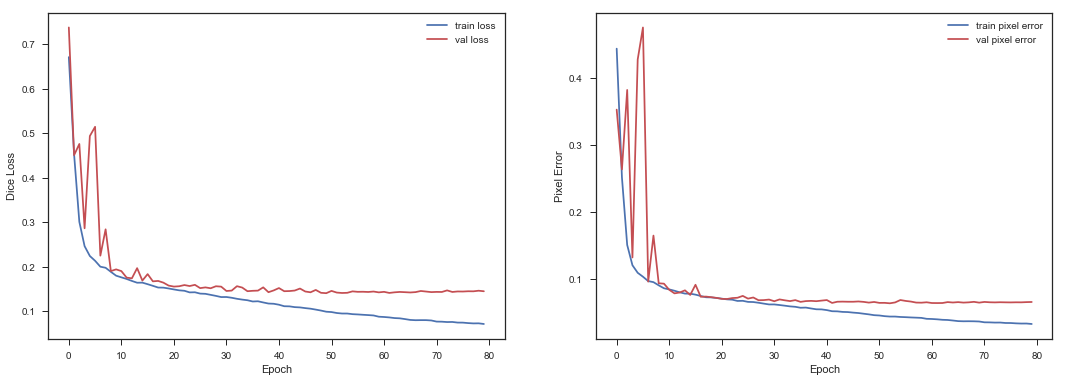

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Dice Loss')
ax[1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Pixel Error')
plt.show()

In [12]:
np.save(RESULT_PATH + 'history_Unet_fuse_v6.npy', results.history)

In [13]:
model_unet_fuse_v6.save_weights(WEIGHT_PATH + 'UNET_fuse_v6_weight.h5')
model_unet_fuse_v6.save(MODEL_PATH + 'UNET_fuse_v6_model.h5')
model_json = model_unet_fuse_v6.to_json()
with open(MODEL_PATH + 'UNET_fuse_v6_model.json', "w") as json_file:
    json_file.write(model_json)

In [14]:
y_pred = model_unet_fuse_v6.predict(X_test, batch_size=5)
result_fuse = (1 - y_pred[-1]).astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

In [15]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v6_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v6_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

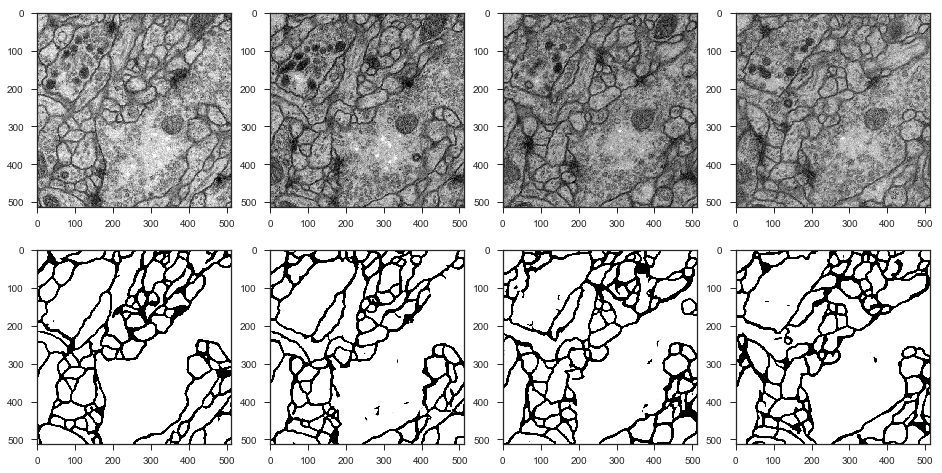

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='gray')

plt.show()

Test with v7

In [7]:
model_unet_fuse_v7 = u_net_fuse_v7(input_shape=(512, 512, 1))
model_unet_fuse_v7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 512, 512, 32) 320         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 512, 512, 32) 128         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation

In [8]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.6, patience=5, verbose=1, 
                             min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v7', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v7.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_fuse_v7.fit(X_train, [y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=80, callbacks=callback_list, verbose=2)

Train on 270 samples, validate on 30 samples


Epoch 1/80


 - 71s - loss: -2.4315e+00 - o1_loss: -4.0120e-01 - o2_loss: -3.5285e-01 - o3_loss: -5.4320e-01 - o4_loss: -5.5777e-01 - ofuse_loss: -5.7645e-01 - ofuse_dice_coef: 0.5764 - ofuse_jaccard_coef: 0.4073 - ofuse_pixel_error: 0.2153 - val_loss: -2.6909e+00 - val_o1_loss: -4.9687e-01 - val_o2_loss: -4.2185e-01 - val_o3_loss: -5.9436e-01 - val_o4_loss: -5.7931e-01 - val_ofuse_loss: -5.9847e-01 - val_ofuse_dice_coef: 0.5985 - val_ofuse_jaccard_coef: 0.4252 - val_ofuse_pixel_error: 0.1737



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.17367, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/80


 - 39s - loss: -3.1978e+00 - o1_loss: -5.7419e-01 - o2_loss: -5.0888e-01 - o3_loss: -7.0808e-01 - o4_loss: -6.8607e-01 - ofuse_loss: -7.2056e-01 - ofuse_dice_coef: 0.7206 - ofuse_jaccard_coef: 0.5612 - ofuse_pixel_error: 0.1141 - val_loss: -3.0782e+00 - val_o1_loss: -5.6863e-01 - val_o2_loss: -5.1185e-01 - val_o3_loss: -6.6212e-01 - val_o4_loss: -6.5089e-01 - val_ofuse_loss: -6.8474e-01 - val_ofuse_dice_coef: 0.6847 - val_ofuse_jaccard_coef: 0.5208 - val_ofuse_pixel_error: 0.1552



Epoch 00002: val_ofuse_pixel_error improved from 0.17367 to 0.15520, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/80


 - 38s - loss: -3.6337e+00 - o1_loss: -6.6222e-01 - o2_loss: -6.6980e-01 - o3_loss: -7.7296e-01 - o4_loss: -7.5605e-01 - ofuse_loss: -7.7271e-01 - ofuse_dice_coef: 0.7727 - ofuse_jaccard_coef: 0.6280 - ofuse_pixel_error: 0.0990 - val_loss: -3.6314e+00 - val_o1_loss: -6.6944e-01 - val_o2_loss: -7.0326e-01 - val_o3_loss: -7.4551e-01 - val_o4_loss: -7.5905e-01 - val_ofuse_loss: -7.5415e-01 - val_ofuse_dice_coef: 0.7542 - val_ofuse_jaccard_coef: 0.6021 - val_ofuse_pixel_error: 0.1003



Epoch 00003: val_ofuse_pixel_error improved from 0.15520 to 0.10026, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/80


 - 39s - loss: -3.8422e+00 - o1_loss: -7.1234e-01 - o2_loss: -7.4938e-01 - o3_loss: -7.9454e-01 - o4_loss: -7.8875e-01 - ofuse_loss: -7.9719e-01 - ofuse_dice_coef: 0.7972 - ofuse_jaccard_coef: 0.6613 - ofuse_pixel_error: 0.0931 - val_loss: -3.7907e+00 - val_o1_loss: -7.0629e-01 - val_o2_loss: -7.4209e-01 - val_o3_loss: -7.7410e-01 - val_o4_loss: -7.8191e-01 - val_ofuse_loss: -7.8636e-01 - val_ofuse_dice_coef: 0.7864 - val_ofuse_jaccard_coef: 0.6447 - val_ofuse_pixel_error: 0.0947



Epoch 00004: val_ofuse_pixel_error improved from 0.10026 to 0.09465, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/80


 - 39s - loss: -3.9385e+00 - o1_loss: -7.4541e-01 - o2_loss: -7.7713e-01 - o3_loss: -8.0374e-01 - o4_loss: -8.0304e-01 - ofuse_loss: -8.0919e-01 - ofuse_dice_coef: 0.8092 - ofuse_jaccard_coef: 0.6782 - ofuse_pixel_error: 0.0894 - val_loss: -3.8822e+00 - val_o1_loss: -7.4177e-01 - val_o2_loss: -7.6689e-01 - val_o3_loss: -7.8865e-01 - val_o4_loss: -7.8786e-01 - val_ofuse_loss: -7.9707e-01 - val_ofuse_dice_coef: 0.7971 - val_ofuse_jaccard_coef: 0.6597 - val_ofuse_pixel_error: 0.0939



Epoch 00005: val_ofuse_pixel_error improved from 0.09465 to 0.09386, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/80


 - 37s - loss: -4.0033e+00 - o1_loss: -7.6678e-01 - o2_loss: -7.9429e-01 - o3_loss: -8.1200e-01 - o4_loss: -8.1263e-01 - ofuse_loss: -8.1757e-01 - ofuse_dice_coef: 0.8176 - ofuse_jaccard_coef: 0.6900 - ofuse_pixel_error: 0.0859 - val_loss: -3.7863e+00 - val_o1_loss: -7.2366e-01 - val_o2_loss: -7.5945e-01 - val_o3_loss: -7.7154e-01 - val_o4_loss: -7.6338e-01 - val_ofuse_loss: -7.6827e-01 - val_ofuse_dice_coef: 0.7683 - val_ofuse_jaccard_coef: 0.6223 - val_ofuse_pixel_error: 0.1196



Epoch 00006: val_ofuse_pixel_error did not improve
Epoch 7/80


 - 37s - loss: -4.0543e+00 - o1_loss: -7.8190e-01 - o2_loss: -8.0686e-01 - o3_loss: -8.1955e-01 - o4_loss: -8.2083e-01 - ofuse_loss: -8.2511e-01 - ofuse_dice_coef: 0.8251 - ofuse_jaccard_coef: 0.7013 - ofuse_pixel_error: 0.0823 - val_loss: -4.0267e+00 - val_o1_loss: -7.8257e-01 - val_o2_loss: -8.0546e-01 - val_o3_loss: -8.1146e-01 - val_o4_loss: -8.1118e-01 - val_ofuse_loss: -8.1607e-01 - val_ofuse_dice_coef: 0.8161 - val_ofuse_jaccard_coef: 0.6870 - val_ofuse_pixel_error: 0.0884



Epoch 00007: val_ofuse_pixel_error improved from 0.09386 to 0.08839, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/80


 - 37s - loss: -4.0745e+00 - o1_loss: -7.8876e-01 - o2_loss: -8.1275e-01 - o3_loss: -8.2219e-01 - o4_loss: -8.2348e-01 - ofuse_loss: -8.2728e-01 - ofuse_dice_coef: 0.8273 - ofuse_jaccard_coef: 0.7043 - ofuse_pixel_error: 0.0814 - val_loss: -4.0301e+00 - val_o1_loss: -7.8867e-01 - val_o2_loss: -8.0886e-01 - val_o3_loss: -8.0984e-01 - val_o4_loss: -8.1019e-01 - val_ofuse_loss: -8.1254e-01 - val_ofuse_dice_coef: 0.8125 - val_ofuse_jaccard_coef: 0.6822 - val_ofuse_pixel_error: 0.0927



Epoch 00008: val_ofuse_pixel_error did not improve
Epoch 9/80


 - 37s - loss: -4.1024e+00 - o1_loss: -7.9604e-01 - o2_loss: -8.1975e-01 - o3_loss: -8.2686e-01 - o4_loss: -8.2824e-01 - ofuse_loss: -8.3153e-01 - ofuse_dice_coef: 0.8315 - ofuse_jaccard_coef: 0.7104 - ofuse_pixel_error: 0.0798 - val_loss: -4.0591e+00 - val_o1_loss: -7.8298e-01 - val_o2_loss: -8.1449e-01 - val_o3_loss: -8.1838e-01 - val_o4_loss: -8.2054e-01 - val_ofuse_loss: -8.2266e-01 - val_ofuse_dice_coef: 0.8227 - val_ofuse_jaccard_coef: 0.6965 - val_ofuse_pixel_error: 0.0825



Epoch 00009: val_ofuse_pixel_error improved from 0.08839 to 0.08249, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/80


 - 37s - loss: -4.1248e+00 - o1_loss: -8.0179e-01 - o2_loss: -8.2514e-01 - o3_loss: -8.3094e-01 - o4_loss: -8.3185e-01 - ofuse_loss: -8.3507e-01 - ofuse_dice_coef: 0.8351 - ofuse_jaccard_coef: 0.7157 - ofuse_pixel_error: 0.0777 - val_loss: -4.1148e+00 - val_o1_loss: -8.0389e-01 - val_o2_loss: -8.2399e-01 - val_o3_loss: -8.2864e-01 - val_o4_loss: -8.2767e-01 - val_ofuse_loss: -8.3062e-01 - val_ofuse_dice_coef: 0.8306 - val_ofuse_jaccard_coef: 0.7084 - val_ofuse_pixel_error: 0.0818



Epoch 00010: val_ofuse_pixel_error improved from 0.08249 to 0.08176, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 11/80


 - 37s - loss: -4.1458e+00 - o1_loss: -8.0640e-01 - o2_loss: -8.3011e-01 - o3_loss: -8.3496e-01 - o4_loss: -8.3569e-01 - ofuse_loss: -8.3863e-01 - ofuse_dice_coef: 0.8386 - ofuse_jaccard_coef: 0.7211 - ofuse_pixel_error: 0.0761 - val_loss: -4.1296e+00 - val_o1_loss: -8.0606e-01 - val_o2_loss: -8.2765e-01 - val_o3_loss: -8.3085e-01 - val_o4_loss: -8.3106e-01 - val_ofuse_loss: -8.3399e-01 - val_ofuse_dice_coef: 0.8340 - val_ofuse_jaccard_coef: 0.7139 - val_ofuse_pixel_error: 0.0778



Epoch 00011: val_ofuse_pixel_error improved from 0.08176 to 0.07779, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/80


 - 37s - loss: -4.1588e+00 - o1_loss: -8.0963e-01 - o2_loss: -8.3330e-01 - o3_loss: -8.3745e-01 - o4_loss: -8.3785e-01 - ofuse_loss: -8.4059e-01 - ofuse_dice_coef: 0.8406 - ofuse_jaccard_coef: 0.7238 - ofuse_pixel_error: 0.0752 - val_loss: -4.1244e+00 - val_o1_loss: -8.0506e-01 - val_o2_loss: -8.2759e-01 - val_o3_loss: -8.2900e-01 - val_o4_loss: -8.3023e-01 - val_ofuse_loss: -8.3255e-01 - val_ofuse_dice_coef: 0.8326 - val_ofuse_jaccard_coef: 0.7113 - val_ofuse_pixel_error: 0.0752



Epoch 00012: val_ofuse_pixel_error improved from 0.07779 to 0.07517, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 13/80


 - 37s - loss: -4.1787e+00 - o1_loss: -8.1392e-01 - o2_loss: -8.3745e-01 - o3_loss: -8.4139e-01 - o4_loss: -8.4167e-01 - ofuse_loss: -8.4423e-01 - ofuse_dice_coef: 0.8442 - ofuse_jaccard_coef: 0.7294 - ofuse_pixel_error: 0.0734 - val_loss: -4.1067e+00 - val_o1_loss: -7.9877e-01 - val_o2_loss: -8.2312e-01 - val_o3_loss: -8.2614e-01 - val_o4_loss: -8.2798e-01 - val_ofuse_loss: -8.3069e-01 - val_ofuse_dice_coef: 0.8307 - val_ofuse_jaccard_coef: 0.7091 - val_ofuse_pixel_error: 0.0752



Epoch 00013: val_ofuse_pixel_error did not improve
Epoch 14/80


 - 37s - loss: -4.1938e+00 - o1_loss: -8.1712e-01 - o2_loss: -8.4073e-01 - o3_loss: -8.4445e-01 - o4_loss: -8.4452e-01 - ofuse_loss: -8.4702e-01 - ofuse_dice_coef: 0.8470 - ofuse_jaccard_coef: 0.7333 - ofuse_pixel_error: 0.0719 - val_loss: -4.1130e+00 - val_o1_loss: -7.9751e-01 - val_o2_loss: -8.2407e-01 - val_o3_loss: -8.2907e-01 - val_o4_loss: -8.2989e-01 - val_ofuse_loss: -8.3244e-01 - val_ofuse_dice_coef: 0.8324 - val_ofuse_jaccard_coef: 0.7113 - val_ofuse_pixel_error: 0.0737



Epoch 00014: val_ofuse_pixel_error improved from 0.07517 to 0.07372, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 15/80


 - 37s - loss: -4.1957e+00 - o1_loss: -8.1811e-01 - o2_loss: -8.4114e-01 - o3_loss: -8.4477e-01 - o4_loss: -8.4468e-01 - ofuse_loss: -8.4701e-01 - ofuse_dice_coef: 0.8470 - ofuse_jaccard_coef: 0.7334 - ofuse_pixel_error: 0.0720 - val_loss: -4.1737e+00 - val_o1_loss: -8.1514e-01 - val_o2_loss: -8.3703e-01 - val_o3_loss: -8.4027e-01 - val_o4_loss: -8.3959e-01 - val_ofuse_loss: -8.4172e-01 - val_ofuse_dice_coef: 0.8417 - val_ofuse_jaccard_coef: 0.7248 - val_ofuse_pixel_error: 0.0753



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/80


 - 37s - loss: -4.2152e+00 - o1_loss: -8.2194e-01 - o2_loss: -8.4518e-01 - o3_loss: -8.4867e-01 - o4_loss: -8.4855e-01 - ofuse_loss: -8.5082e-01 - ofuse_dice_coef: 0.8508 - ofuse_jaccard_coef: 0.7393 - ofuse_pixel_error: 0.0701 - val_loss: -4.1719e+00 - val_o1_loss: -8.1832e-01 - val_o2_loss: -8.3808e-01 - val_o3_loss: -8.3858e-01 - val_o4_loss: -8.3755e-01 - val_ofuse_loss: -8.3938e-01 - val_ofuse_dice_coef: 0.8394 - val_ofuse_jaccard_coef: 0.7219 - val_ofuse_pixel_error: 0.0779



Epoch 00016: val_ofuse_pixel_error did not improve
Epoch 17/80


 - 37s - loss: -4.2274e+00 - o1_loss: -8.2425e-01 - o2_loss: -8.4767e-01 - o3_loss: -8.5118e-01 - o4_loss: -8.5109e-01 - ofuse_loss: -8.5324e-01 - ofuse_dice_coef: 0.8532 - ofuse_jaccard_coef: 0.7426 - ofuse_pixel_error: 0.0690 - val_loss: -4.1532e+00 - val_o1_loss: -8.1725e-01 - val_o2_loss: -8.3269e-01 - val_o3_loss: -8.3419e-01 - val_o4_loss: -8.3280e-01 - val_ofuse_loss: -8.3625e-01 - val_ofuse_dice_coef: 0.8362 - val_ofuse_jaccard_coef: 0.7169 - val_ofuse_pixel_error: 0.0709



Epoch 00017: val_ofuse_pixel_error improved from 0.07372 to 0.07092, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 18/80


 - 37s - loss: -4.2350e+00 - o1_loss: -8.2630e-01 - o2_loss: -8.4931e-01 - o3_loss: -8.5264e-01 - o4_loss: -8.5233e-01 - ofuse_loss: -8.5444e-01 - ofuse_dice_coef: 0.8544 - ofuse_jaccard_coef: 0.7446 - ofuse_pixel_error: 0.0683 - val_loss: -4.1563e+00 - val_o1_loss: -8.1497e-01 - val_o2_loss: -8.3090e-01 - val_o3_loss: -8.3517e-01 - val_o4_loss: -8.3601e-01 - val_ofuse_loss: -8.3923e-01 - val_ofuse_dice_coef: 0.8392 - val_ofuse_jaccard_coef: 0.7216 - val_ofuse_pixel_error: 0.0710



Epoch 00018: val_ofuse_pixel_error did not improve
Epoch 19/80


 - 36s - loss: -4.2543e+00 - o1_loss: -8.2993e-01 - o2_loss: -8.5318e-01 - o3_loss: -8.5651e-01 - o4_loss: -8.5633e-01 - ofuse_loss: -8.5837e-01 - ofuse_dice_coef: 0.8584 - ofuse_jaccard_coef: 0.7506 - ofuse_pixel_error: 0.0664 - val_loss: -4.2163e+00 - val_o1_loss: -8.2184e-01 - val_o2_loss: -8.4599e-01 - val_o3_loss: -8.4921e-01 - val_o4_loss: -8.4864e-01 - val_ofuse_loss: -8.5064e-01 - val_ofuse_dice_coef: 0.8506 - val_ofuse_jaccard_coef: 0.7380 - val_ofuse_pixel_error: 0.0683



Epoch 00019: val_ofuse_pixel_error improved from 0.07092 to 0.06830, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 20/80


 - 36s - loss: -4.2571e+00 - o1_loss: -8.3116e-01 - o2_loss: -8.5372e-01 - o3_loss: -8.5683e-01 - o4_loss: -8.5673e-01 - ofuse_loss: -8.5865e-01 - ofuse_dice_coef: 0.8587 - ofuse_jaccard_coef: 0.7510 - ofuse_pixel_error: 0.0663 - val_loss: -4.2219e+00 - val_o1_loss: -8.2640e-01 - val_o2_loss: -8.4740e-01 - val_o3_loss: -8.4914e-01 - val_o4_loss: -8.4840e-01 - val_ofuse_loss: -8.5054e-01 - val_ofuse_dice_coef: 0.8505 - val_ofuse_jaccard_coef: 0.7383 - val_ofuse_pixel_error: 0.0687



Epoch 00020: val_ofuse_pixel_error did not improve
Epoch 21/80


 - 36s - loss: -4.2684e+00 - o1_loss: -8.3314e-01 - o2_loss: -8.5615e-01 - o3_loss: -8.5921e-01 - o4_loss: -8.5900e-01 - ofuse_loss: -8.6084e-01 - ofuse_dice_coef: 0.8608 - ofuse_jaccard_coef: 0.7544 - ofuse_pixel_error: 0.0653 - val_loss: -4.2076e+00 - val_o1_loss: -8.2376e-01 - val_o2_loss: -8.4368e-01 - val_o3_loss: -8.4607e-01 - val_o4_loss: -8.4609e-01 - val_ofuse_loss: -8.4800e-01 - val_ofuse_dice_coef: 0.8480 - val_ofuse_jaccard_coef: 0.7342 - val_ofuse_pixel_error: 0.0687



Epoch 00021: val_ofuse_pixel_error did not improve
Epoch 22/80


 - 36s - loss: -4.2822e+00 - o1_loss: -8.3556e-01 - o2_loss: -8.5884e-01 - o3_loss: -8.6204e-01 - o4_loss: -8.6198e-01 - ofuse_loss: -8.6378e-01 - ofuse_dice_coef: 0.8638 - ofuse_jaccard_coef: 0.7590 - ofuse_pixel_error: 0.0638 - val_loss: -4.2336e+00 - val_o1_loss: -8.2791e-01 - val_o2_loss: -8.4905e-01 - val_o3_loss: -8.5130e-01 - val_o4_loss: -8.5159e-01 - val_ofuse_loss: -8.5377e-01 - val_ofuse_dice_coef: 0.8538 - val_ofuse_jaccard_coef: 0.7431 - val_ofuse_pixel_error: 0.0663



Epoch 00022: val_ofuse_pixel_error improved from 0.06830 to 0.06627, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 23/80


 - 36s - loss: -4.2953e+00 - o1_loss: -8.3856e-01 - o2_loss: -8.6150e-01 - o3_loss: -8.6453e-01 - o4_loss: -8.6454e-01 - ofuse_loss: -8.6618e-01 - ofuse_dice_coef: 0.8662 - ofuse_jaccard_coef: 0.7628 - ofuse_pixel_error: 0.0626 - val_loss: -4.2449e+00 - val_o1_loss: -8.2992e-01 - val_o2_loss: -8.5076e-01 - val_o3_loss: -8.5416e-01 - val_o4_loss: -8.5396e-01 - val_ofuse_loss: -8.5612e-01 - val_ofuse_dice_coef: 0.8561 - val_ofuse_jaccard_coef: 0.7465 - val_ofuse_pixel_error: 0.0665



Epoch 00023: val_ofuse_pixel_error did not improve
Epoch 24/80


 - 36s - loss: -4.3015e+00 - o1_loss: -8.3989e-01 - o2_loss: -8.6277e-01 - o3_loss: -8.6570e-01 - o4_loss: -8.6580e-01 - ofuse_loss: -8.6733e-01 - ofuse_dice_coef: 0.8673 - ofuse_jaccard_coef: 0.7647 - ofuse_pixel_error: 0.0620 - val_loss: -4.2580e+00 - val_o1_loss: -8.3298e-01 - val_o2_loss: -8.5402e-01 - val_o3_loss: -8.5690e-01 - val_o4_loss: -8.5612e-01 - val_ofuse_loss: -8.5797e-01 - val_ofuse_dice_coef: 0.8580 - val_ofuse_jaccard_coef: 0.7495 - val_ofuse_pixel_error: 0.0653



Epoch 00024: val_ofuse_pixel_error improved from 0.06627 to 0.06534, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 25/80


 - 36s - loss: -4.3173e+00 - o1_loss: -8.4265e-01 - o2_loss: -8.6593e-01 - o3_loss: -8.6897e-01 - o4_loss: -8.6921e-01 - ofuse_loss: -8.7053e-01 - ofuse_dice_coef: 0.8705 - ofuse_jaccard_coef: 0.7695 - ofuse_pixel_error: 0.0605 - val_loss: -4.2381e+00 - val_o1_loss: -8.2976e-01 - val_o2_loss: -8.5023e-01 - val_o3_loss: -8.5292e-01 - val_o4_loss: -8.5148e-01 - val_ofuse_loss: -8.5374e-01 - val_ofuse_dice_coef: 0.8537 - val_ofuse_jaccard_coef: 0.7427 - val_ofuse_pixel_error: 0.0666



Epoch 00025: val_ofuse_pixel_error did not improve
Epoch 26/80


 - 36s - loss: -4.3274e+00 - o1_loss: -8.4468e-01 - o2_loss: -8.6805e-01 - o3_loss: -8.7090e-01 - o4_loss: -8.7134e-01 - ofuse_loss: -8.7240e-01 - ofuse_dice_coef: 0.8724 - ofuse_jaccard_coef: 0.7726 - ofuse_pixel_error: 0.0596 - val_loss: -4.2557e+00 - val_o1_loss: -8.3321e-01 - val_o2_loss: -8.5309e-01 - val_o3_loss: -8.5614e-01 - val_o4_loss: -8.5584e-01 - val_ofuse_loss: -8.5739e-01 - val_ofuse_dice_coef: 0.8574 - val_ofuse_jaccard_coef: 0.7485 - val_ofuse_pixel_error: 0.0651



Epoch 00026: val_ofuse_pixel_error improved from 0.06534 to 0.06513, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 27/80


 - 36s - loss: -4.3280e+00 - o1_loss: -8.4467e-01 - o2_loss: -8.6815e-01 - o3_loss: -8.7100e-01 - o4_loss: -8.7170e-01 - ofuse_loss: -8.7253e-01 - ofuse_dice_coef: 0.8725 - ofuse_jaccard_coef: 0.7727 - ofuse_pixel_error: 0.0595 - val_loss: -4.2416e+00 - val_o1_loss: -8.2976e-01 - val_o2_loss: -8.5072e-01 - val_o3_loss: -8.5393e-01 - val_o4_loss: -8.5295e-01 - val_ofuse_loss: -8.5427e-01 - val_ofuse_dice_coef: 0.8543 - val_ofuse_jaccard_coef: 0.7438 - val_ofuse_pixel_error: 0.0649



Epoch 00027: val_ofuse_pixel_error improved from 0.06513 to 0.06489, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 28/80


 - 36s - loss: -4.3511e+00 - o1_loss: -8.4872e-01 - o2_loss: -8.7271e-01 - o3_loss: -8.7573e-01 - o4_loss: -8.7663e-01 - ofuse_loss: -8.7726e-01 - ofuse_dice_coef: 0.8773 - ofuse_jaccard_coef: 0.7804 - ofuse_pixel_error: 0.0573 - val_loss: -4.2329e+00 - val_o1_loss: -8.2865e-01 - val_o2_loss: -8.4951e-01 - val_o3_loss: -8.5165e-01 - val_o4_loss: -8.5102e-01 - val_ofuse_loss: -8.5204e-01 - val_ofuse_dice_coef: 0.8520 - val_ofuse_jaccard_coef: 0.7406 - val_ofuse_pixel_error: 0.0666



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/80


 - 36s - loss: -4.3583e+00 - o1_loss: -8.5018e-01 - o2_loss: -8.7414e-01 - o3_loss: -8.7716e-01 - o4_loss: -8.7814e-01 - ofuse_loss: -8.7868e-01 - ofuse_dice_coef: 0.8787 - ofuse_jaccard_coef: 0.7823 - ofuse_pixel_error: 0.0565 - val_loss: -4.2798e+00 - val_o1_loss: -8.3634e-01 - val_o2_loss: -8.5804e-01 - val_o3_loss: -8.6119e-01 - val_o4_loss: -8.6190e-01 - val_ofuse_loss: -8.6232e-01 - val_ofuse_dice_coef: 0.8623 - val_ofuse_jaccard_coef: 0.7560 - val_ofuse_pixel_error: 0.0635



Epoch 00029: val_ofuse_pixel_error improved from 0.06489 to 0.06351, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 30/80


 - 36s - loss: -4.3674e+00 - o1_loss: -8.5197e-01 - o2_loss: -8.7597e-01 - o3_loss: -8.7899e-01 - o4_loss: -8.8000e-01 - ofuse_loss: -8.8046e-01 - ofuse_dice_coef: 0.8805 - ofuse_jaccard_coef: 0.7855 - ofuse_pixel_error: 0.0558 - val_loss: -4.2676e+00 - val_o1_loss: -8.3530e-01 - val_o2_loss: -8.5497e-01 - val_o3_loss: -8.5901e-01 - val_o4_loss: -8.5858e-01 - val_ofuse_loss: -8.5975e-01 - val_ofuse_dice_coef: 0.8597 - val_ofuse_jaccard_coef: 0.7523 - val_ofuse_pixel_error: 0.0625



Epoch 00030: val_ofuse_pixel_error improved from 0.06351 to 0.06252, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 31/80


 - 36s - loss: -4.3796e+00 - o1_loss: -8.5409e-01 - o2_loss: -8.7845e-01 - o3_loss: -8.8147e-01 - o4_loss: -8.8256e-01 - ofuse_loss: -8.8300e-01 - ofuse_dice_coef: 0.8830 - ofuse_jaccard_coef: 0.7895 - ofuse_pixel_error: 0.0544 - val_loss: -4.2832e+00 - val_o1_loss: -8.3672e-01 - val_o2_loss: -8.5937e-01 - val_o3_loss: -8.6167e-01 - val_o4_loss: -8.6262e-01 - val_ofuse_loss: -8.6281e-01 - val_ofuse_dice_coef: 0.8628 - val_ofuse_jaccard_coef: 0.7567 - val_ofuse_pixel_error: 0.0639



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/80


 - 36s - loss: -4.3881e+00 - o1_loss: -8.5557e-01 - o2_loss: -8.8022e-01 - o3_loss: -8.8328e-01 - o4_loss: -8.8432e-01 - ofuse_loss: -8.8468e-01 - ofuse_dice_coef: 0.8847 - ofuse_jaccard_coef: 0.7922 - ofuse_pixel_error: 0.0538 - val_loss: -4.2745e+00 - val_o1_loss: -8.3767e-01 - val_o2_loss: -8.5695e-01 - val_o3_loss: -8.5917e-01 - val_o4_loss: -8.6006e-01 - val_ofuse_loss: -8.6063e-01 - val_ofuse_dice_coef: 0.8606 - val_ofuse_jaccard_coef: 0.7537 - val_ofuse_pixel_error: 0.0634



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/80


 - 36s - loss: -4.3972e+00 - o1_loss: -8.5740e-01 - o2_loss: -8.8199e-01 - o3_loss: -8.8506e-01 - o4_loss: -8.8617e-01 - ofuse_loss: -8.8654e-01 - ofuse_dice_coef: 0.8865 - ofuse_jaccard_coef: 0.7950 - ofuse_pixel_error: 0.0527 - val_loss: -4.2773e+00 - val_o1_loss: -8.3764e-01 - val_o2_loss: -8.5820e-01 - val_o3_loss: -8.5990e-01 - val_o4_loss: -8.6051e-01 - val_ofuse_loss: -8.6101e-01 - val_ofuse_dice_coef: 0.8610 - val_ofuse_jaccard_coef: 0.7540 - val_ofuse_pixel_error: 0.0625



Epoch 00033: val_ofuse_pixel_error improved from 0.06252 to 0.06251, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 34/80


 - 35s - loss: -4.4039e+00 - o1_loss: -8.5869e-01 - o2_loss: -8.8329e-01 - o3_loss: -8.8644e-01 - o4_loss: -8.8757e-01 - ofuse_loss: -8.8789e-01 - ofuse_dice_coef: 0.8879 - ofuse_jaccard_coef: 0.7974 - ofuse_pixel_error: 0.0522 - val_loss: -4.2540e+00 - val_o1_loss: -8.3128e-01 - val_o2_loss: -8.5422e-01 - val_o3_loss: -8.5566e-01 - val_o4_loss: -8.5621e-01 - val_ofuse_loss: -8.5663e-01 - val_ofuse_dice_coef: 0.8566 - val_ofuse_jaccard_coef: 0.7475 - val_ofuse_pixel_error: 0.0631



Epoch 00034: val_ofuse_pixel_error did not improve
Epoch 35/80


 - 36s - loss: -4.4170e+00 - o1_loss: -8.6112e-01 - o2_loss: -8.8616e-01 - o3_loss: -8.8907e-01 - o4_loss: -8.9015e-01 - ofuse_loss: -8.9049e-01 - ofuse_dice_coef: 0.8905 - ofuse_jaccard_coef: 0.8014 - ofuse_pixel_error: 0.0508 - val_loss: -4.2823e+00 - val_o1_loss: -8.3821e-01 - val_o2_loss: -8.5844e-01 - val_o3_loss: -8.6163e-01 - val_o4_loss: -8.6172e-01 - val_ofuse_loss: -8.6231e-01 - val_ofuse_dice_coef: 0.8623 - val_ofuse_jaccard_coef: 0.7559 - val_ofuse_pixel_error: 0.0617



Epoch 00035: val_ofuse_pixel_error improved from 0.06251 to 0.06174, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 36/80


 - 35s - loss: -4.4256e+00 - o1_loss: -8.6244e-01 - o2_loss: -8.8787e-01 - o3_loss: -8.9091e-01 - o4_loss: -8.9204e-01 - ofuse_loss: -8.9235e-01 - ofuse_dice_coef: 0.8923 - ofuse_jaccard_coef: 0.8046 - ofuse_pixel_error: 0.0500 - val_loss: -4.2704e+00 - val_o1_loss: -8.3699e-01 - val_o2_loss: -8.5687e-01 - val_o3_loss: -8.5874e-01 - val_o4_loss: -8.5879e-01 - val_ofuse_loss: -8.5903e-01 - val_ofuse_dice_coef: 0.8590 - val_ofuse_jaccard_coef: 0.7508 - val_ofuse_pixel_error: 0.0646



Epoch 00036: val_ofuse_pixel_error did not improve
Epoch 37/80


 - 35s - loss: -4.4345e+00 - o1_loss: -8.6426e-01 - o2_loss: -8.8968e-01 - o3_loss: -8.9270e-01 - o4_loss: -8.9379e-01 - ofuse_loss: -8.9406e-01 - ofuse_dice_coef: 0.8941 - ofuse_jaccard_coef: 0.8073 - ofuse_pixel_error: 0.0492 - val_loss: -4.2958e+00 - val_o1_loss: -8.4158e-01 - val_o2_loss: -8.6152e-01 - val_o3_loss: -8.6374e-01 - val_o4_loss: -8.6431e-01 - val_ofuse_loss: -8.6466e-01 - val_ofuse_dice_coef: 0.8647 - val_ofuse_jaccard_coef: 0.7597 - val_ofuse_pixel_error: 0.0620



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/80


 - 35s - loss: -4.4411e+00 - o1_loss: -8.6527e-01 - o2_loss: -8.9104e-01 - o3_loss: -8.9415e-01 - o4_loss: -8.9518e-01 - ofuse_loss: -8.9547e-01 - ofuse_dice_coef: 0.8955 - ofuse_jaccard_coef: 0.8100 - ofuse_pixel_error: 0.0485 - val_loss: -4.1921e+00 - val_o1_loss: -8.2759e-01 - val_o2_loss: -8.3761e-01 - val_o3_loss: -8.3979e-01 - val_o4_loss: -8.4286e-01 - val_ofuse_loss: -8.4422e-01 - val_ofuse_dice_coef: 0.8442 - val_ofuse_jaccard_coef: 0.7288 - val_ofuse_pixel_error: 0.0666



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/80


 - 35s - loss: -4.4540e+00 - o1_loss: -8.6762e-01 - o2_loss: -8.9372e-01 - o3_loss: -8.9674e-01 - o4_loss: -8.9783e-01 - ofuse_loss: -8.9810e-01 - ofuse_dice_coef: 0.8981 - ofuse_jaccard_coef: 0.8141 - ofuse_pixel_error: 0.0473 - val_loss: -4.2925e+00 - val_o1_loss: -8.3993e-01 - val_o2_loss: -8.6044e-01 - val_o3_loss: -8.6330e-01 - val_o4_loss: -8.6428e-01 - val_ofuse_loss: -8.6455e-01 - val_ofuse_dice_coef: 0.8646 - val_ofuse_jaccard_coef: 0.7596 - val_ofuse_pixel_error: 0.0616



Epoch 00039: val_ofuse_pixel_error improved from 0.06174 to 0.06162, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 40/80


 - 35s - loss: -4.4664e+00 - o1_loss: -8.6971e-01 - o2_loss: -8.9617e-01 - o3_loss: -8.9936e-01 - o4_loss: -9.0045e-01 - ofuse_loss: -9.0070e-01 - ofuse_dice_coef: 0.9007 - ofuse_jaccard_coef: 0.8185 - ofuse_pixel_error: 0.0460 - val_loss: -4.2878e+00 - val_o1_loss: -8.4060e-01 - val_o2_loss: -8.5909e-01 - val_o3_loss: -8.6187e-01 - val_o4_loss: -8.6286e-01 - val_ofuse_loss: -8.6341e-01 - val_ofuse_dice_coef: 0.8634 - val_ofuse_jaccard_coef: 0.7577 - val_ofuse_pixel_error: 0.0620



Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/80


 - 35s - loss: -4.4731e+00 - o1_loss: -8.7091e-01 - o2_loss: -8.9759e-01 - o3_loss: -9.0074e-01 - o4_loss: -9.0181e-01 - ofuse_loss: -9.0206e-01 - ofuse_dice_coef: 0.9021 - ofuse_jaccard_coef: 0.8207 - ofuse_pixel_error: 0.0454 - val_loss: -4.2980e+00 - val_o1_loss: -8.4245e-01 - val_o2_loss: -8.6164e-01 - val_o3_loss: -8.6397e-01 - val_o4_loss: -8.6480e-01 - val_ofuse_loss: -8.6513e-01 - val_ofuse_dice_coef: 0.8651 - val_ofuse_jaccard_coef: 0.7603 - val_ofuse_pixel_error: 0.0612



Epoch 00041: val_ofuse_pixel_error improved from 0.06162 to 0.06123, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 42/80


 - 35s - loss: -4.4823e+00 - o1_loss: -8.7251e-01 - o2_loss: -8.9944e-01 - o3_loss: -9.0263e-01 - o4_loss: -9.0373e-01 - ofuse_loss: -9.0398e-01 - ofuse_dice_coef: 0.9040 - ofuse_jaccard_coef: 0.8238 - ofuse_pixel_error: 0.0444 - val_loss: -4.2985e+00 - val_o1_loss: -8.4197e-01 - val_o2_loss: -8.6183e-01 - val_o3_loss: -8.6442e-01 - val_o4_loss: -8.6509e-01 - val_ofuse_loss: -8.6519e-01 - val_ofuse_dice_coef: 0.8652 - val_ofuse_jaccard_coef: 0.7602 - val_ofuse_pixel_error: 0.0622



Epoch 00042: val_ofuse_pixel_error did not improve
Epoch 43/80


 - 35s - loss: -4.4887e+00 - o1_loss: -8.7384e-01 - o2_loss: -9.0088e-01 - o3_loss: -9.0392e-01 - o4_loss: -9.0490e-01 - ofuse_loss: -9.0515e-01 - ofuse_dice_coef: 0.9052 - ofuse_jaccard_coef: 0.8257 - ofuse_pixel_error: 0.0439 - val_loss: -4.2916e+00 - val_o1_loss: -8.4106e-01 - val_o2_loss: -8.6052e-01 - val_o3_loss: -8.6281e-01 - val_o4_loss: -8.6350e-01 - val_ofuse_loss: -8.6375e-01 - val_ofuse_dice_coef: 0.8637 - val_ofuse_jaccard_coef: 0.7585 - val_ofuse_pixel_error: 0.0634



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/80


 - 35s - loss: -4.4924e+00 - o1_loss: -8.7440e-01 - o2_loss: -9.0157e-01 - o3_loss: -9.0472e-01 - o4_loss: -9.0576e-01 - ofuse_loss: -9.0600e-01 - ofuse_dice_coef: 0.9060 - ofuse_jaccard_coef: 0.8273 - ofuse_pixel_error: 0.0435 - val_loss: -4.2957e+00 - val_o1_loss: -8.4170e-01 - val_o2_loss: -8.6133e-01 - val_o3_loss: -8.6356e-01 - val_o4_loss: -8.6431e-01 - val_ofuse_loss: -8.6476e-01 - val_ofuse_dice_coef: 0.8648 - val_ofuse_jaccard_coef: 0.7603 - val_ofuse_pixel_error: 0.0620



Epoch 00044: val_ofuse_pixel_error did not improve
Epoch 45/80


 - 35s - loss: -4.5059e+00 - o1_loss: -8.7657e-01 - o2_loss: -9.0437e-01 - o3_loss: -9.0757e-01 - o4_loss: -9.0862e-01 - ofuse_loss: -9.0882e-01 - ofuse_dice_coef: 0.9088 - ofuse_jaccard_coef: 0.8320 - ofuse_pixel_error: 0.0422 - val_loss: -4.2871e+00 - val_o1_loss: -8.4201e-01 - val_o2_loss: -8.6038e-01 - val_o3_loss: -8.6139e-01 - val_o4_loss: -8.6144e-01 - val_ofuse_loss: -8.6193e-01 - val_ofuse_dice_coef: 0.8619 - val_ofuse_jaccard_coef: 0.7557 - val_ofuse_pixel_error: 0.0617



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/80


 - 35s - loss: -4.5110e+00 - o1_loss: -8.7748e-01 - o2_loss: -9.0550e-01 - o3_loss: -9.0861e-01 - o4_loss: -9.0960e-01 - ofuse_loss: -9.0982e-01 - ofuse_dice_coef: 0.9098 - ofuse_jaccard_coef: 0.8337 - ofuse_pixel_error: 0.0417 - val_loss: -4.2865e+00 - val_o1_loss: -8.3940e-01 - val_o2_loss: -8.5841e-01 - val_o3_loss: -8.6215e-01 - val_o4_loss: -8.6310e-01 - val_ofuse_loss: -8.6342e-01 - val_ofuse_dice_coef: 0.8634 - val_ofuse_jaccard_coef: 0.7576 - val_ofuse_pixel_error: 0.0618



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/80


 - 35s - loss: -4.5130e+00 - o1_loss: -8.7775e-01 - o2_loss: -9.0589e-01 - o3_loss: -9.0903e-01 - o4_loss: -9.1006e-01 - ofuse_loss: -9.1030e-01 - ofuse_dice_coef: 0.9103 - ofuse_jaccard_coef: 0.8345 - ofuse_pixel_error: 0.0414 - val_loss: -4.3035e+00 - val_o1_loss: -8.4384e-01 - val_o2_loss: -8.6305e-01 - val_o3_loss: -8.6512e-01 - val_o4_loss: -8.6562e-01 - val_ofuse_loss: -8.6584e-01 - val_ofuse_dice_coef: 0.8658 - val_ofuse_jaccard_coef: 0.7616 - val_ofuse_pixel_error: 0.0623



Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.000600000028498.

Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/80


 - 35s - loss: -4.5330e+00 - o1_loss: -8.8130e-01 - o2_loss: -9.0984e-01 - o3_loss: -9.1317e-01 - o4_loss: -9.1422e-01 - ofuse_loss: -9.1441e-01 - ofuse_dice_coef: 0.9144 - ofuse_jaccard_coef: 0.8415 - ofuse_pixel_error: 0.0396 - val_loss: -4.2830e+00 - val_o1_loss: -8.3896e-01 - val_o2_loss: -8.5860e-01 - val_o3_loss: -8.6077e-01 - val_o4_loss: -8.6220e-01 - val_ofuse_loss: -8.6247e-01 - val_ofuse_dice_coef: 0.8625 - val_ofuse_jaccard_coef: 0.7565 - val_ofuse_pixel_error: 0.0614



Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/80


 - 35s - loss: -4.5451e+00 - o1_loss: -8.8335e-01 - o2_loss: -9.1246e-01 - o3_loss: -9.1569e-01 - o4_loss: -9.1669e-01 - ofuse_loss: -9.1692e-01 - ofuse_dice_coef: 0.9169 - ofuse_jaccard_coef: 0.8459 - ofuse_pixel_error: 0.0383 - val_loss: -4.3006e+00 - val_o1_loss: -8.4350e-01 - val_o2_loss: -8.6283e-01 - val_o3_loss: -8.6436e-01 - val_o4_loss: -8.6482e-01 - val_ofuse_loss: -8.6507e-01 - val_ofuse_dice_coef: 0.8651 - val_ofuse_jaccard_coef: 0.7602 - val_ofuse_pixel_error: 0.0607



Epoch 00049: val_ofuse_pixel_error improved from 0.06123 to 0.06069, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 50/80


 - 35s - loss: -4.5575e+00 - o1_loss: -8.8520e-01 - o2_loss: -9.1503e-01 - o3_loss: -9.1829e-01 - o4_loss: -9.1936e-01 - ofuse_loss: -9.1956e-01 - ofuse_dice_coef: 0.9196 - ofuse_jaccard_coef: 0.8503 - ofuse_pixel_error: 0.0371 - val_loss: -4.2967e+00 - val_o1_loss: -8.4224e-01 - val_o2_loss: -8.6213e-01 - val_o3_loss: -8.6366e-01 - val_o4_loss: -8.6419e-01 - val_ofuse_loss: -8.6447e-01 - val_ofuse_dice_coef: 0.8645 - val_ofuse_jaccard_coef: 0.7594 - val_ofuse_pixel_error: 0.0607



Epoch 00050: val_ofuse_pixel_error improved from 0.06069 to 0.06067, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 51/80


 - 35s - loss: -4.5618e+00 - o1_loss: -8.8612e-01 - o2_loss: -9.1582e-01 - o3_loss: -9.1916e-01 - o4_loss: -9.2021e-01 - ofuse_loss: -9.2044e-01 - ofuse_dice_coef: 0.9204 - ofuse_jaccard_coef: 0.8518 - ofuse_pixel_error: 0.0367 - val_loss: -4.2986e+00 - val_o1_loss: -8.4284e-01 - val_o2_loss: -8.6228e-01 - val_o3_loss: -8.6402e-01 - val_o4_loss: -8.6460e-01 - val_ofuse_loss: -8.6490e-01 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7599 - val_ofuse_pixel_error: 0.0607



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/80


 - 35s - loss: -4.5596e+00 - o1_loss: -8.8570e-01 - o2_loss: -9.1537e-01 - o3_loss: -9.1874e-01 - o4_loss: -9.1980e-01 - ofuse_loss: -9.2002e-01 - ofuse_dice_coef: 0.9200 - ofuse_jaccard_coef: 0.8511 - ofuse_pixel_error: 0.0368 - val_loss: -4.2891e+00 - val_o1_loss: -8.4249e-01 - val_o2_loss: -8.6091e-01 - val_o3_loss: -8.6157e-01 - val_o4_loss: -8.6184e-01 - val_ofuse_loss: -8.6223e-01 - val_ofuse_dice_coef: 0.8622 - val_ofuse_jaccard_coef: 0.7559 - val_ofuse_pixel_error: 0.0615



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/80


 - 35s - loss: -4.5714e+00 - o1_loss: -8.8754e-01 - o2_loss: -9.1784e-01 - o3_loss: -9.2123e-01 - o4_loss: -9.2228e-01 - ofuse_loss: -9.2249e-01 - ofuse_dice_coef: 0.9225 - ofuse_jaccard_coef: 0.8553 - ofuse_pixel_error: 0.0357 - val_loss: -4.2976e+00 - val_o1_loss: -8.4244e-01 - val_o2_loss: -8.6193e-01 - val_o3_loss: -8.6372e-01 - val_o4_loss: -8.6460e-01 - val_ofuse_loss: -8.6490e-01 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7600 - val_ofuse_pixel_error: 0.0606



Epoch 00053: val_ofuse_pixel_error improved from 0.06067 to 0.06055, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 54/80


 - 35s - loss: -4.5771e+00 - o1_loss: -8.8855e-01 - o2_loss: -9.1903e-01 - o3_loss: -9.2239e-01 - o4_loss: -9.2344e-01 - ofuse_loss: -9.2365e-01 - ofuse_dice_coef: 0.9236 - ofuse_jaccard_coef: 0.8573 - ofuse_pixel_error: 0.0352 - val_loss: -4.2986e+00 - val_o1_loss: -8.4390e-01 - val_o2_loss: -8.6205e-01 - val_o3_loss: -8.6361e-01 - val_o4_loss: -8.6443e-01 - val_ofuse_loss: -8.6463e-01 - val_ofuse_dice_coef: 0.8646 - val_ofuse_jaccard_coef: 0.7596 - val_ofuse_pixel_error: 0.0614



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/80


 - 35s - loss: -4.5776e+00 - o1_loss: -8.8866e-01 - o2_loss: -9.1916e-01 - o3_loss: -9.2253e-01 - o4_loss: -9.2353e-01 - ofuse_loss: -9.2374e-01 - ofuse_dice_coef: 0.9237 - ofuse_jaccard_coef: 0.8576 - ofuse_pixel_error: 0.0351 - val_loss: -4.3031e+00 - val_o1_loss: -8.4332e-01 - val_o2_loss: -8.6265e-01 - val_o3_loss: -8.6498e-01 - val_o4_loss: -8.6591e-01 - val_ofuse_loss: -8.6620e-01 - val_ofuse_dice_coef: 0.8662 - val_ofuse_jaccard_coef: 0.7620 - val_ofuse_pixel_error: 0.0604



Epoch 00055: val_ofuse_pixel_error improved from 0.06055 to 0.06041, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 56/80


 - 35s - loss: -4.5813e+00 - o1_loss: -8.8917e-01 - o2_loss: -9.1992e-01 - o3_loss: -9.2333e-01 - o4_loss: -9.2435e-01 - ofuse_loss: -9.2456e-01 - ofuse_dice_coef: 0.9246 - ofuse_jaccard_coef: 0.8590 - ofuse_pixel_error: 0.0347 - val_loss: -4.2992e+00 - val_o1_loss: -8.4211e-01 - val_o2_loss: -8.6161e-01 - val_o3_loss: -8.6420e-01 - val_o4_loss: -8.6548e-01 - val_ofuse_loss: -8.6576e-01 - val_ofuse_dice_coef: 0.8658 - val_ofuse_jaccard_coef: 0.7614 - val_ofuse_pixel_error: 0.0609



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/80


 - 35s - loss: -4.5849e+00 - o1_loss: -8.8983e-01 - o2_loss: -9.2065e-01 - o3_loss: -9.2406e-01 - o4_loss: -9.2510e-01 - ofuse_loss: -9.2529e-01 - ofuse_dice_coef: 0.9253 - ofuse_jaccard_coef: 0.8602 - ofuse_pixel_error: 0.0344 - val_loss: -4.2993e+00 - val_o1_loss: -8.4356e-01 - val_o2_loss: -8.6186e-01 - val_o3_loss: -8.6398e-01 - val_o4_loss: -8.6480e-01 - val_ofuse_loss: -8.6507e-01 - val_ofuse_dice_coef: 0.8651 - val_ofuse_jaccard_coef: 0.7602 - val_ofuse_pixel_error: 0.0610



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/80


 - 35s - loss: -4.5854e+00 - o1_loss: -8.8986e-01 - o2_loss: -9.2082e-01 - o3_loss: -9.2417e-01 - o4_loss: -9.2515e-01 - ofuse_loss: -9.2537e-01 - ofuse_dice_coef: 0.9254 - ofuse_jaccard_coef: 0.8604 - ofuse_pixel_error: 0.0343 - val_loss: -4.3028e+00 - val_o1_loss: -8.4379e-01 - val_o2_loss: -8.6284e-01 - val_o3_loss: -8.6491e-01 - val_o4_loss: -8.6560e-01 - val_ofuse_loss: -8.6570e-01 - val_ofuse_dice_coef: 0.8657 - val_ofuse_jaccard_coef: 0.7612 - val_ofuse_pixel_error: 0.0625



Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/80


 - 35s - loss: -4.5873e+00 - o1_loss: -8.9024e-01 - o2_loss: -9.2116e-01 - o3_loss: -9.2461e-01 - o4_loss: -9.2556e-01 - ofuse_loss: -9.2574e-01 - ofuse_dice_coef: 0.9257 - ofuse_jaccard_coef: 0.8611 - ofuse_pixel_error: 0.0342 - val_loss: -4.2933e+00 - val_o1_loss: -8.4266e-01 - val_o2_loss: -8.6112e-01 - val_o3_loss: -8.6254e-01 - val_o4_loss: -8.6341e-01 - val_ofuse_loss: -8.6361e-01 - val_ofuse_dice_coef: 0.8636 - val_ofuse_jaccard_coef: 0.7580 - val_ofuse_pixel_error: 0.0612



Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/80


 - 35s - loss: -4.5953e+00 - o1_loss: -8.9141e-01 - o2_loss: -9.2286e-01 - o3_loss: -9.2625e-01 - o4_loss: -9.2729e-01 - ofuse_loss: -9.2749e-01 - ofuse_dice_coef: 0.9275 - ofuse_jaccard_coef: 0.8641 - ofuse_pixel_error: 0.0333 - val_loss: -4.2882e+00 - val_o1_loss: -8.4004e-01 - val_o2_loss: -8.5906e-01 - val_o3_loss: -8.6218e-01 - val_o4_loss: -8.6324e-01 - val_ofuse_loss: -8.6363e-01 - val_ofuse_dice_coef: 0.8636 - val_ofuse_jaccard_coef: 0.7581 - val_ofuse_pixel_error: 0.0610



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/80


 - 35s - loss: -4.5959e+00 - o1_loss: -8.9156e-01 - o2_loss: -9.2307e-01 - o3_loss: -9.2640e-01 - o4_loss: -9.2732e-01 - ofuse_loss: -9.2751e-01 - ofuse_dice_coef: 0.9275 - ofuse_jaccard_coef: 0.8641 - ofuse_pixel_error: 0.0333 - val_loss: -4.2990e+00 - val_o1_loss: -8.4376e-01 - val_o2_loss: -8.6199e-01 - val_o3_loss: -8.6388e-01 - val_o4_loss: -8.6453e-01 - val_ofuse_loss: -8.6485e-01 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7599 - val_ofuse_pixel_error: 0.0613



Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.000360000017099.

Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/80


 - 35s - loss: -4.6077e+00 - o1_loss: -8.9330e-01 - o2_loss: -9.2537e-01 - o3_loss: -9.2892e-01 - o4_loss: -9.2996e-01 - ofuse_loss: -9.3015e-01 - ofuse_dice_coef: 0.9302 - ofuse_jaccard_coef: 0.8689 - ofuse_pixel_error: 0.0321 - val_loss: -4.2953e+00 - val_o1_loss: -8.4255e-01 - val_o2_loss: -8.6132e-01 - val_o3_loss: -8.6328e-01 - val_o4_loss: -8.6391e-01 - val_ofuse_loss: -8.6424e-01 - val_ofuse_dice_coef: 0.8642 - val_ofuse_jaccard_coef: 0.7589 - val_ofuse_pixel_error: 0.0611



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/80


 - 35s - loss: -4.6146e+00 - o1_loss: -8.9446e-01 - o2_loss: -9.2684e-01 - o3_loss: -9.3033e-01 - o4_loss: -9.3137e-01 - ofuse_loss: -9.3158e-01 - ofuse_dice_coef: 0.9316 - ofuse_jaccard_coef: 0.8713 - ofuse_pixel_error: 0.0314 - val_loss: -4.2984e+00 - val_o1_loss: -8.4322e-01 - val_o2_loss: -8.6181e-01 - val_o3_loss: -8.6395e-01 - val_o4_loss: -8.6456e-01 - val_ofuse_loss: -8.6485e-01 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7599 - val_ofuse_pixel_error: 0.0611



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/80


 - 35s - loss: -4.6186e+00 - o1_loss: -8.9516e-01 - o2_loss: -9.2769e-01 - o3_loss: -9.3119e-01 - o4_loss: -9.3219e-01 - ofuse_loss: -9.3240e-01 - ofuse_dice_coef: 0.9324 - ofuse_jaccard_coef: 0.8727 - ofuse_pixel_error: 0.0310 - val_loss: -4.2940e+00 - val_o1_loss: -8.4222e-01 - val_o2_loss: -8.6118e-01 - val_o3_loss: -8.6318e-01 - val_o4_loss: -8.6357e-01 - val_ofuse_loss: -8.6388e-01 - val_ofuse_dice_coef: 0.8639 - val_ofuse_jaccard_coef: 0.7585 - val_ofuse_pixel_error: 0.0610



Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/80


 - 35s - loss: -4.6193e+00 - o1_loss: -8.9522e-01 - o2_loss: -9.2779e-01 - o3_loss: -9.3136e-01 - o4_loss: -9.3239e-01 - ofuse_loss: -9.3258e-01 - ofuse_dice_coef: 0.9326 - ofuse_jaccard_coef: 0.8731 - ofuse_pixel_error: 0.0309 - val_loss: -4.2947e+00 - val_o1_loss: -8.4215e-01 - val_o2_loss: -8.6075e-01 - val_o3_loss: -8.6331e-01 - val_o4_loss: -8.6417e-01 - val_ofuse_loss: -8.6433e-01 - val_ofuse_dice_coef: 0.8643 - val_ofuse_jaccard_coef: 0.7591 - val_ofuse_pixel_error: 0.0615



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/80


 - 35s - loss: -4.6270e+00 - o1_loss: -8.9641e-01 - o2_loss: -9.2935e-01 - o3_loss: -9.3297e-01 - o4_loss: -9.3404e-01 - ofuse_loss: -9.3422e-01 - ofuse_dice_coef: 0.9342 - ofuse_jaccard_coef: 0.8759 - ofuse_pixel_error: 0.0303 - val_loss: -4.2875e+00 - val_o1_loss: -8.4168e-01 - val_o2_loss: -8.5993e-01 - val_o3_loss: -8.6163e-01 - val_o4_loss: -8.6187e-01 - val_ofuse_loss: -8.6235e-01 - val_ofuse_dice_coef: 0.8623 - val_ofuse_jaccard_coef: 0.7561 - val_ofuse_pixel_error: 0.0613



Epoch 00066: ReduceLROnPlateau reducing learning rate to 0.000216000003275.

Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/80


 - 35s - loss: -4.6318e+00 - o1_loss: -8.9723e-01 - o2_loss: -9.3034e-01 - o3_loss: -9.3398e-01 - o4_loss: -9.3503e-01 - ofuse_loss: -9.3522e-01 - ofuse_dice_coef: 0.9352 - ofuse_jaccard_coef: 0.8776 - ofuse_pixel_error: 0.0298 - val_loss: -4.2983e+00 - val_o1_loss: -8.4381e-01 - val_o2_loss: -8.6188e-01 - val_o3_loss: -8.6374e-01 - val_o4_loss: -8.6430e-01 - val_ofuse_loss: -8.6455e-01 - val_ofuse_dice_coef: 0.8645 - val_ofuse_jaccard_coef: 0.7595 - val_ofuse_pixel_error: 0.0616



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/80


 - 35s - loss: -4.6352e+00 - o1_loss: -8.9758e-01 - o2_loss: -9.3108e-01 - o3_loss: -9.3474e-01 - o4_loss: -9.3583e-01 - ofuse_loss: -9.3601e-01 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8791 - ofuse_pixel_error: 0.0294 - val_loss: -4.2978e+00 - val_o1_loss: -8.4349e-01 - val_o2_loss: -8.6167e-01 - val_o3_loss: -8.6370e-01 - val_o4_loss: -8.6433e-01 - val_ofuse_loss: -8.6463e-01 - val_ofuse_dice_coef: 0.8646 - val_ofuse_jaccard_coef: 0.7596 - val_ofuse_pixel_error: 0.0611



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/80


 - 35s - loss: -4.6348e+00 - o1_loss: -8.9740e-01 - o2_loss: -9.3098e-01 - o3_loss: -9.3469e-01 - o4_loss: -9.3574e-01 - ofuse_loss: -9.3595e-01 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8792 - ofuse_pixel_error: 0.0294 - val_loss: -4.2944e+00 - val_o1_loss: -8.4282e-01 - val_o2_loss: -8.6090e-01 - val_o3_loss: -8.6297e-01 - val_o4_loss: -8.6368e-01 - val_ofuse_loss: -8.6400e-01 - val_ofuse_dice_coef: 0.8640 - val_ofuse_jaccard_coef: 0.7587 - val_ofuse_pixel_error: 0.0610



Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/80


 - 35s - loss: -4.6385e+00 - o1_loss: -8.9798e-01 - o2_loss: -9.3176e-01 - o3_loss: -9.3545e-01 - o4_loss: -9.3653e-01 - ofuse_loss: -9.3674e-01 - ofuse_dice_coef: 0.9367 - ofuse_jaccard_coef: 0.8804 - ofuse_pixel_error: 0.0290 - val_loss: -4.2974e+00 - val_o1_loss: -8.4319e-01 - val_o2_loss: -8.6169e-01 - val_o3_loss: -8.6370e-01 - val_o4_loss: -8.6432e-01 - val_ofuse_loss: -8.6452e-01 - val_ofuse_dice_coef: 0.8645 - val_ofuse_jaccard_coef: 0.7594 - val_ofuse_pixel_error: 0.0618



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/80


 - 35s - loss: -4.6377e+00 - o1_loss: -8.9791e-01 - o2_loss: -9.3158e-01 - o3_loss: -9.3530e-01 - o4_loss: -9.3635e-01 - ofuse_loss: -9.3653e-01 - ofuse_dice_coef: 0.9365 - ofuse_jaccard_coef: 0.8800 - ofuse_pixel_error: 0.0291 - val_loss: -4.2898e+00 - val_o1_loss: -8.4288e-01 - val_o2_loss: -8.6048e-01 - val_o3_loss: -8.6179e-01 - val_o4_loss: -8.6209e-01 - val_ofuse_loss: -8.6253e-01 - val_ofuse_dice_coef: 0.8625 - val_ofuse_jaccard_coef: 0.7563 - val_ofuse_pixel_error: 0.0616



Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.000129600000218.

Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/80


 - 35s - loss: -4.6424e+00 - o1_loss: -8.9865e-01 - o2_loss: -9.3253e-01 - o3_loss: -9.3629e-01 - o4_loss: -9.3733e-01 - ofuse_loss: -9.3757e-01 - ofuse_dice_coef: 0.9376 - ofuse_jaccard_coef: 0.8820 - ofuse_pixel_error: 0.0286 - val_loss: -4.2953e+00 - val_o1_loss: -8.4306e-01 - val_o2_loss: -8.6122e-01 - val_o3_loss: -8.6312e-01 - val_o4_loss: -8.6379e-01 - val_ofuse_loss: -8.6407e-01 - val_ofuse_dice_coef: 0.8641 - val_ofuse_jaccard_coef: 0.7587 - val_ofuse_pixel_error: 0.0612



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/80


 - 35s - loss: -4.6464e+00 - o1_loss: -8.9929e-01 - o2_loss: -9.3334e-01 - o3_loss: -9.3713e-01 - o4_loss: -9.3822e-01 - ofuse_loss: -9.3840e-01 - ofuse_dice_coef: 0.9384 - ofuse_jaccard_coef: 0.8834 - ofuse_pixel_error: 0.0283 - val_loss: -4.2970e+00 - val_o1_loss: -8.4351e-01 - val_o2_loss: -8.6162e-01 - val_o3_loss: -8.6352e-01 - val_o4_loss: -8.6402e-01 - val_ofuse_loss: -8.6430e-01 - val_ofuse_dice_coef: 0.8643 - val_ofuse_jaccard_coef: 0.7591 - val_ofuse_pixel_error: 0.0615



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/80


 - 35s - loss: -4.6442e+00 - o1_loss: -8.9886e-01 - o2_loss: -9.3290e-01 - o3_loss: -9.3671e-01 - o4_loss: -9.3777e-01 - ofuse_loss: -9.3799e-01 - ofuse_dice_coef: 0.9380 - ofuse_jaccard_coef: 0.8826 - ofuse_pixel_error: 0.0284 - val_loss: -4.2903e+00 - val_o1_loss: -8.4174e-01 - val_o2_loss: -8.6032e-01 - val_o3_loss: -8.6229e-01 - val_o4_loss: -8.6284e-01 - val_ofuse_loss: -8.6314e-01 - val_ofuse_dice_coef: 0.8631 - val_ofuse_jaccard_coef: 0.7572 - val_ofuse_pixel_error: 0.0613



Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/80


 - 35s - loss: -4.6463e+00 - o1_loss: -8.9933e-01 - o2_loss: -9.3338e-01 - o3_loss: -9.3709e-01 - o4_loss: -9.3814e-01 - ofuse_loss: -9.3833e-01 - ofuse_dice_coef: 0.9383 - ofuse_jaccard_coef: 0.8832 - ofuse_pixel_error: 0.0283 - val_loss: -4.2902e+00 - val_o1_loss: -8.4244e-01 - val_o2_loss: -8.6021e-01 - val_o3_loss: -8.6206e-01 - val_o4_loss: -8.6257e-01 - val_ofuse_loss: -8.6296e-01 - val_ofuse_dice_coef: 0.8630 - val_ofuse_jaccard_coef: 0.7570 - val_ofuse_pixel_error: 0.0613



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/80


 - 35s - loss: -4.6481e+00 - o1_loss: -8.9926e-01 - o2_loss: -9.3370e-01 - o3_loss: -9.3758e-01 - o4_loss: -9.3866e-01 - ofuse_loss: -9.3888e-01 - ofuse_dice_coef: 0.9389 - ofuse_jaccard_coef: 0.8842 - ofuse_pixel_error: 0.0280 - val_loss: -4.2937e+00 - val_o1_loss: -8.4267e-01 - val_o2_loss: -8.6079e-01 - val_o3_loss: -8.6291e-01 - val_o4_loss: -8.6349e-01 - val_ofuse_loss: -8.6380e-01 - val_ofuse_dice_coef: 0.8638 - val_ofuse_jaccard_coef: 0.7583 - val_ofuse_pixel_error: 0.0615



Epoch 00076: ReduceLROnPlateau reducing learning rate to 7.77599983849e-05.

Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/80


 - 35s - loss: -4.6504e+00 - o1_loss: -8.9962e-01 - o2_loss: -9.3421e-01 - o3_loss: -9.3805e-01 - o4_loss: -9.3916e-01 - ofuse_loss: -9.3936e-01 - ofuse_dice_coef: 0.9394 - ofuse_jaccard_coef: 0.8851 - ofuse_pixel_error: 0.0278 - val_loss: -4.2917e+00 - val_o1_loss: -8.4245e-01 - val_o2_loss: -8.6038e-01 - val_o3_loss: -8.6245e-01 - val_o4_loss: -8.6307e-01 - val_ofuse_loss: -8.6337e-01 - val_ofuse_dice_coef: 0.8634 - val_ofuse_jaccard_coef: 0.7575 - val_ofuse_pixel_error: 0.0616



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/80


 - 35s - loss: -4.6528e+00 - o1_loss: -9.0021e-01 - o2_loss: -9.3467e-01 - o3_loss: -9.3851e-01 - o4_loss: -9.3962e-01 - ofuse_loss: -9.3981e-01 - ofuse_dice_coef: 0.9398 - ofuse_jaccard_coef: 0.8859 - ofuse_pixel_error: 0.0276 - val_loss: -4.2937e+00 - val_o1_loss: -8.4296e-01 - val_o2_loss: -8.6083e-01 - val_o3_loss: -8.6273e-01 - val_o4_loss: -8.6343e-01 - val_ofuse_loss: -8.6373e-01 - val_ofuse_dice_coef: 0.8637 - val_ofuse_jaccard_coef: 0.7581 - val_ofuse_pixel_error: 0.0616



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/80


 - 35s - loss: -4.6539e+00 - o1_loss: -9.0035e-01 - o2_loss: -9.3492e-01 - o3_loss: -9.3873e-01 - o4_loss: -9.3984e-01 - ofuse_loss: -9.4003e-01 - ofuse_dice_coef: 0.9400 - ofuse_jaccard_coef: 0.8862 - ofuse_pixel_error: 0.0275 - val_loss: -4.2880e+00 - val_o1_loss: -8.4213e-01 - val_o2_loss: -8.5975e-01 - val_o3_loss: -8.6168e-01 - val_o4_loss: -8.6207e-01 - val_ofuse_loss: -8.6243e-01 - val_ofuse_dice_coef: 0.8624 - val_ofuse_jaccard_coef: 0.7561 - val_ofuse_pixel_error: 0.0617



Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/80


 - 35s - loss: -4.6530e+00 - o1_loss: -9.0015e-01 - o2_loss: -9.3477e-01 - o3_loss: -9.3858e-01 - o4_loss: -9.3967e-01 - ofuse_loss: -9.3985e-01 - ofuse_dice_coef: 0.9399 - ofuse_jaccard_coef: 0.8860 - ofuse_pixel_error: 0.0276 - val_loss: -4.2909e+00 - val_o1_loss: -8.4242e-01 - val_o2_loss: -8.6025e-01 - val_o3_loss: -8.6226e-01 - val_o4_loss: -8.6281e-01 - val_ofuse_loss: -8.6320e-01 - val_ofuse_dice_coef: 0.8632 - val_ofuse_jaccard_coef: 0.7574 - val_ofuse_pixel_error: 0.0615



Epoch 00080: val_ofuse_pixel_error did not improve


Rand 

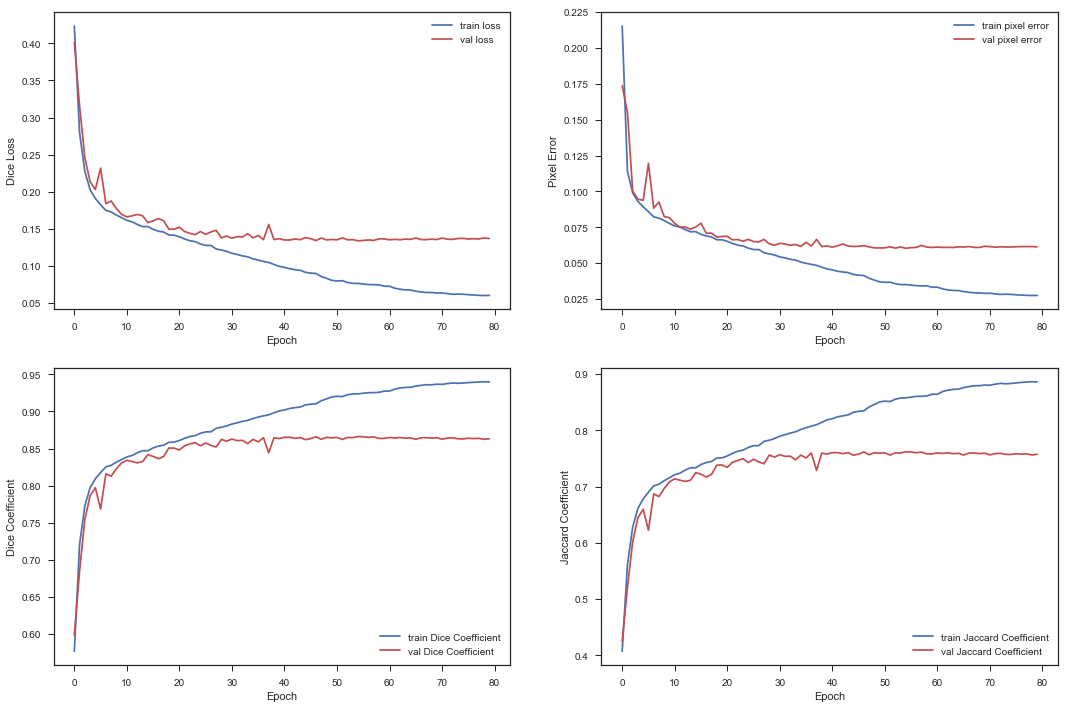

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Dice Loss')
ax[0, 1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[0, 1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Pixel Error')
ax[1, 0].plot(results.epoch, results.history['ofuse_dice_coef'], 'b-', label='train Dice Coefficient')
ax[1, 0].plot(results.epoch, results.history['val_ofuse_dice_coef'], 'r-', label='val Dice Coefficient')
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice Coefficient')
ax[1, 1].plot(results.epoch, results.history['ofuse_jaccard_coef'], 'b-', label='train Jaccard Coefficient')
ax[1, 1].plot(results.epoch, results.history['val_ofuse_jaccard_coef'], 'r-', label='val Jaccard Coefficient')
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Jaccard Coefficient')
plt.show()

In [15]:
np.save(RESULT_PATH + 'history_Unet_fuse_v7.npy', results.history)

In [16]:
model_unet_fuse_v7.save_weights(WEIGHT_PATH + 'UNET_fuse_v7_weight.h5')
model_unet_fuse_v7.save(MODEL_PATH + 'UNET_fuse_v7_model.h5')
model_json = model_unet_fuse_v7.to_json()
with open(MODEL_PATH + 'UNET_fuse_v7_model.json', "w") as json_file:
    json_file.write(model_json)

In [17]:
model_unet_fuse_v7 = u_net_fuse_v7(input_shape=(512, 512, 1))
model_unet_fuse_v7.load_weights(WEIGHT_PATH + 'UNET_fuse_v7_weight.h5')

In [18]:
y_pred = model_unet_fuse_v7.predict(X_test, batch_size=5)
result_fuse = (1 - y_pred[-1]).astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

In [19]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v7_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v7_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

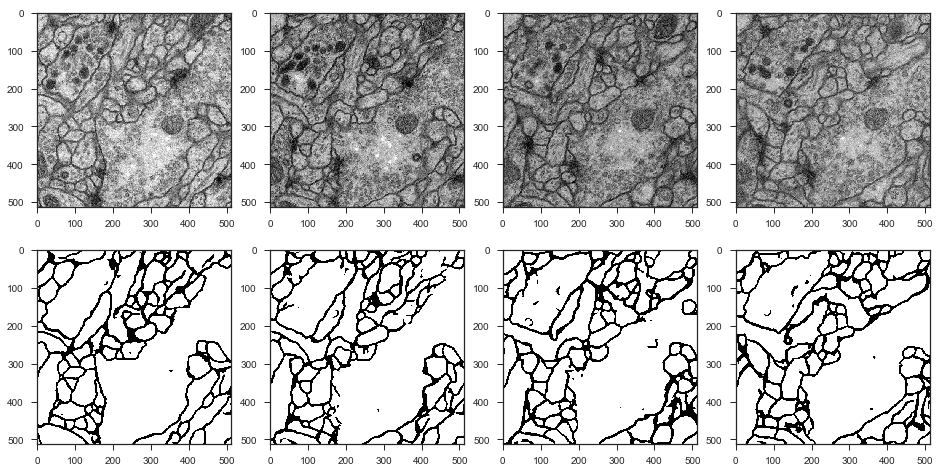

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='gray')

plt.show()

Rand 

In [10]:
model_unet_fuse_v7_rand = u_net_fuse_v7(input_shape=(512, 512, 1))
model_unet_fuse_v7_rand.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 512, 512, 32) 320         lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 512, 512, 32) 128         conv2d_51[0][0]                  
__________________________________________________________________________________________________
activation

In [11]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.6, patience=5, verbose=1, 
                             min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v7_rand', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v7_rand.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error, 
                                             pixel_error_2]},
                          optimizer=optimizer)

results = model_unet_fuse_v7_rand.fit(X_train, [y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=6, epochs=80, callbacks=callback_list, verbose=2)

Train on 270 samples, validate on 30 samples


Epoch 1/80


 - 63s - loss: 2.8970 - o1_loss: 0.6234 - o2_loss: 0.6302 - o3_loss: 0.4722 - o4_loss: 0.4579 - ofuse_loss: 0.7133 - ofuse_dice_coef: 0.2867 - ofuse_jaccard_coef: 0.1674 - ofuse_pixel_error: 0.6657 - ofuse_pixel_error_2: 0.7133 - val_loss: 3.3904 - val_o1_loss: 0.7094 - val_o2_loss: 0.6604 - val_o3_loss: 0.6734 - val_o4_loss: 0.7041 - val_ofuse_loss: 0.6431 - val_ofuse_dice_coef: 0.3569 - val_ofuse_jaccard_coef: 0.2153 - val_ofuse_pixel_error: 0.3466 - val_ofuse_pixel_error_2: 0.6431



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.34656, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/80


 - 37s - loss: 2.0510 - o1_loss: 0.4472 - o2_loss: 0.4429 - o3_loss: 0.3149 - o4_loss: 0.3025 - ofuse_loss: 0.5435 - ofuse_dice_coef: 0.4565 - ofuse_jaccard_coef: 0.2976 - ofuse_pixel_error: 0.4276 - ofuse_pixel_error_2: 0.5435 - val_loss: 3.4905 - val_o1_loss: 0.6221 - val_o2_loss: 0.6846 - val_o3_loss: 0.7496 - val_o4_loss: 0.7462 - val_ofuse_loss: 0.6880 - val_ofuse_dice_coef: 0.3120 - val_ofuse_jaccard_coef: 0.1656 - val_ofuse_pixel_error: 0.2355 - val_ofuse_pixel_error_2: 0.6880



Epoch 00002: val_ofuse_pixel_error improved from 0.34656 to 0.23545, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/80


 - 37s - loss: 1.4408 - o1_loss: 0.3452 - o2_loss: 0.2868 - o3_loss: 0.2336 - o4_loss: 0.2469 - ofuse_loss: 0.3283 - ofuse_dice_coef: 0.6717 - ofuse_jaccard_coef: 0.5063 - ofuse_pixel_error: 0.1499 - ofuse_pixel_error_2: 0.3283 - val_loss: 1.4620 - val_o1_loss: 0.3276 - val_o2_loss: 0.2889 - val_o3_loss: 0.2519 - val_o4_loss: 0.2217 - val_ofuse_loss: 0.3719 - val_ofuse_dice_coef: 0.6281 - val_ofuse_jaccard_coef: 0.4566 - val_ofuse_pixel_error: 0.1581 - val_ofuse_pixel_error_2: 0.3719



Epoch 00003: val_ofuse_pixel_error improved from 0.23545 to 0.15806, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/80


 - 37s - loss: 1.2083 - o1_loss: 0.2985 - o2_loss: 0.2430 - o3_loss: 0.2089 - o4_loss: 0.2166 - ofuse_loss: 0.2413 - ofuse_dice_coef: 0.7587 - ofuse_jaccard_coef: 0.6103 - ofuse_pixel_error: 0.1108 - ofuse_pixel_error_2: 0.2413 - val_loss: 1.3719 - val_o1_loss: 0.3129 - val_o2_loss: 0.2696 - val_o3_loss: 0.2578 - val_o4_loss: 0.2339 - val_ofuse_loss: 0.2976 - val_ofuse_dice_coef: 0.7024 - val_ofuse_jaccard_coef: 0.5405 - val_ofuse_pixel_error: 0.1303 - val_ofuse_pixel_error_2: 0.2976



Epoch 00004: val_ofuse_pixel_error improved from 0.15806 to 0.13034, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 5/80


 - 37s - loss: 1.0997 - o1_loss: 0.2655 - o2_loss: 0.2255 - o3_loss: 0.1970 - o4_loss: 0.1992 - ofuse_loss: 0.2125 - ofuse_dice_coef: 0.7875 - ofuse_jaccard_coef: 0.6483 - ofuse_pixel_error: 0.0981 - ofuse_pixel_error_2: 0.2125 - val_loss: 1.2937 - val_o1_loss: 0.2603 - val_o2_loss: 0.2463 - val_o3_loss: 0.2925 - val_o4_loss: 0.2301 - val_ofuse_loss: 0.2645 - val_ofuse_dice_coef: 0.7355 - val_ofuse_jaccard_coef: 0.5808 - val_ofuse_pixel_error: 0.1194 - val_ofuse_pixel_error_2: 0.2645



Epoch 00005: val_ofuse_pixel_error improved from 0.13034 to 0.11943, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/80


 - 37s - loss: 1.0204 - o1_loss: 0.2392 - o2_loss: 0.2109 - o3_loss: 0.1873 - o4_loss: 0.1873 - ofuse_loss: 0.1956 - ofuse_dice_coef: 0.8044 - ofuse_jaccard_coef: 0.6715 - ofuse_pixel_error: 0.0909 - ofuse_pixel_error_2: 0.1956 - val_loss: 1.0206 - val_o1_loss: 0.2320 - val_o2_loss: 0.2072 - val_o3_loss: 0.1944 - val_o4_loss: 0.1855 - val_ofuse_loss: 0.2014 - val_ofuse_dice_coef: 0.7986 - val_ofuse_jaccard_coef: 0.6632 - val_ofuse_pixel_error: 0.0914 - val_ofuse_pixel_error_2: 0.2014



Epoch 00006: val_ofuse_pixel_error improved from 0.11943 to 0.09136, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 7/80


 - 37s - loss: 0.9729 - o1_loss: 0.2226 - o2_loss: 0.2011 - o3_loss: 0.1816 - o4_loss: 0.1809 - ofuse_loss: 0.1868 - ofuse_dice_coef: 0.8132 - ofuse_jaccard_coef: 0.6842 - ofuse_pixel_error: 0.0871 - ofuse_pixel_error_2: 0.1868 - val_loss: 1.1669 - val_o1_loss: 0.2669 - val_o2_loss: 0.2468 - val_o3_loss: 0.2157 - val_o4_loss: 0.2118 - val_ofuse_loss: 0.2258 - val_ofuse_dice_coef: 0.7742 - val_ofuse_jaccard_coef: 0.6292 - val_ofuse_pixel_error: 0.0897 - val_ofuse_pixel_error_2: 0.2258



Epoch 00007: val_ofuse_pixel_error improved from 0.09136 to 0.08968, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 8/80


 - 37s - loss: 0.9428 - o1_loss: 0.2129 - o2_loss: 0.1941 - o3_loss: 0.1779 - o4_loss: 0.1768 - ofuse_loss: 0.1810 - ofuse_dice_coef: 0.8190 - ofuse_jaccard_coef: 0.6923 - ofuse_pixel_error: 0.0843 - ofuse_pixel_error_2: 0.1810 - val_loss: 0.9974 - val_o1_loss: 0.2233 - val_o2_loss: 0.2025 - val_o3_loss: 0.1889 - val_o4_loss: 0.1877 - val_ofuse_loss: 0.1950 - val_ofuse_dice_coef: 0.8050 - val_ofuse_jaccard_coef: 0.6717 - val_ofuse_pixel_error: 0.0925 - val_ofuse_pixel_error_2: 0.1950



Epoch 00008: val_ofuse_pixel_error did not improve
Epoch 9/80


 - 37s - loss: 0.9181 - o1_loss: 0.2063 - o2_loss: 0.1881 - o3_loss: 0.1742 - o4_loss: 0.1730 - ofuse_loss: 0.1766 - ofuse_dice_coef: 0.8234 - ofuse_jaccard_coef: 0.6986 - ofuse_pixel_error: 0.0827 - ofuse_pixel_error_2: 0.1766 - val_loss: 0.9589 - val_o1_loss: 0.2273 - val_o2_loss: 0.1937 - val_o3_loss: 0.1783 - val_o4_loss: 0.1777 - val_ofuse_loss: 0.1819 - val_ofuse_dice_coef: 0.8181 - val_ofuse_jaccard_coef: 0.6905 - val_ofuse_pixel_error: 0.0802 - val_ofuse_pixel_error_2: 0.1819



Epoch 00009: val_ofuse_pixel_error improved from 0.08968 to 0.08025, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 10/80


 - 37s - loss: 0.8919 - o1_loss: 0.1992 - o2_loss: 0.1819 - o3_loss: 0.1702 - o4_loss: 0.1689 - ofuse_loss: 0.1717 - ofuse_dice_coef: 0.8283 - ofuse_jaccard_coef: 0.7057 - ofuse_pixel_error: 0.0803 - ofuse_pixel_error_2: 0.1717 - val_loss: 0.9812 - val_o1_loss: 0.2141 - val_o2_loss: 0.1966 - val_o3_loss: 0.1914 - val_o4_loss: 0.1894 - val_ofuse_loss: 0.1897 - val_ofuse_dice_coef: 0.8103 - val_ofuse_jaccard_coef: 0.6792 - val_ofuse_pixel_error: 0.0899 - val_ofuse_pixel_error_2: 0.1897



Epoch 00010: val_ofuse_pixel_error did not improve
Epoch 11/80


 - 37s - loss: 0.8674 - o1_loss: 0.1937 - o2_loss: 0.1761 - o3_loss: 0.1659 - o4_loss: 0.1647 - ofuse_loss: 0.1670 - ofuse_dice_coef: 0.8330 - ofuse_jaccard_coef: 0.7128 - ofuse_pixel_error: 0.0780 - ofuse_pixel_error_2: 0.1670 - val_loss: 0.8655 - val_o1_loss: 0.1926 - val_o2_loss: 0.1750 - val_o3_loss: 0.1657 - val_o4_loss: 0.1647 - val_ofuse_loss: 0.1675 - val_ofuse_dice_coef: 0.8325 - val_ofuse_jaccard_coef: 0.7113 - val_ofuse_pixel_error: 0.0763 - val_ofuse_pixel_error_2: 0.1675



Epoch 00011: val_ofuse_pixel_error improved from 0.08025 to 0.07633, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/80


 - 38s - loss: 0.8488 - o1_loss: 0.1900 - o2_loss: 0.1714 - o3_loss: 0.1626 - o4_loss: 0.1615 - ofuse_loss: 0.1633 - ofuse_dice_coef: 0.8367 - ofuse_jaccard_coef: 0.7179 - ofuse_pixel_error: 0.0764 - ofuse_pixel_error_2: 0.1633 - val_loss: 0.8945 - val_o1_loss: 0.2010 - val_o2_loss: 0.1823 - val_o3_loss: 0.1699 - val_o4_loss: 0.1694 - val_ofuse_loss: 0.1719 - val_ofuse_dice_coef: 0.8281 - val_ofuse_jaccard_coef: 0.7054 - val_ofuse_pixel_error: 0.0748 - val_ofuse_pixel_error_2: 0.1719



Epoch 00012: val_ofuse_pixel_error improved from 0.07633 to 0.07477, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 13/80


 - 38s - loss: 0.8331 - o1_loss: 0.1863 - o2_loss: 0.1676 - o3_loss: 0.1598 - o4_loss: 0.1590 - ofuse_loss: 0.1604 - ofuse_dice_coef: 0.8396 - ofuse_jaccard_coef: 0.7226 - ofuse_pixel_error: 0.0751 - ofuse_pixel_error_2: 0.1604 - val_loss: 0.8668 - val_o1_loss: 0.1929 - val_o2_loss: 0.1744 - val_o3_loss: 0.1668 - val_o4_loss: 0.1653 - val_ofuse_loss: 0.1674 - val_ofuse_dice_coef: 0.8326 - val_ofuse_jaccard_coef: 0.7120 - val_ofuse_pixel_error: 0.0739 - val_ofuse_pixel_error_2: 0.1674



Epoch 00013: val_ofuse_pixel_error improved from 0.07477 to 0.07387, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 14/80


 - 39s - loss: 0.8103 - o1_loss: 0.1820 - o2_loss: 0.1623 - o3_loss: 0.1554 - o4_loss: 0.1547 - ofuse_loss: 0.1559 - ofuse_dice_coef: 0.8441 - ofuse_jaccard_coef: 0.7293 - ofuse_pixel_error: 0.0728 - ofuse_pixel_error_2: 0.1559 - val_loss: 0.8910 - val_o1_loss: 0.2037 - val_o2_loss: 0.1799 - val_o3_loss: 0.1690 - val_o4_loss: 0.1679 - val_ofuse_loss: 0.1704 - val_ofuse_dice_coef: 0.8296 - val_ofuse_jaccard_coef: 0.7074 - val_ofuse_pixel_error: 0.0731 - val_ofuse_pixel_error_2: 0.1704



Epoch 00014: val_ofuse_pixel_error improved from 0.07387 to 0.07312, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 15/80


 - 38s - loss: 0.8156 - o1_loss: 0.1823 - o2_loss: 0.1628 - o3_loss: 0.1569 - o4_loss: 0.1563 - ofuse_loss: 0.1573 - ofuse_dice_coef: 0.8427 - ofuse_jaccard_coef: 0.7271 - ofuse_pixel_error: 0.0735 - ofuse_pixel_error_2: 0.1573 - val_loss: 0.8334 - val_o1_loss: 0.1846 - val_o2_loss: 0.1660 - val_o3_loss: 0.1612 - val_o4_loss: 0.1606 - val_ofuse_loss: 0.1609 - val_ofuse_dice_coef: 0.8391 - val_ofuse_jaccard_coef: 0.7215 - val_ofuse_pixel_error: 0.0749 - val_ofuse_pixel_error_2: 0.1609



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/80


 - 38s - loss: 0.7960 - o1_loss: 0.1788 - o2_loss: 0.1583 - o3_loss: 0.1529 - o4_loss: 0.1526 - ofuse_loss: 0.1534 - ofuse_dice_coef: 0.8466 - ofuse_jaccard_coef: 0.7331 - ofuse_pixel_error: 0.0717 - ofuse_pixel_error_2: 0.1534 - val_loss: 0.8528 - val_o1_loss: 0.1897 - val_o2_loss: 0.1700 - val_o3_loss: 0.1644 - val_o4_loss: 0.1639 - val_ofuse_loss: 0.1649 - val_ofuse_dice_coef: 0.8351 - val_ofuse_jaccard_coef: 0.7157 - val_ofuse_pixel_error: 0.0726 - val_ofuse_pixel_error_2: 0.1649



Epoch 00016: val_ofuse_pixel_error improved from 0.07312 to 0.07262, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 17/80


 - 39s - loss: 0.7742 - o1_loss: 0.1746 - o2_loss: 0.1534 - o3_loss: 0.1486 - o4_loss: 0.1484 - ofuse_loss: 0.1492 - ofuse_dice_coef: 0.8508 - ofuse_jaccard_coef: 0.7393 - ofuse_pixel_error: 0.0696 - ofuse_pixel_error_2: 0.1492 - val_loss: 0.8912 - val_o1_loss: 0.1918 - val_o2_loss: 0.1786 - val_o3_loss: 0.1749 - val_o4_loss: 0.1730 - val_ofuse_loss: 0.1729 - val_ofuse_dice_coef: 0.8271 - val_ofuse_jaccard_coef: 0.7039 - val_ofuse_pixel_error: 0.0726 - val_ofuse_pixel_error_2: 0.1729



Epoch 00017: val_ofuse_pixel_error improved from 0.07262 to 0.07258, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 18/80


 - 36s - loss: 0.7636 - o1_loss: 0.1726 - o2_loss: 0.1510 - o3_loss: 0.1465 - o4_loss: 0.1464 - ofuse_loss: 0.1471 - ofuse_dice_coef: 0.8529 - ofuse_jaccard_coef: 0.7425 - ofuse_pixel_error: 0.0684 - ofuse_pixel_error_2: 0.1471 - val_loss: 0.8279 - val_o1_loss: 0.1839 - val_o2_loss: 0.1668 - val_o3_loss: 0.1582 - val_o4_loss: 0.1582 - val_ofuse_loss: 0.1608 - val_ofuse_dice_coef: 0.8392 - val_ofuse_jaccard_coef: 0.7214 - val_ofuse_pixel_error: 0.0702 - val_ofuse_pixel_error_2: 0.1608



Epoch 00018: val_ofuse_pixel_error improved from 0.07258 to 0.07017, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 19/80


 - 37s - loss: 0.7517 - o1_loss: 0.1702 - o2_loss: 0.1483 - o3_loss: 0.1442 - o4_loss: 0.1442 - ofuse_loss: 0.1449 - ofuse_dice_coef: 0.8551 - ofuse_jaccard_coef: 0.7458 - ofuse_pixel_error: 0.0675 - ofuse_pixel_error_2: 0.1449 - val_loss: 0.7876 - val_o1_loss: 0.1763 - val_o2_loss: 0.1548 - val_o3_loss: 0.1519 - val_o4_loss: 0.1526 - val_ofuse_loss: 0.1519 - val_ofuse_dice_coef: 0.8481 - val_ofuse_jaccard_coef: 0.7349 - val_ofuse_pixel_error: 0.0702 - val_ofuse_pixel_error_2: 0.1519



Epoch 00019: val_ofuse_pixel_error improved from 0.07017 to 0.07017, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 20/80


 - 37s - loss: 0.7405 - o1_loss: 0.1682 - o2_loss: 0.1458 - o3_loss: 0.1419 - o4_loss: 0.1420 - ofuse_loss: 0.1426 - ofuse_dice_coef: 0.8574 - ofuse_jaccard_coef: 0.7492 - ofuse_pixel_error: 0.0665 - ofuse_pixel_error_2: 0.1426 - val_loss: 0.7789 - val_o1_loss: 0.1747 - val_o2_loss: 0.1545 - val_o3_loss: 0.1495 - val_o4_loss: 0.1497 - val_ofuse_loss: 0.1504 - val_ofuse_dice_coef: 0.8496 - val_ofuse_jaccard_coef: 0.7370 - val_ofuse_pixel_error: 0.0678 - val_ofuse_pixel_error_2: 0.1504



Epoch 00020: val_ofuse_pixel_error improved from 0.07017 to 0.06779, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 21/80


 - 37s - loss: 0.7250 - o1_loss: 0.1652 - o2_loss: 0.1425 - o3_loss: 0.1389 - o4_loss: 0.1388 - ofuse_loss: 0.1396 - ofuse_dice_coef: 0.8604 - ofuse_jaccard_coef: 0.7541 - ofuse_pixel_error: 0.0649 - ofuse_pixel_error_2: 0.1396 - val_loss: 0.7670 - val_o1_loss: 0.1717 - val_o2_loss: 0.1510 - val_o3_loss: 0.1479 - val_o4_loss: 0.1484 - val_ofuse_loss: 0.1480 - val_ofuse_dice_coef: 0.8520 - val_ofuse_jaccard_coef: 0.7408 - val_ofuse_pixel_error: 0.0665 - val_ofuse_pixel_error_2: 0.1480



Epoch 00021: val_ofuse_pixel_error improved from 0.06779 to 0.06653, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 22/80


 - 37s - loss: 0.7159 - o1_loss: 0.1635 - o2_loss: 0.1408 - o3_loss: 0.1369 - o4_loss: 0.1368 - ofuse_loss: 0.1378 - ofuse_dice_coef: 0.8622 - ofuse_jaccard_coef: 0.7569 - ofuse_pixel_error: 0.0640 - ofuse_pixel_error_2: 0.1378 - val_loss: 0.7708 - val_o1_loss: 0.1697 - val_o2_loss: 0.1507 - val_o3_loss: 0.1501 - val_o4_loss: 0.1510 - val_ofuse_loss: 0.1492 - val_ofuse_dice_coef: 0.8508 - val_ofuse_jaccard_coef: 0.7390 - val_ofuse_pixel_error: 0.0709 - val_ofuse_pixel_error_2: 0.1492



Epoch 00022: val_ofuse_pixel_error did not improve
Epoch 23/80


 - 37s - loss: 0.7065 - o1_loss: 0.1618 - o2_loss: 0.1388 - o3_loss: 0.1351 - o4_loss: 0.1348 - ofuse_loss: 0.1361 - ofuse_dice_coef: 0.8639 - ofuse_jaccard_coef: 0.7594 - ofuse_pixel_error: 0.0634 - ofuse_pixel_error_2: 0.1361 - val_loss: 0.7919 - val_o1_loss: 0.1768 - val_o2_loss: 0.1561 - val_o3_loss: 0.1529 - val_o4_loss: 0.1533 - val_ofuse_loss: 0.1527 - val_ofuse_dice_coef: 0.8473 - val_ofuse_jaccard_coef: 0.7339 - val_ofuse_pixel_error: 0.0669 - val_ofuse_pixel_error_2: 0.1527



Epoch 00023: val_ofuse_pixel_error did not improve
Epoch 24/80


 - 37s - loss: 0.6945 - o1_loss: 0.1595 - o2_loss: 0.1363 - o3_loss: 0.1327 - o4_loss: 0.1323 - ofuse_loss: 0.1336 - ofuse_dice_coef: 0.8664 - ofuse_jaccard_coef: 0.7632 - ofuse_pixel_error: 0.0621 - ofuse_pixel_error_2: 0.1336 - val_loss: 0.7666 - val_o1_loss: 0.1696 - val_o2_loss: 0.1521 - val_o3_loss: 0.1487 - val_o4_loss: 0.1483 - val_ofuse_loss: 0.1480 - val_ofuse_dice_coef: 0.8520 - val_ofuse_jaccard_coef: 0.7408 - val_ofuse_pixel_error: 0.0654 - val_ofuse_pixel_error_2: 0.1480



Epoch 00024: val_ofuse_pixel_error improved from 0.06653 to 0.06535, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 25/80


 - 37s - loss: 0.6829 - o1_loss: 0.1572 - o2_loss: 0.1340 - o3_loss: 0.1303 - o4_loss: 0.1301 - ofuse_loss: 0.1313 - ofuse_dice_coef: 0.8687 - ofuse_jaccard_coef: 0.7667 - ofuse_pixel_error: 0.0610 - ofuse_pixel_error_2: 0.1313 - val_loss: 0.7665 - val_o1_loss: 0.1713 - val_o2_loss: 0.1512 - val_o3_loss: 0.1480 - val_o4_loss: 0.1479 - val_ofuse_loss: 0.1480 - val_ofuse_dice_coef: 0.8520 - val_ofuse_jaccard_coef: 0.7409 - val_ofuse_pixel_error: 0.0668 - val_ofuse_pixel_error_2: 0.1480



Epoch 00025: val_ofuse_pixel_error did not improve
Epoch 26/80


 - 37s - loss: 0.6825 - o1_loss: 0.1571 - o2_loss: 0.1339 - o3_loss: 0.1303 - o4_loss: 0.1300 - ofuse_loss: 0.1312 - ofuse_dice_coef: 0.8688 - ofuse_jaccard_coef: 0.7671 - ofuse_pixel_error: 0.0610 - ofuse_pixel_error_2: 0.1312 - val_loss: 0.7411 - val_o1_loss: 0.1668 - val_o2_loss: 0.1458 - val_o3_loss: 0.1425 - val_o4_loss: 0.1427 - val_ofuse_loss: 0.1433 - val_ofuse_dice_coef: 0.8567 - val_ofuse_jaccard_coef: 0.7477 - val_ofuse_pixel_error: 0.0659 - val_ofuse_pixel_error_2: 0.1433



Epoch 00026: val_ofuse_pixel_error did not improve
Epoch 27/80


 - 37s - loss: 0.6623 - o1_loss: 0.1535 - o2_loss: 0.1298 - o3_loss: 0.1261 - o4_loss: 0.1259 - ofuse_loss: 0.1271 - ofuse_dice_coef: 0.8729 - ofuse_jaccard_coef: 0.7735 - ofuse_pixel_error: 0.0589 - ofuse_pixel_error_2: 0.1271 - val_loss: 0.7430 - val_o1_loss: 0.1667 - val_o2_loss: 0.1463 - val_o3_loss: 0.1432 - val_o4_loss: 0.1429 - val_ofuse_loss: 0.1439 - val_ofuse_dice_coef: 0.8561 - val_ofuse_jaccard_coef: 0.7470 - val_ofuse_pixel_error: 0.0657 - val_ofuse_pixel_error_2: 0.1439



Epoch 00027: val_ofuse_pixel_error did not improve
Epoch 28/80


 - 37s - loss: 0.6579 - o1_loss: 0.1526 - o2_loss: 0.1288 - o3_loss: 0.1253 - o4_loss: 0.1251 - ofuse_loss: 0.1262 - ofuse_dice_coef: 0.8738 - ofuse_jaccard_coef: 0.7749 - ofuse_pixel_error: 0.0585 - ofuse_pixel_error_2: 0.1262 - val_loss: 0.7570 - val_o1_loss: 0.1674 - val_o2_loss: 0.1500 - val_o3_loss: 0.1467 - val_o4_loss: 0.1469 - val_ofuse_loss: 0.1461 - val_ofuse_dice_coef: 0.8539 - val_ofuse_jaccard_coef: 0.7436 - val_ofuse_pixel_error: 0.0652 - val_ofuse_pixel_error_2: 0.1461



Epoch 00028: val_ofuse_pixel_error improved from 0.06535 to 0.06515, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 29/80


 - 36s - loss: 0.6432 - o1_loss: 0.1502 - o2_loss: 0.1260 - o3_loss: 0.1221 - o4_loss: 0.1219 - ofuse_loss: 0.1231 - ofuse_dice_coef: 0.8769 - ofuse_jaccard_coef: 0.7799 - ofuse_pixel_error: 0.0570 - ofuse_pixel_error_2: 0.1231 - val_loss: 0.7557 - val_o1_loss: 0.1703 - val_o2_loss: 0.1492 - val_o3_loss: 0.1453 - val_o4_loss: 0.1449 - val_ofuse_loss: 0.1460 - val_ofuse_dice_coef: 0.8540 - val_ofuse_jaccard_coef: 0.7435 - val_ofuse_pixel_error: 0.0645 - val_ofuse_pixel_error_2: 0.1460



Epoch 00029: val_ofuse_pixel_error improved from 0.06515 to 0.06453, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 30/80


 - 36s - loss: 0.6255 - o1_loss: 0.1470 - o2_loss: 0.1223 - o3_loss: 0.1185 - o4_loss: 0.1183 - ofuse_loss: 0.1195 - ofuse_dice_coef: 0.8805 - ofuse_jaccard_coef: 0.7857 - ofuse_pixel_error: 0.0553 - ofuse_pixel_error_2: 0.1195 - val_loss: 0.7342 - val_o1_loss: 0.1641 - val_o2_loss: 0.1446 - val_o3_loss: 0.1417 - val_o4_loss: 0.1415 - val_ofuse_loss: 0.1423 - val_ofuse_dice_coef: 0.8577 - val_ofuse_jaccard_coef: 0.7493 - val_ofuse_pixel_error: 0.0643 - val_ofuse_pixel_error_2: 0.1423



Epoch 00030: val_ofuse_pixel_error improved from 0.06453 to 0.06429, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 31/80


 - 36s - loss: 0.6222 - o1_loss: 0.1462 - o2_loss: 0.1216 - o3_loss: 0.1180 - o4_loss: 0.1177 - ofuse_loss: 0.1188 - ofuse_dice_coef: 0.8812 - ofuse_jaccard_coef: 0.7867 - ofuse_pixel_error: 0.0550 - ofuse_pixel_error_2: 0.1188 - val_loss: 0.7344 - val_o1_loss: 0.1641 - val_o2_loss: 0.1437 - val_o3_loss: 0.1425 - val_o4_loss: 0.1420 - val_ofuse_loss: 0.1421 - val_ofuse_dice_coef: 0.8579 - val_ofuse_jaccard_coef: 0.7497 - val_ofuse_pixel_error: 0.0664 - val_ofuse_pixel_error_2: 0.1421



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/80


 - 36s - loss: 0.6115 - o1_loss: 0.1443 - o2_loss: 0.1194 - o3_loss: 0.1158 - o4_loss: 0.1155 - ofuse_loss: 0.1166 - ofuse_dice_coef: 0.8834 - ofuse_jaccard_coef: 0.7901 - ofuse_pixel_error: 0.0539 - ofuse_pixel_error_2: 0.1166 - val_loss: 0.7783 - val_o1_loss: 0.1701 - val_o2_loss: 0.1544 - val_o3_loss: 0.1520 - val_o4_loss: 0.1507 - val_ofuse_loss: 0.1511 - val_ofuse_dice_coef: 0.8489 - val_ofuse_jaccard_coef: 0.7361 - val_ofuse_pixel_error: 0.0675 - val_ofuse_pixel_error_2: 0.1511



Epoch 00032: val_ofuse_pixel_error did not improve
Epoch 33/80


 - 36s - loss: 0.6002 - o1_loss: 0.1419 - o2_loss: 0.1172 - o3_loss: 0.1135 - o4_loss: 0.1133 - ofuse_loss: 0.1143 - ofuse_dice_coef: 0.8857 - ofuse_jaccard_coef: 0.7940 - ofuse_pixel_error: 0.0527 - ofuse_pixel_error_2: 0.1143 - val_loss: 0.7411 - val_o1_loss: 0.1657 - val_o2_loss: 0.1471 - val_o3_loss: 0.1427 - val_o4_loss: 0.1425 - val_ofuse_loss: 0.1432 - val_ofuse_dice_coef: 0.8568 - val_ofuse_jaccard_coef: 0.7481 - val_ofuse_pixel_error: 0.0637 - val_ofuse_pixel_error_2: 0.1432



Epoch 00033: val_ofuse_pixel_error improved from 0.06429 to 0.06366, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 34/80


 - 35s - loss: 0.5946 - o1_loss: 0.1411 - o2_loss: 0.1159 - o3_loss: 0.1124 - o4_loss: 0.1122 - ofuse_loss: 0.1130 - ofuse_dice_coef: 0.8870 - ofuse_jaccard_coef: 0.7960 - ofuse_pixel_error: 0.0522 - ofuse_pixel_error_2: 0.1130 - val_loss: 0.7255 - val_o1_loss: 0.1634 - val_o2_loss: 0.1424 - val_o3_loss: 0.1402 - val_o4_loss: 0.1393 - val_ofuse_loss: 0.1402 - val_ofuse_dice_coef: 0.8598 - val_ofuse_jaccard_coef: 0.7524 - val_ofuse_pixel_error: 0.0628 - val_ofuse_pixel_error_2: 0.1402



Epoch 00034: val_ofuse_pixel_error improved from 0.06366 to 0.06279, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 35/80


 - 36s - loss: 0.5818 - o1_loss: 0.1390 - o2_loss: 0.1134 - o3_loss: 0.1097 - o4_loss: 0.1094 - ofuse_loss: 0.1104 - ofuse_dice_coef: 0.8896 - ofuse_jaccard_coef: 0.8004 - ofuse_pixel_error: 0.0510 - ofuse_pixel_error_2: 0.1104 - val_loss: 0.7163 - val_o1_loss: 0.1615 - val_o2_loss: 0.1408 - val_o3_loss: 0.1379 - val_o4_loss: 0.1376 - val_ofuse_loss: 0.1384 - val_ofuse_dice_coef: 0.8616 - val_ofuse_jaccard_coef: 0.7554 - val_ofuse_pixel_error: 0.0639 - val_ofuse_pixel_error_2: 0.1384



Epoch 00035: val_ofuse_pixel_error did not improve
Epoch 36/80


 - 36s - loss: 0.5732 - o1_loss: 0.1373 - o2_loss: 0.1116 - o3_loss: 0.1079 - o4_loss: 0.1077 - ofuse_loss: 0.1087 - ofuse_dice_coef: 0.8913 - ofuse_jaccard_coef: 0.8030 - ofuse_pixel_error: 0.0502 - ofuse_pixel_error_2: 0.1087 - val_loss: 0.7332 - val_o1_loss: 0.1635 - val_o2_loss: 0.1437 - val_o3_loss: 0.1420 - val_o4_loss: 0.1418 - val_ofuse_loss: 0.1421 - val_ofuse_dice_coef: 0.8579 - val_ofuse_jaccard_coef: 0.7497 - val_ofuse_pixel_error: 0.0656 - val_ofuse_pixel_error_2: 0.1421



Epoch 00036: val_ofuse_pixel_error did not improve
Epoch 37/80


 - 35s - loss: 0.5643 - o1_loss: 0.1356 - o2_loss: 0.1098 - o3_loss: 0.1062 - o4_loss: 0.1059 - ofuse_loss: 0.1068 - ofuse_dice_coef: 0.8932 - ofuse_jaccard_coef: 0.8060 - ofuse_pixel_error: 0.0493 - ofuse_pixel_error_2: 0.1068 - val_loss: 0.7157 - val_o1_loss: 0.1609 - val_o2_loss: 0.1398 - val_o3_loss: 0.1383 - val_o4_loss: 0.1383 - val_ofuse_loss: 0.1383 - val_ofuse_dice_coef: 0.8617 - val_ofuse_jaccard_coef: 0.7555 - val_ofuse_pixel_error: 0.0650 - val_ofuse_pixel_error_2: 0.1383



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/80


 - 35s - loss: 0.5550 - o1_loss: 0.1341 - o2_loss: 0.1078 - o3_loss: 0.1042 - o4_loss: 0.1040 - ofuse_loss: 0.1049 - ofuse_dice_coef: 0.8951 - ofuse_jaccard_coef: 0.8094 - ofuse_pixel_error: 0.0484 - ofuse_pixel_error_2: 0.1049 - val_loss: 0.7424 - val_o1_loss: 0.1677 - val_o2_loss: 0.1474 - val_o3_loss: 0.1423 - val_o4_loss: 0.1417 - val_ofuse_loss: 0.1433 - val_ofuse_dice_coef: 0.8567 - val_ofuse_jaccard_coef: 0.7476 - val_ofuse_pixel_error: 0.0631 - val_ofuse_pixel_error_2: 0.1433



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/80


 - 35s - loss: 0.5474 - o1_loss: 0.1329 - o2_loss: 0.1063 - o3_loss: 0.1026 - o4_loss: 0.1024 - ofuse_loss: 0.1033 - ofuse_dice_coef: 0.8967 - ofuse_jaccard_coef: 0.8121 - ofuse_pixel_error: 0.0476 - ofuse_pixel_error_2: 0.1033 - val_loss: 0.7112 - val_o1_loss: 0.1599 - val_o2_loss: 0.1407 - val_o3_loss: 0.1369 - val_o4_loss: 0.1364 - val_ofuse_loss: 0.1373 - val_ofuse_dice_coef: 0.8627 - val_ofuse_jaccard_coef: 0.7572 - val_ofuse_pixel_error: 0.0625 - val_ofuse_pixel_error_2: 0.1373



Epoch 00039: val_ofuse_pixel_error improved from 0.06279 to 0.06246, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 40/80


 - 35s - loss: 0.5427 - o1_loss: 0.1316 - o2_loss: 0.1053 - o3_loss: 0.1018 - o4_loss: 0.1016 - ofuse_loss: 0.1023 - ofuse_dice_coef: 0.8977 - ofuse_jaccard_coef: 0.8137 - ofuse_pixel_error: 0.0471 - ofuse_pixel_error_2: 0.1023 - val_loss: 0.7077 - val_o1_loss: 0.1592 - val_o2_loss: 0.1394 - val_o3_loss: 0.1363 - val_o4_loss: 0.1360 - val_ofuse_loss: 0.1368 - val_ofuse_dice_coef: 0.8632 - val_ofuse_jaccard_coef: 0.7578 - val_ofuse_pixel_error: 0.0622 - val_ofuse_pixel_error_2: 0.1368



Epoch 00040: val_ofuse_pixel_error improved from 0.06246 to 0.06218, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 41/80


 - 35s - loss: 0.5308 - o1_loss: 0.1297 - o2_loss: 0.1030 - o3_loss: 0.0992 - o4_loss: 0.0990 - ofuse_loss: 0.0999 - ofuse_dice_coef: 0.9001 - ofuse_jaccard_coef: 0.8176 - ofuse_pixel_error: 0.0461 - ofuse_pixel_error_2: 0.0999 - val_loss: 0.7091 - val_o1_loss: 0.1595 - val_o2_loss: 0.1395 - val_o3_loss: 0.1366 - val_o4_loss: 0.1364 - val_ofuse_loss: 0.1372 - val_ofuse_dice_coef: 0.8628 - val_ofuse_jaccard_coef: 0.7572 - val_ofuse_pixel_error: 0.0629 - val_ofuse_pixel_error_2: 0.1372



Epoch 00041: val_ofuse_pixel_error did not improve
Epoch 42/80


 - 85s - loss: 0.5193 - o1_loss: 0.1279 - o2_loss: 0.1006 - o3_loss: 0.0968 - o4_loss: 0.0965 - ofuse_loss: 0.0974 - ofuse_dice_coef: 0.9026 - ofuse_jaccard_coef: 0.8217 - ofuse_pixel_error: 0.0448 - ofuse_pixel_error_2: 0.0974 - val_loss: 0.7098 - val_o1_loss: 0.1600 - val_o2_loss: 0.1402 - val_o3_loss: 0.1363 - val_o4_loss: 0.1361 - val_ofuse_loss: 0.1371 - val_ofuse_dice_coef: 0.8629 - val_ofuse_jaccard_coef: 0.7570 - val_ofuse_pixel_error: 0.0620 - val_ofuse_pixel_error_2: 0.1371



Epoch 00042: val_ofuse_pixel_error improved from 0.06218 to 0.06205, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 43/80


 - 127s - loss: 0.5123 - o1_loss: 0.1264 - o2_loss: 0.0991 - o3_loss: 0.0955 - o4_loss: 0.0952 - ofuse_loss: 0.0960 - ofuse_dice_coef: 0.9040 - ofuse_jaccard_coef: 0.8241 - ofuse_pixel_error: 0.0443 - ofuse_pixel_error_2: 0.0961 - val_loss: 0.7145 - val_o1_loss: 0.1595 - val_o2_loss: 0.1409 - val_o3_loss: 0.1380 - val_o4_loss: 0.1378 - val_ofuse_loss: 0.1384 - val_ofuse_dice_coef: 0.8616 - val_ofuse_jaccard_coef: 0.7554 - val_ofuse_pixel_error: 0.0630 - val_ofuse_pixel_error_2: 0.1384



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/80


 - 90s - loss: 0.5055 - o1_loss: 0.1253 - o2_loss: 0.0977 - o3_loss: 0.0941 - o4_loss: 0.0938 - ofuse_loss: 0.0946 - ofuse_dice_coef: 0.9054 - ofuse_jaccard_coef: 0.8263 - ofuse_pixel_error: 0.0435 - ofuse_pixel_error_2: 0.0946 - val_loss: 0.7242 - val_o1_loss: 0.1592 - val_o2_loss: 0.1430 - val_o3_loss: 0.1413 - val_o4_loss: 0.1407 - val_ofuse_loss: 0.1400 - val_ofuse_dice_coef: 0.8600 - val_ofuse_jaccard_coef: 0.7529 - val_ofuse_pixel_error: 0.0625 - val_ofuse_pixel_error_2: 0.1400



Epoch 00044: val_ofuse_pixel_error did not improve
Epoch 45/80


 - 42s - loss: 0.5007 - o1_loss: 0.1245 - o2_loss: 0.0968 - o3_loss: 0.0930 - o4_loss: 0.0928 - ofuse_loss: 0.0936 - ofuse_dice_coef: 0.9064 - ofuse_jaccard_coef: 0.8282 - ofuse_pixel_error: 0.0431 - ofuse_pixel_error_2: 0.0936 - val_loss: 0.7517 - val_o1_loss: 0.1649 - val_o2_loss: 0.1482 - val_o3_loss: 0.1469 - val_o4_loss: 0.1464 - val_ofuse_loss: 0.1453 - val_ofuse_dice_coef: 0.8547 - val_ofuse_jaccard_coef: 0.7447 - val_ofuse_pixel_error: 0.0636 - val_ofuse_pixel_error_2: 0.1453



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/80


 - 56s - loss: 0.4987 - o1_loss: 0.1240 - o2_loss: 0.0962 - o3_loss: 0.0928 - o4_loss: 0.0925 - ofuse_loss: 0.0931 - ofuse_dice_coef: 0.9069 - ofuse_jaccard_coef: 0.8288 - ofuse_pixel_error: 0.0428 - ofuse_pixel_error_2: 0.0931 - val_loss: 0.7082 - val_o1_loss: 0.1579 - val_o2_loss: 0.1393 - val_o3_loss: 0.1375 - val_o4_loss: 0.1367 - val_ofuse_loss: 0.1368 - val_ofuse_dice_coef: 0.8632 - val_ofuse_jaccard_coef: 0.7580 - val_ofuse_pixel_error: 0.0619 - val_ofuse_pixel_error_2: 0.1368



Epoch 00046: val_ofuse_pixel_error improved from 0.06205 to 0.06192, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 47/80


 - 37s - loss: 0.4849 - o1_loss: 0.1217 - o2_loss: 0.0934 - o3_loss: 0.0899 - o4_loss: 0.0896 - ofuse_loss: 0.0903 - ofuse_dice_coef: 0.9097 - ofuse_jaccard_coef: 0.8336 - ofuse_pixel_error: 0.0415 - ofuse_pixel_error_2: 0.0903 - val_loss: 0.7013 - val_o1_loss: 0.1574 - val_o2_loss: 0.1380 - val_o3_loss: 0.1353 - val_o4_loss: 0.1350 - val_ofuse_loss: 0.1357 - val_ofuse_dice_coef: 0.8643 - val_ofuse_jaccard_coef: 0.7595 - val_ofuse_pixel_error: 0.0624 - val_ofuse_pixel_error_2: 0.1357



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/80


 - 37s - loss: 0.4811 - o1_loss: 0.1210 - o2_loss: 0.0927 - o3_loss: 0.0890 - o4_loss: 0.0888 - ofuse_loss: 0.0895 - ofuse_dice_coef: 0.9105 - ofuse_jaccard_coef: 0.8350 - ofuse_pixel_error: 0.0411 - ofuse_pixel_error_2: 0.0895 - val_loss: 0.7159 - val_o1_loss: 0.1595 - val_o2_loss: 0.1410 - val_o3_loss: 0.1387 - val_o4_loss: 0.1383 - val_ofuse_loss: 0.1385 - val_ofuse_dice_coef: 0.8615 - val_ofuse_jaccard_coef: 0.7551 - val_ofuse_pixel_error: 0.0631 - val_ofuse_pixel_error_2: 0.1385



Epoch 00048: val_ofuse_pixel_error did not improve
Epoch 49/80


 - 37s - loss: 0.4749 - o1_loss: 0.1201 - o2_loss: 0.0914 - o3_loss: 0.0878 - o4_loss: 0.0875 - ofuse_loss: 0.0882 - ofuse_dice_coef: 0.9118 - ofuse_jaccard_coef: 0.8372 - ofuse_pixel_error: 0.0405 - ofuse_pixel_error_2: 0.0882 - val_loss: 0.7333 - val_o1_loss: 0.1645 - val_o2_loss: 0.1462 - val_o3_loss: 0.1406 - val_o4_loss: 0.1402 - val_ofuse_loss: 0.1417 - val_ofuse_dice_coef: 0.8583 - val_ofuse_jaccard_coef: 0.7501 - val_ofuse_pixel_error: 0.0634 - val_ofuse_pixel_error_2: 0.1417



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/80


 - 38s - loss: 0.4648 - o1_loss: 0.1183 - o2_loss: 0.0894 - o3_loss: 0.0856 - o4_loss: 0.0854 - ofuse_loss: 0.0861 - ofuse_dice_coef: 0.9139 - ofuse_jaccard_coef: 0.8409 - ofuse_pixel_error: 0.0395 - ofuse_pixel_error_2: 0.0861 - val_loss: 0.7058 - val_o1_loss: 0.1580 - val_o2_loss: 0.1391 - val_o3_loss: 0.1362 - val_o4_loss: 0.1361 - val_ofuse_loss: 0.1363 - val_ofuse_dice_coef: 0.8637 - val_ofuse_jaccard_coef: 0.7583 - val_ofuse_pixel_error: 0.0616 - val_ofuse_pixel_error_2: 0.1363



Epoch 00050: val_ofuse_pixel_error improved from 0.06192 to 0.06160, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 51/80


 - 37s - loss: 0.4616 - o1_loss: 0.1178 - o2_loss: 0.0888 - o3_loss: 0.0850 - o4_loss: 0.0847 - ofuse_loss: 0.0854 - ofuse_dice_coef: 0.9146 - ofuse_jaccard_coef: 0.8422 - ofuse_pixel_error: 0.0392 - ofuse_pixel_error_2: 0.0854 - val_loss: 0.7331 - val_o1_loss: 0.1631 - val_o2_loss: 0.1440 - val_o3_loss: 0.1425 - val_o4_loss: 0.1420 - val_ofuse_loss: 0.1414 - val_ofuse_dice_coef: 0.8586 - val_ofuse_jaccard_coef: 0.7506 - val_ofuse_pixel_error: 0.0617 - val_ofuse_pixel_error_2: 0.1414



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/80


 - 37s - loss: 0.4575 - o1_loss: 0.1171 - o2_loss: 0.0877 - o3_loss: 0.0842 - o4_loss: 0.0840 - ofuse_loss: 0.0845 - ofuse_dice_coef: 0.9155 - ofuse_jaccard_coef: 0.8435 - ofuse_pixel_error: 0.0387 - ofuse_pixel_error_2: 0.0845 - val_loss: 0.7024 - val_o1_loss: 0.1566 - val_o2_loss: 0.1382 - val_o3_loss: 0.1359 - val_o4_loss: 0.1357 - val_ofuse_loss: 0.1360 - val_ofuse_dice_coef: 0.8640 - val_ofuse_jaccard_coef: 0.7588 - val_ofuse_pixel_error: 0.0623 - val_ofuse_pixel_error_2: 0.1360



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/80


 - 38s - loss: 0.4508 - o1_loss: 0.1159 - o2_loss: 0.0865 - o3_loss: 0.0828 - o4_loss: 0.0826 - ofuse_loss: 0.0831 - ofuse_dice_coef: 0.9169 - ofuse_jaccard_coef: 0.8458 - ofuse_pixel_error: 0.0381 - ofuse_pixel_error_2: 0.0831 - val_loss: 0.7275 - val_o1_loss: 0.1601 - val_o2_loss: 0.1445 - val_o3_loss: 0.1413 - val_o4_loss: 0.1403 - val_ofuse_loss: 0.1414 - val_ofuse_dice_coef: 0.8586 - val_ofuse_jaccard_coef: 0.7506 - val_ofuse_pixel_error: 0.0625 - val_ofuse_pixel_error_2: 0.1414



Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/80


 - 37s - loss: 0.4448 - o1_loss: 0.1149 - o2_loss: 0.0853 - o3_loss: 0.0815 - o4_loss: 0.0813 - ofuse_loss: 0.0819 - ofuse_dice_coef: 0.9181 - ofuse_jaccard_coef: 0.8479 - ofuse_pixel_error: 0.0376 - ofuse_pixel_error_2: 0.0819 - val_loss: 0.7188 - val_o1_loss: 0.1602 - val_o2_loss: 0.1424 - val_o3_loss: 0.1387 - val_o4_loss: 0.1386 - val_ofuse_loss: 0.1388 - val_ofuse_dice_coef: 0.8612 - val_ofuse_jaccard_coef: 0.7543 - val_ofuse_pixel_error: 0.0621 - val_ofuse_pixel_error_2: 0.1388



Epoch 00054: val_ofuse_pixel_error did not improve
Epoch 55/80


 - 37s - loss: 0.4435 - o1_loss: 0.1148 - o2_loss: 0.0849 - o3_loss: 0.0813 - o4_loss: 0.0810 - ofuse_loss: 0.0816 - ofuse_dice_coef: 0.9184 - ofuse_jaccard_coef: 0.8487 - ofuse_pixel_error: 0.0374 - ofuse_pixel_error_2: 0.0816 - val_loss: 0.7541 - val_o1_loss: 0.1637 - val_o2_loss: 0.1509 - val_o3_loss: 0.1466 - val_o4_loss: 0.1469 - val_ofuse_loss: 0.1460 - val_ofuse_dice_coef: 0.8540 - val_ofuse_jaccard_coef: 0.7436 - val_ofuse_pixel_error: 0.0633 - val_ofuse_pixel_error_2: 0.1460



Epoch 00055: val_ofuse_pixel_error did not improve
Epoch 56/80


 - 37s - loss: 0.4397 - o1_loss: 0.1140 - o2_loss: 0.0841 - o3_loss: 0.0805 - o4_loss: 0.0802 - ofuse_loss: 0.0808 - ofuse_dice_coef: 0.9192 - ofuse_jaccard_coef: 0.8500 - ofuse_pixel_error: 0.0371 - ofuse_pixel_error_2: 0.0808 - val_loss: 0.7022 - val_o1_loss: 0.1571 - val_o2_loss: 0.1384 - val_o3_loss: 0.1357 - val_o4_loss: 0.1353 - val_ofuse_loss: 0.1358 - val_ofuse_dice_coef: 0.8642 - val_ofuse_jaccard_coef: 0.7591 - val_ofuse_pixel_error: 0.0620 - val_ofuse_pixel_error_2: 0.1358



Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.000600000028498.

Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/80


 - 36s - loss: 0.4168 - o1_loss: 0.1104 - o2_loss: 0.0794 - o3_loss: 0.0756 - o4_loss: 0.0754 - ofuse_loss: 0.0760 - ofuse_dice_coef: 0.9240 - ofuse_jaccard_coef: 0.8581 - ofuse_pixel_error: 0.0348 - ofuse_pixel_error_2: 0.0760 - val_loss: 0.6992 - val_o1_loss: 0.1562 - val_o2_loss: 0.1377 - val_o3_loss: 0.1352 - val_o4_loss: 0.1349 - val_ofuse_loss: 0.1352 - val_ofuse_dice_coef: 0.8648 - val_ofuse_jaccard_coef: 0.7599 - val_ofuse_pixel_error: 0.0616 - val_ofuse_pixel_error_2: 0.1352



Epoch 00057: val_ofuse_pixel_error did not improve
Epoch 58/80


 - 37s - loss: 0.4039 - o1_loss: 0.1082 - o2_loss: 0.0768 - o3_loss: 0.0730 - o4_loss: 0.0726 - ofuse_loss: 0.0732 - ofuse_dice_coef: 0.9268 - ofuse_jaccard_coef: 0.8629 - ofuse_pixel_error: 0.0335 - ofuse_pixel_error_2: 0.0732 - val_loss: 0.6984 - val_o1_loss: 0.1554 - val_o2_loss: 0.1376 - val_o3_loss: 0.1353 - val_o4_loss: 0.1349 - val_ofuse_loss: 0.1352 - val_ofuse_dice_coef: 0.8648 - val_ofuse_jaccard_coef: 0.7600 - val_ofuse_pixel_error: 0.0612 - val_ofuse_pixel_error_2: 0.1352



Epoch 00058: val_ofuse_pixel_error improved from 0.06160 to 0.06118, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 59/80


 - 37s - loss: 0.4082 - o1_loss: 0.1088 - o2_loss: 0.0777 - o3_loss: 0.0739 - o4_loss: 0.0736 - ofuse_loss: 0.0742 - ofuse_dice_coef: 0.9258 - ofuse_jaccard_coef: 0.8614 - ofuse_pixel_error: 0.0339 - ofuse_pixel_error_2: 0.0742 - val_loss: 0.7039 - val_o1_loss: 0.1566 - val_o2_loss: 0.1388 - val_o3_loss: 0.1363 - val_o4_loss: 0.1357 - val_ofuse_loss: 0.1364 - val_ofuse_dice_coef: 0.8636 - val_ofuse_jaccard_coef: 0.7581 - val_ofuse_pixel_error: 0.0620 - val_ofuse_pixel_error_2: 0.1364



Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/80


 - 37s - loss: 0.4000 - o1_loss: 0.1077 - o2_loss: 0.0760 - o3_loss: 0.0721 - o4_loss: 0.0718 - ofuse_loss: 0.0724 - ofuse_dice_coef: 0.9276 - ofuse_jaccard_coef: 0.8644 - ofuse_pixel_error: 0.0332 - ofuse_pixel_error_2: 0.0724 - val_loss: 0.7086 - val_o1_loss: 0.1568 - val_o2_loss: 0.1402 - val_o3_loss: 0.1373 - val_o4_loss: 0.1369 - val_ofuse_loss: 0.1374 - val_ofuse_dice_coef: 0.8626 - val_ofuse_jaccard_coef: 0.7565 - val_ofuse_pixel_error: 0.0616 - val_ofuse_pixel_error_2: 0.1374



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/80


 - 37s - loss: 0.3951 - o1_loss: 0.1069 - o2_loss: 0.0750 - o3_loss: 0.0711 - o4_loss: 0.0708 - ofuse_loss: 0.0714 - ofuse_dice_coef: 0.9286 - ofuse_jaccard_coef: 0.8662 - ofuse_pixel_error: 0.0327 - ofuse_pixel_error_2: 0.0714 - val_loss: 0.7099 - val_o1_loss: 0.1571 - val_o2_loss: 0.1398 - val_o3_loss: 0.1380 - val_o4_loss: 0.1377 - val_ofuse_loss: 0.1373 - val_ofuse_dice_coef: 0.8627 - val_ofuse_jaccard_coef: 0.7566 - val_ofuse_pixel_error: 0.0616 - val_ofuse_pixel_error_2: 0.1373



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/80


 - 171s - loss: 0.3930 - o1_loss: 0.1066 - o2_loss: 0.0745 - o3_loss: 0.0707 - o4_loss: 0.0704 - ofuse_loss: 0.0709 - ofuse_dice_coef: 0.9291 - ofuse_jaccard_coef: 0.8671 - ofuse_pixel_error: 0.0324 - ofuse_pixel_error_2: 0.0709 - val_loss: 0.7092 - val_o1_loss: 0.1575 - val_o2_loss: 0.1400 - val_o3_loss: 0.1374 - val_o4_loss: 0.1371 - val_ofuse_loss: 0.1373 - val_ofuse_dice_coef: 0.8627 - val_ofuse_jaccard_coef: 0.7569 - val_ofuse_pixel_error: 0.0616 - val_ofuse_pixel_error_2: 0.1373



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/80


 - 46s - loss: 0.3911 - o1_loss: 0.1061 - o2_loss: 0.0742 - o3_loss: 0.0703 - o4_loss: 0.0700 - ofuse_loss: 0.0705 - ofuse_dice_coef: 0.9295 - ofuse_jaccard_coef: 0.8678 - ofuse_pixel_error: 0.0323 - ofuse_pixel_error_2: 0.0705 - val_loss: 0.7068 - val_o1_loss: 0.1575 - val_o2_loss: 0.1390 - val_o3_loss: 0.1369 - val_o4_loss: 0.1367 - val_ofuse_loss: 0.1367 - val_ofuse_dice_coef: 0.8633 - val_ofuse_jaccard_coef: 0.7576 - val_ofuse_pixel_error: 0.0614 - val_ofuse_pixel_error_2: 0.1367



Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/80


 - 46s - loss: 0.3861 - o1_loss: 0.1054 - o2_loss: 0.0731 - o3_loss: 0.0693 - o4_loss: 0.0690 - ofuse_loss: 0.0695 - ofuse_dice_coef: 0.9305 - ofuse_jaccard_coef: 0.8695 - ofuse_pixel_error: 0.0317 - ofuse_pixel_error_2: 0.0695 - val_loss: 0.7106 - val_o1_loss: 0.1577 - val_o2_loss: 0.1400 - val_o3_loss: 0.1379 - val_o4_loss: 0.1374 - val_ofuse_loss: 0.1375 - val_ofuse_dice_coef: 0.8625 - val_ofuse_jaccard_coef: 0.7562 - val_ofuse_pixel_error: 0.0620 - val_ofuse_pixel_error_2: 0.1375



Epoch 00064: ReduceLROnPlateau reducing learning rate to 0.000360000017099.

Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/80


 - 46s - loss: 0.3779 - o1_loss: 0.1043 - o2_loss: 0.0714 - o3_loss: 0.0674 - o4_loss: 0.0671 - ofuse_loss: 0.0677 - ofuse_dice_coef: 0.9323 - ofuse_jaccard_coef: 0.8727 - ofuse_pixel_error: 0.0309 - ofuse_pixel_error_2: 0.0677 - val_loss: 0.7189 - val_o1_loss: 0.1583 - val_o2_loss: 0.1417 - val_o3_loss: 0.1400 - val_o4_loss: 0.1397 - val_ofuse_loss: 0.1392 - val_ofuse_dice_coef: 0.8608 - val_ofuse_jaccard_coef: 0.7538 - val_ofuse_pixel_error: 0.0618 - val_ofuse_pixel_error_2: 0.1392



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/80


 - 47s - loss: 0.3711 - o1_loss: 0.1033 - o2_loss: 0.0700 - o3_loss: 0.0659 - o4_loss: 0.0656 - ofuse_loss: 0.0662 - ofuse_dice_coef: 0.9338 - ofuse_jaccard_coef: 0.8753 - ofuse_pixel_error: 0.0302 - ofuse_pixel_error_2: 0.0662 - val_loss: 0.7280 - val_o1_loss: 0.1592 - val_o2_loss: 0.1435 - val_o3_loss: 0.1422 - val_o4_loss: 0.1419 - val_ofuse_loss: 0.1411 - val_ofuse_dice_coef: 0.8589 - val_ofuse_jaccard_coef: 0.7507 - val_ofuse_pixel_error: 0.0623 - val_ofuse_pixel_error_2: 0.1411



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/80


 - 47s - loss: 0.3701 - o1_loss: 0.1032 - o2_loss: 0.0698 - o3_loss: 0.0658 - o4_loss: 0.0654 - ofuse_loss: 0.0659 - ofuse_dice_coef: 0.9341 - ofuse_jaccard_coef: 0.8759 - ofuse_pixel_error: 0.0300 - ofuse_pixel_error_2: 0.0659 - val_loss: 0.7098 - val_o1_loss: 0.1573 - val_o2_loss: 0.1400 - val_o3_loss: 0.1377 - val_o4_loss: 0.1373 - val_ofuse_loss: 0.1376 - val_ofuse_dice_coef: 0.8624 - val_ofuse_jaccard_coef: 0.7562 - val_ofuse_pixel_error: 0.0626 - val_ofuse_pixel_error_2: 0.1376



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/80


 - 46s - loss: 0.3658 - o1_loss: 0.1023 - o2_loss: 0.0690 - o3_loss: 0.0648 - o4_loss: 0.0645 - ofuse_loss: 0.0651 - ofuse_dice_coef: 0.9349 - ofuse_jaccard_coef: 0.8773 - ofuse_pixel_error: 0.0297 - ofuse_pixel_error_2: 0.0651 - val_loss: 0.7111 - val_o1_loss: 0.1571 - val_o2_loss: 0.1402 - val_o3_loss: 0.1381 - val_o4_loss: 0.1379 - val_ofuse_loss: 0.1378 - val_ofuse_dice_coef: 0.8622 - val_ofuse_jaccard_coef: 0.7559 - val_ofuse_pixel_error: 0.0624 - val_ofuse_pixel_error_2: 0.1378



Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/80


 - 46s - loss: 0.3644 - o1_loss: 0.1023 - o2_loss: 0.0686 - o3_loss: 0.0645 - o4_loss: 0.0642 - ofuse_loss: 0.0647 - ofuse_dice_coef: 0.9353 - ofuse_jaccard_coef: 0.8779 - ofuse_pixel_error: 0.0295 - ofuse_pixel_error_2: 0.0647 - val_loss: 0.7177 - val_o1_loss: 0.1594 - val_o2_loss: 0.1412 - val_o3_loss: 0.1393 - val_o4_loss: 0.1389 - val_ofuse_loss: 0.1389 - val_ofuse_dice_coef: 0.8611 - val_ofuse_jaccard_coef: 0.7542 - val_ofuse_pixel_error: 0.0620 - val_ofuse_pixel_error_2: 0.1389



Epoch 00069: ReduceLROnPlateau reducing learning rate to 0.000216000003275.

Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/80


 - 46s - loss: 0.3602 - o1_loss: 0.1017 - o2_loss: 0.0679 - o3_loss: 0.0636 - o4_loss: 0.0632 - ofuse_loss: 0.0638 - ofuse_dice_coef: 0.9362 - ofuse_jaccard_coef: 0.8795 - ofuse_pixel_error: 0.0291 - ofuse_pixel_error_2: 0.0638 - val_loss: 0.7111 - val_o1_loss: 0.1577 - val_o2_loss: 0.1402 - val_o3_loss: 0.1380 - val_o4_loss: 0.1375 - val_ofuse_loss: 0.1377 - val_ofuse_dice_coef: 0.8623 - val_ofuse_jaccard_coef: 0.7560 - val_ofuse_pixel_error: 0.0619 - val_ofuse_pixel_error_2: 0.1377



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/80


 - 46s - loss: 0.3548 - o1_loss: 0.1009 - o2_loss: 0.0667 - o3_loss: 0.0624 - o4_loss: 0.0621 - ofuse_loss: 0.0627 - ofuse_dice_coef: 0.9373 - ofuse_jaccard_coef: 0.8815 - ofuse_pixel_error: 0.0286 - ofuse_pixel_error_2: 0.0627 - val_loss: 0.7189 - val_o1_loss: 0.1587 - val_o2_loss: 0.1417 - val_o3_loss: 0.1398 - val_o4_loss: 0.1394 - val_ofuse_loss: 0.1392 - val_ofuse_dice_coef: 0.8608 - val_ofuse_jaccard_coef: 0.7537 - val_ofuse_pixel_error: 0.0621 - val_ofuse_pixel_error_2: 0.1392



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/80


 - 46s - loss: 0.3536 - o1_loss: 0.1007 - o2_loss: 0.0664 - o3_loss: 0.0622 - o4_loss: 0.0618 - ofuse_loss: 0.0624 - ofuse_dice_coef: 0.9376 - ofuse_jaccard_coef: 0.8820 - ofuse_pixel_error: 0.0284 - ofuse_pixel_error_2: 0.0624 - val_loss: 0.7203 - val_o1_loss: 0.1593 - val_o2_loss: 0.1421 - val_o3_loss: 0.1399 - val_o4_loss: 0.1394 - val_ofuse_loss: 0.1395 - val_ofuse_dice_coef: 0.8605 - val_ofuse_jaccard_coef: 0.7532 - val_ofuse_pixel_error: 0.0621 - val_ofuse_pixel_error_2: 0.1395



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/80


 - 47s - loss: 0.3521 - o1_loss: 0.1006 - o2_loss: 0.0662 - o3_loss: 0.0618 - o4_loss: 0.0615 - ofuse_loss: 0.0621 - ofuse_dice_coef: 0.9379 - ofuse_jaccard_coef: 0.8826 - ofuse_pixel_error: 0.0283 - ofuse_pixel_error_2: 0.0621 - val_loss: 0.7107 - val_o1_loss: 0.1572 - val_o2_loss: 0.1401 - val_o3_loss: 0.1380 - val_o4_loss: 0.1376 - val_ofuse_loss: 0.1378 - val_ofuse_dice_coef: 0.8622 - val_ofuse_jaccard_coef: 0.7559 - val_ofuse_pixel_error: 0.0622 - val_ofuse_pixel_error_2: 0.1378



Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/80


 - 46s - loss: 0.3514 - o1_loss: 0.1004 - o2_loss: 0.0660 - o3_loss: 0.0617 - o4_loss: 0.0614 - ofuse_loss: 0.0619 - ofuse_dice_coef: 0.9381 - ofuse_jaccard_coef: 0.8829 - ofuse_pixel_error: 0.0282 - ofuse_pixel_error_2: 0.0619 - val_loss: 0.7112 - val_o1_loss: 0.1574 - val_o2_loss: 0.1405 - val_o3_loss: 0.1379 - val_o4_loss: 0.1375 - val_ofuse_loss: 0.1378 - val_ofuse_dice_coef: 0.8622 - val_ofuse_jaccard_coef: 0.7558 - val_ofuse_pixel_error: 0.0622 - val_ofuse_pixel_error_2: 0.1378



Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.000129600000218.

Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/80


 - 47s - loss: 0.3487 - o1_loss: 0.1001 - o2_loss: 0.0655 - o3_loss: 0.0611 - o4_loss: 0.0607 - ofuse_loss: 0.0613 - ofuse_dice_coef: 0.9387 - ofuse_jaccard_coef: 0.8840 - ofuse_pixel_error: 0.0279 - ofuse_pixel_error_2: 0.0613 - val_loss: 0.7105 - val_o1_loss: 0.1572 - val_o2_loss: 0.1401 - val_o3_loss: 0.1379 - val_o4_loss: 0.1375 - val_ofuse_loss: 0.1378 - val_ofuse_dice_coef: 0.8622 - val_ofuse_jaccard_coef: 0.7558 - val_ofuse_pixel_error: 0.0624 - val_ofuse_pixel_error_2: 0.1378



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/80


 - 46s - loss: 0.3444 - o1_loss: 0.0995 - o2_loss: 0.0646 - o3_loss: 0.0602 - o4_loss: 0.0598 - ofuse_loss: 0.0604 - ofuse_dice_coef: 0.9396 - ofuse_jaccard_coef: 0.8856 - ofuse_pixel_error: 0.0275 - ofuse_pixel_error_2: 0.0604 - val_loss: 0.7149 - val_o1_loss: 0.1581 - val_o2_loss: 0.1414 - val_o3_loss: 0.1386 - val_o4_loss: 0.1383 - val_ofuse_loss: 0.1385 - val_ofuse_dice_coef: 0.8615 - val_ofuse_jaccard_coef: 0.7547 - val_ofuse_pixel_error: 0.0623 - val_ofuse_pixel_error_2: 0.1385



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/80


 - 46s - loss: 0.3433 - o1_loss: 0.0993 - o2_loss: 0.0644 - o3_loss: 0.0599 - o4_loss: 0.0595 - ofuse_loss: 0.0602 - ofuse_dice_coef: 0.9398 - ofuse_jaccard_coef: 0.8861 - ofuse_pixel_error: 0.0274 - ofuse_pixel_error_2: 0.0602 - val_loss: 0.7107 - val_o1_loss: 0.1572 - val_o2_loss: 0.1403 - val_o3_loss: 0.1379 - val_o4_loss: 0.1375 - val_ofuse_loss: 0.1378 - val_ofuse_dice_coef: 0.8622 - val_ofuse_jaccard_coef: 0.7559 - val_ofuse_pixel_error: 0.0623 - val_ofuse_pixel_error_2: 0.1378



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/80


 - 46s - loss: 0.3429 - o1_loss: 0.0993 - o2_loss: 0.0643 - o3_loss: 0.0598 - o4_loss: 0.0594 - ofuse_loss: 0.0600 - ofuse_dice_coef: 0.9400 - ofuse_jaccard_coef: 0.8863 - ofuse_pixel_error: 0.0273 - ofuse_pixel_error_2: 0.0600 - val_loss: 0.7178 - val_o1_loss: 0.1582 - val_o2_loss: 0.1418 - val_o3_loss: 0.1396 - val_o4_loss: 0.1391 - val_ofuse_loss: 0.1392 - val_ofuse_dice_coef: 0.8608 - val_ofuse_jaccard_coef: 0.7537 - val_ofuse_pixel_error: 0.0623 - val_ofuse_pixel_error_2: 0.1392



Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/80


 - 47s - loss: 0.3411 - o1_loss: 0.0990 - o2_loss: 0.0639 - o3_loss: 0.0594 - o4_loss: 0.0590 - ofuse_loss: 0.0597 - ofuse_dice_coef: 0.9403 - ofuse_jaccard_coef: 0.8869 - ofuse_pixel_error: 0.0271 - ofuse_pixel_error_2: 0.0597 - val_loss: 0.7135 - val_o1_loss: 0.1576 - val_o2_loss: 0.1410 - val_o3_loss: 0.1385 - val_o4_loss: 0.1381 - val_ofuse_loss: 0.1383 - val_ofuse_dice_coef: 0.8617 - val_ofuse_jaccard_coef: 0.7551 - val_ofuse_pixel_error: 0.0622 - val_ofuse_pixel_error_2: 0.1383



Epoch 00079: ReduceLROnPlateau reducing learning rate to 7.77599983849e-05.

Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/80


 - 46s - loss: 0.3399 - o1_loss: 0.0988 - o2_loss: 0.0636 - o3_loss: 0.0592 - o4_loss: 0.0588 - ofuse_loss: 0.0594 - ofuse_dice_coef: 0.9406 - ofuse_jaccard_coef: 0.8874 - ofuse_pixel_error: 0.0270 - ofuse_pixel_error_2: 0.0594 - val_loss: 0.7123 - val_o1_loss: 0.1576 - val_o2_loss: 0.1406 - val_o3_loss: 0.1383 - val_o4_loss: 0.1378 - val_ofuse_loss: 0.1381 - val_ofuse_dice_coef: 0.8619 - val_ofuse_jaccard_coef: 0.7553 - val_ofuse_pixel_error: 0.0625 - val_ofuse_pixel_error_2: 0.1381



Epoch 00080: val_ofuse_pixel_error did not improve


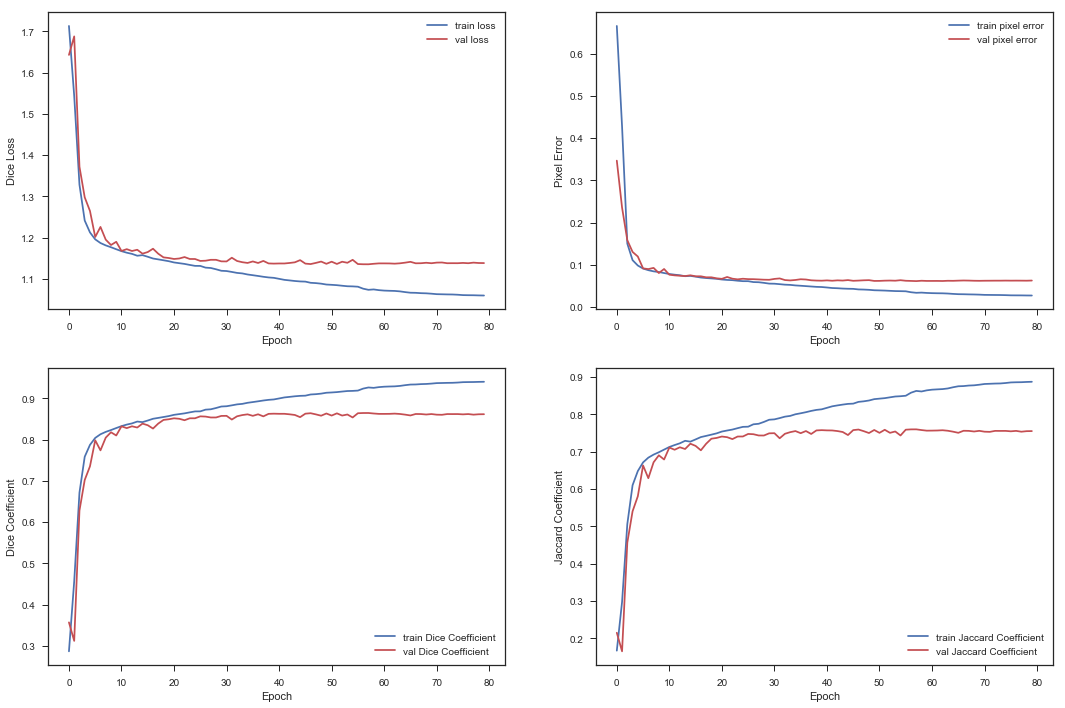

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Dice Loss')
ax[0, 1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[0, 1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Pixel Error')
ax[1, 0].plot(results.epoch, results.history['ofuse_dice_coef'], 'b-', label='train Dice Coefficient')
ax[1, 0].plot(results.epoch, results.history['val_ofuse_dice_coef'], 'r-', label='val Dice Coefficient')
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice Coefficient')
ax[1, 1].plot(results.epoch, results.history['ofuse_jaccard_coef'], 'b-', label='train Jaccard Coefficient')
ax[1, 1].plot(results.epoch, results.history['val_ofuse_jaccard_coef'], 'r-', label='val Jaccard Coefficient')
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Jaccard Coefficient')
plt.show()

In [13]:
np.save(RESULT_PATH + 'history_Unet_fuse_v7_rand.npy', results.history)

In [14]:
model_unet_fuse_v7_rand.save_weights(WEIGHT_PATH + 'UNET_fuse_v7_rand_weight.h5')
model_unet_fuse_v7_rand.save(MODEL_PATH + 'UNET_fuse_v7_rand_model.h5')
model_json = model_unet_fuse_v7_rand.to_json()
with open(MODEL_PATH + 'UNET_fuse_v7_rand_model.json', "w") as json_file:
    json_file.write(model_json)
model_unet_fuse_v7_rand= u_net_fuse_v7(input_shape=(512, 512, 1))
model_unet_fuse_v7_rand.load_weights(WEIGHT_PATH + 'UNET_fuse_v7_rand_weight.h5')
y_pred = model_unet_fuse_v7_rand.predict(X_test, batch_size=5)
result_fuse = (1 - y_pred[-1]).astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

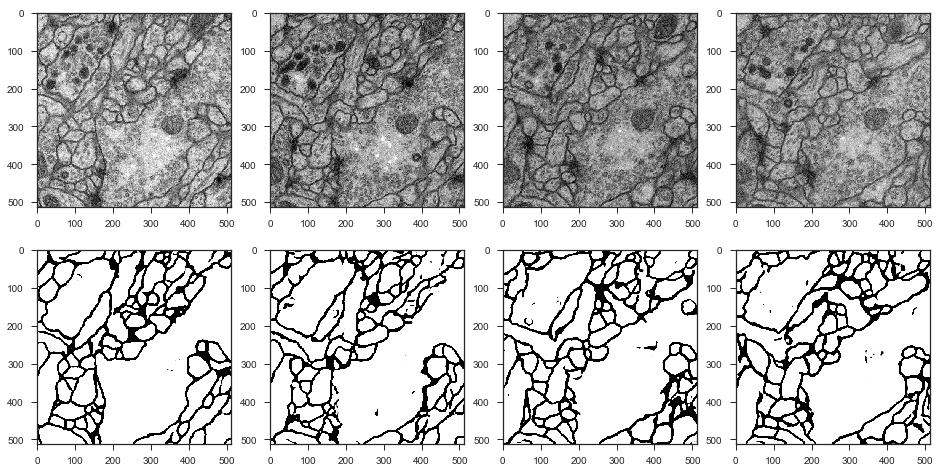

In [15]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v7_rand_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v7_rand_' + timestamp + '.tif')
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='gray')

plt.show()

In [13]:
model_unet_fuse_v7_2 = u_net_fuse_v7_2(input_shape=(512, 512, 1))
model_unet_fuse_v7_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 512, 512, 64) 640         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 512, 512, 64) 256         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation

In [15]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.6, patience=5, verbose=1, 
                             min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, 
                               save_best_only=True, monitor='val_ofuse_pixel_error')
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v7_2', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_fuse_v7_2.compile(loss={'o1': dice_coef_loss,
                                'o2': dice_coef_loss,
                                'o3': dice_coef_loss,
                                'o4': dice_coef_loss,
                                'ofuse': dice_coef_loss,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error, pixel_error_2]},
                          optimizer=optimizer)

results = model_unet_fuse_v7_2.fit(X_train, [y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=4, epochs=80, callbacks=callback_list, verbose=2)

Train on 270 samples, validate on 30 samples


Epoch 1/80


 - 63s - loss: 2.5117 - o1_loss: 0.6473 - o2_loss: 0.5998 - o3_loss: 0.6599 - o4_loss: 0.2879 - ofuse_loss: 0.3168 - ofuse_dice_coef: 0.6832 - ofuse_jaccard_coef: 0.5219 - ofuse_pixel_error: 0.1457 - ofuse_pixel_error_2: 0.3168 - val_loss: 3.1504 - val_o1_loss: 0.6339 - val_o2_loss: 0.6002 - val_o3_loss: 0.6661 - val_o4_loss: 0.5997 - val_ofuse_loss: 0.6506 - val_ofuse_dice_coef: 0.3494 - val_ofuse_jaccard_coef: 0.2162 - val_ofuse_pixel_error: 0.2089 - val_ofuse_pixel_error_2: 0.6506



Epoch 00001: val_ofuse_pixel_error improved from inf to 0.20894, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/80


 - 55s - loss: 2.0608 - o1_loss: 0.5276 - o2_loss: 0.5024 - o3_loss: 0.5972 - o4_loss: 0.2111 - ofuse_loss: 0.2225 - ofuse_dice_coef: 0.7775 - ofuse_jaccard_coef: 0.6342 - ofuse_pixel_error: 0.0999 - ofuse_pixel_error_2: 0.2225 - val_loss: 3.3131 - val_o1_loss: 0.5700 - val_o2_loss: 0.5811 - val_o3_loss: 0.6654 - val_o4_loss: 0.7160 - val_ofuse_loss: 0.7807 - val_ofuse_dice_coef: 0.2193 - val_ofuse_jaccard_coef: 0.1255 - val_ofuse_pixel_error: 0.2060 - val_ofuse_pixel_error_2: 0.7807



Epoch 00002: val_ofuse_pixel_error improved from 0.20894 to 0.20597, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 3/80


 - 56s - loss: 1.7872 - o1_loss: 0.4130 - o2_loss: 0.4335 - o3_loss: 0.5355 - o4_loss: 0.2003 - ofuse_loss: 0.2048 - ofuse_dice_coef: 0.7952 - ofuse_jaccard_coef: 0.6587 - ofuse_pixel_error: 0.0947 - ofuse_pixel_error_2: 0.2048 - val_loss: 1.7038 - val_o1_loss: 0.3601 - val_o2_loss: 0.4002 - val_o3_loss: 0.5151 - val_o4_loss: 0.2072 - val_ofuse_loss: 0.2212 - val_ofuse_dice_coef: 0.7788 - val_ofuse_jaccard_coef: 0.6366 - val_ofuse_pixel_error: 0.0922 - val_ofuse_pixel_error_2: 0.2212



Epoch 00003: val_ofuse_pixel_error improved from 0.20597 to 0.09220, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 4/80


 - 55s - loss: 1.5325 - o1_loss: 0.3145 - o2_loss: 0.3397 - o3_loss: 0.4960 - o4_loss: 0.1900 - ofuse_loss: 0.1923 - ofuse_dice_coef: 0.8077 - ofuse_jaccard_coef: 0.6768 - ofuse_pixel_error: 0.0900 - ofuse_pixel_error_2: 0.1923 - val_loss: 1.5717 - val_o1_loss: 0.3075 - val_o2_loss: 0.3252 - val_o3_loss: 0.4901 - val_o4_loss: 0.2216 - val_ofuse_loss: 0.2273 - val_ofuse_dice_coef: 0.7727 - val_ofuse_jaccard_coef: 0.6287 - val_ofuse_pixel_error: 0.0972 - val_ofuse_pixel_error_2: 0.2273



Epoch 00004: val_ofuse_pixel_error did not improve
Epoch 5/80


 - 55s - loss: 1.4165 - o1_loss: 0.2851 - o2_loss: 0.3063 - o3_loss: 0.4565 - o4_loss: 0.1836 - ofuse_loss: 0.1849 - ofuse_dice_coef: 0.8151 - ofuse_jaccard_coef: 0.6869 - ofuse_pixel_error: 0.0871 - ofuse_pixel_error_2: 0.1849 - val_loss: 1.4567 - val_o1_loss: 0.2868 - val_o2_loss: 0.3177 - val_o3_loss: 0.4356 - val_o4_loss: 0.2072 - val_ofuse_loss: 0.2095 - val_ofuse_dice_coef: 0.7905 - val_ofuse_jaccard_coef: 0.6521 - val_ofuse_pixel_error: 0.0908 - val_ofuse_pixel_error_2: 0.2095



Epoch 00005: val_ofuse_pixel_error improved from 0.09220 to 0.09078, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 6/80


 - 55s - loss: 1.2818 - o1_loss: 0.2771 - o2_loss: 0.2980 - o3_loss: 0.3467 - o4_loss: 0.1794 - ofuse_loss: 0.1806 - ofuse_dice_coef: 0.8194 - ofuse_jaccard_coef: 0.6928 - ofuse_pixel_error: 0.0850 - ofuse_pixel_error_2: 0.1806 - val_loss: 1.1968 - val_o1_loss: 0.2727 - val_o2_loss: 0.2960 - val_o3_loss: 0.2638 - val_o4_loss: 0.1802 - val_ofuse_loss: 0.1841 - val_ofuse_dice_coef: 0.8159 - val_ofuse_jaccard_coef: 0.6871 - val_ofuse_pixel_error: 0.0809 - val_ofuse_pixel_error_2: 0.1841



Epoch 00006: val_ofuse_pixel_error improved from 0.09078 to 0.08087, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 7/80


 - 55s - loss: 1.1363 - o1_loss: 0.2714 - o2_loss: 0.2928 - o3_loss: 0.2203 - o4_loss: 0.1752 - ofuse_loss: 0.1767 - ofuse_dice_coef: 0.8233 - ofuse_jaccard_coef: 0.6984 - ofuse_pixel_error: 0.0830 - ofuse_pixel_error_2: 0.1767 - val_loss: 1.1433 - val_o1_loss: 0.2754 - val_o2_loss: 0.2968 - val_o3_loss: 0.2054 - val_o4_loss: 0.1819 - val_ofuse_loss: 0.1837 - val_ofuse_dice_coef: 0.8163 - val_ofuse_jaccard_coef: 0.6879 - val_ofuse_pixel_error: 0.0873 - val_ofuse_pixel_error_2: 0.1837



Epoch 00007: val_ofuse_pixel_error did not improve
Epoch 8/80


 - 55s - loss: 1.0946 - o1_loss: 0.2686 - o2_loss: 0.2897 - o3_loss: 0.1899 - o4_loss: 0.1728 - ofuse_loss: 0.1737 - ofuse_dice_coef: 0.8263 - ofuse_jaccard_coef: 0.7028 - ofuse_pixel_error: 0.0820 - ofuse_pixel_error_2: 0.1737 - val_loss: 1.1144 - val_o1_loss: 0.2695 - val_o2_loss: 0.2911 - val_o3_loss: 0.1933 - val_o4_loss: 0.1792 - val_ofuse_loss: 0.1812 - val_ofuse_dice_coef: 0.8188 - val_ofuse_jaccard_coef: 0.6916 - val_ofuse_pixel_error: 0.0883 - val_ofuse_pixel_error_2: 0.1812



Epoch 00008: val_ofuse_pixel_error did not improve
Epoch 9/80


 - 55s - loss: 1.0215 - o1_loss: 0.2641 - o2_loss: 0.2429 - o3_loss: 0.1797 - o4_loss: 0.1672 - ofuse_loss: 0.1677 - ofuse_dice_coef: 0.8323 - ofuse_jaccard_coef: 0.7114 - ofuse_pixel_error: 0.0791 - ofuse_pixel_error_2: 0.1677 - val_loss: 1.0112 - val_o1_loss: 0.2672 - val_o2_loss: 0.2124 - val_o3_loss: 0.1842 - val_o4_loss: 0.1734 - val_ofuse_loss: 0.1739 - val_ofuse_dice_coef: 0.8261 - val_ofuse_jaccard_coef: 0.7022 - val_ofuse_pixel_error: 0.0828 - val_ofuse_pixel_error_2: 0.1739



Epoch 00009: val_ofuse_pixel_error did not improve
Epoch 10/80


 - 55s - loss: 0.9708 - o1_loss: 0.2623 - o2_loss: 0.2007 - o3_loss: 0.1761 - o4_loss: 0.1656 - ofuse_loss: 0.1660 - ofuse_dice_coef: 0.8340 - ofuse_jaccard_coef: 0.7140 - ofuse_pixel_error: 0.0786 - ofuse_pixel_error_2: 0.1660 - val_loss: 0.9896 - val_o1_loss: 0.2672 - val_o2_loss: 0.2040 - val_o3_loss: 0.1792 - val_o4_loss: 0.1693 - val_ofuse_loss: 0.1700 - val_ofuse_dice_coef: 0.8300 - val_ofuse_jaccard_coef: 0.7077 - val_ofuse_pixel_error: 0.0811 - val_ofuse_pixel_error_2: 0.1700



Epoch 00010: val_ofuse_pixel_error did not improve
Epoch 11/80


 - 55s - loss: 0.9569 - o1_loss: 0.2602 - o2_loss: 0.1973 - o3_loss: 0.1729 - o4_loss: 0.1631 - ofuse_loss: 0.1634 - ofuse_dice_coef: 0.8366 - ofuse_jaccard_coef: 0.7178 - ofuse_pixel_error: 0.0773 - ofuse_pixel_error_2: 0.1634 - val_loss: 0.9826 - val_o1_loss: 0.2640 - val_o2_loss: 0.2009 - val_o3_loss: 0.1781 - val_o4_loss: 0.1696 - val_ofuse_loss: 0.1700 - val_ofuse_dice_coef: 0.8300 - val_ofuse_jaccard_coef: 0.7080 - val_ofuse_pixel_error: 0.0775 - val_ofuse_pixel_error_2: 0.1700



Epoch 00011: val_ofuse_pixel_error improved from 0.08087 to 0.07753, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 12/80


 - 55s - loss: 0.9373 - o1_loss: 0.2568 - o2_loss: 0.1930 - o3_loss: 0.1686 - o4_loss: 0.1593 - ofuse_loss: 0.1595 - ofuse_dice_coef: 0.8405 - ofuse_jaccard_coef: 0.7236 - ofuse_pixel_error: 0.0753 - ofuse_pixel_error_2: 0.1595 - val_loss: 0.9545 - val_o1_loss: 0.2596 - val_o2_loss: 0.1963 - val_o3_loss: 0.1721 - val_o4_loss: 0.1627 - val_ofuse_loss: 0.1638 - val_ofuse_dice_coef: 0.8362 - val_ofuse_jaccard_coef: 0.7172 - val_ofuse_pixel_error: 0.0797 - val_ofuse_pixel_error_2: 0.1638



Epoch 00012: val_ofuse_pixel_error did not improve
Epoch 13/80


 - 56s - loss: 0.9182 - o1_loss: 0.2541 - o2_loss: 0.1892 - o3_loss: 0.1643 - o4_loss: 0.1552 - ofuse_loss: 0.1554 - ofuse_dice_coef: 0.8446 - ofuse_jaccard_coef: 0.7295 - ofuse_pixel_error: 0.0734 - ofuse_pixel_error_2: 0.1554 - val_loss: 0.9535 - val_o1_loss: 0.2599 - val_o2_loss: 0.1966 - val_o3_loss: 0.1715 - val_o4_loss: 0.1625 - val_ofuse_loss: 0.1629 - val_ofuse_dice_coef: 0.8371 - val_ofuse_jaccard_coef: 0.7184 - val_ofuse_pixel_error: 0.0751 - val_ofuse_pixel_error_2: 0.1629



Epoch 00013: val_ofuse_pixel_error improved from 0.07753 to 0.07505, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 14/80


 - 55s - loss: 0.9149 - o1_loss: 0.2533 - o2_loss: 0.1883 - o3_loss: 0.1635 - o4_loss: 0.1548 - ofuse_loss: 0.1550 - ofuse_dice_coef: 0.8450 - ofuse_jaccard_coef: 0.7302 - ofuse_pixel_error: 0.0731 - ofuse_pixel_error_2: 0.1550 - val_loss: 0.9298 - val_o1_loss: 0.2538 - val_o2_loss: 0.1906 - val_o3_loss: 0.1673 - val_o4_loss: 0.1588 - val_ofuse_loss: 0.1593 - val_ofuse_dice_coef: 0.8407 - val_ofuse_jaccard_coef: 0.7240 - val_ofuse_pixel_error: 0.0768 - val_ofuse_pixel_error_2: 0.1593



Epoch 00014: val_ofuse_pixel_error did not improve
Epoch 15/80


 - 55s - loss: 0.8941 - o1_loss: 0.2504 - o2_loss: 0.1843 - o3_loss: 0.1589 - o4_loss: 0.1502 - ofuse_loss: 0.1503 - ofuse_dice_coef: 0.8497 - ofuse_jaccard_coef: 0.7373 - ofuse_pixel_error: 0.0707 - ofuse_pixel_error_2: 0.1503 - val_loss: 0.9180 - val_o1_loss: 0.2509 - val_o2_loss: 0.1872 - val_o3_loss: 0.1642 - val_o4_loss: 0.1574 - val_ofuse_loss: 0.1583 - val_ofuse_dice_coef: 0.8417 - val_ofuse_jaccard_coef: 0.7256 - val_ofuse_pixel_error: 0.0769 - val_ofuse_pixel_error_2: 0.1583



Epoch 00015: val_ofuse_pixel_error did not improve
Epoch 16/80


 - 55s - loss: 0.8891 - o1_loss: 0.2494 - o2_loss: 0.1832 - o3_loss: 0.1579 - o4_loss: 0.1493 - ofuse_loss: 0.1494 - ofuse_dice_coef: 0.8506 - ofuse_jaccard_coef: 0.7386 - ofuse_pixel_error: 0.0703 - ofuse_pixel_error_2: 0.1494 - val_loss: 0.9285 - val_o1_loss: 0.2541 - val_o2_loss: 0.1904 - val_o3_loss: 0.1661 - val_o4_loss: 0.1588 - val_ofuse_loss: 0.1592 - val_ofuse_dice_coef: 0.8408 - val_ofuse_jaccard_coef: 0.7242 - val_ofuse_pixel_error: 0.0756 - val_ofuse_pixel_error_2: 0.1592



Epoch 00016: val_ofuse_pixel_error did not improve
Epoch 17/80


 - 55s - loss: 0.8792 - o1_loss: 0.2479 - o2_loss: 0.1815 - o3_loss: 0.1556 - o4_loss: 0.1470 - ofuse_loss: 0.1471 - ofuse_dice_coef: 0.8529 - ofuse_jaccard_coef: 0.7420 - ofuse_pixel_error: 0.0692 - ofuse_pixel_error_2: 0.1471 - val_loss: 0.9327 - val_o1_loss: 0.2599 - val_o2_loss: 0.1913 - val_o3_loss: 0.1672 - val_o4_loss: 0.1571 - val_ofuse_loss: 0.1572 - val_ofuse_dice_coef: 0.8428 - val_ofuse_jaccard_coef: 0.7267 - val_ofuse_pixel_error: 0.0703 - val_ofuse_pixel_error_2: 0.1572



Epoch 00017: val_ofuse_pixel_error improved from 0.07505 to 0.07035, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 18/80


 - 55s - loss: 0.8700 - o1_loss: 0.2468 - o2_loss: 0.1795 - o3_loss: 0.1535 - o4_loss: 0.1451 - ofuse_loss: 0.1451 - ofuse_dice_coef: 0.8549 - ofuse_jaccard_coef: 0.7450 - ofuse_pixel_error: 0.0682 - ofuse_pixel_error_2: 0.1451 - val_loss: 0.8864 - val_o1_loss: 0.2494 - val_o2_loss: 0.1825 - val_o3_loss: 0.1571 - val_o4_loss: 0.1486 - val_ofuse_loss: 0.1488 - val_ofuse_dice_coef: 0.8512 - val_ofuse_jaccard_coef: 0.7392 - val_ofuse_pixel_error: 0.0697 - val_ofuse_pixel_error_2: 0.1488



Epoch 00018: val_ofuse_pixel_error improved from 0.07035 to 0.06965, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 19/80


 - 55s - loss: 0.8563 - o1_loss: 0.2447 - o2_loss: 0.1768 - o3_loss: 0.1506 - o4_loss: 0.1421 - ofuse_loss: 0.1422 - ofuse_dice_coef: 0.8578 - ofuse_jaccard_coef: 0.7495 - ofuse_pixel_error: 0.0668 - ofuse_pixel_error_2: 0.1422 - val_loss: 0.9027 - val_o1_loss: 0.2519 - val_o2_loss: 0.1863 - val_o3_loss: 0.1602 - val_o4_loss: 0.1521 - val_ofuse_loss: 0.1522 - val_ofuse_dice_coef: 0.8478 - val_ofuse_jaccard_coef: 0.7343 - val_ofuse_pixel_error: 0.0691 - val_ofuse_pixel_error_2: 0.1522



Epoch 00019: val_ofuse_pixel_error improved from 0.06965 to 0.06907, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 20/80


 - 55s - loss: 0.8536 - o1_loss: 0.2442 - o2_loss: 0.1764 - o3_loss: 0.1500 - o4_loss: 0.1415 - ofuse_loss: 0.1415 - ofuse_dice_coef: 0.8585 - ofuse_jaccard_coef: 0.7508 - ofuse_pixel_error: 0.0664 - ofuse_pixel_error_2: 0.1415 - val_loss: 0.9145 - val_o1_loss: 0.2514 - val_o2_loss: 0.1882 - val_o3_loss: 0.1632 - val_o4_loss: 0.1560 - val_ofuse_loss: 0.1557 - val_ofuse_dice_coef: 0.8443 - val_ofuse_jaccard_coef: 0.7294 - val_ofuse_pixel_error: 0.0699 - val_ofuse_pixel_error_2: 0.1557



Epoch 00020: val_ofuse_pixel_error did not improve
Epoch 21/80


 - 55s - loss: 0.8404 - o1_loss: 0.2423 - o2_loss: 0.1738 - o3_loss: 0.1471 - o4_loss: 0.1386 - ofuse_loss: 0.1386 - ofuse_dice_coef: 0.8614 - ofuse_jaccard_coef: 0.7550 - ofuse_pixel_error: 0.0650 - ofuse_pixel_error_2: 0.1386 - val_loss: 0.9148 - val_o1_loss: 0.2530 - val_o2_loss: 0.1884 - val_o3_loss: 0.1630 - val_o4_loss: 0.1551 - val_ofuse_loss: 0.1554 - val_ofuse_dice_coef: 0.8446 - val_ofuse_jaccard_coef: 0.7293 - val_ofuse_pixel_error: 0.0724 - val_ofuse_pixel_error_2: 0.1554



Epoch 00021: val_ofuse_pixel_error did not improve
Epoch 22/80


 - 55s - loss: 0.8332 - o1_loss: 0.2413 - o2_loss: 0.1723 - o3_loss: 0.1455 - o4_loss: 0.1370 - ofuse_loss: 0.1371 - ofuse_dice_coef: 0.8629 - ofuse_jaccard_coef: 0.7576 - ofuse_pixel_error: 0.0643 - ofuse_pixel_error_2: 0.1371 - val_loss: 0.8821 - val_o1_loss: 0.2480 - val_o2_loss: 0.1817 - val_o3_loss: 0.1559 - val_o4_loss: 0.1483 - val_ofuse_loss: 0.1482 - val_ofuse_dice_coef: 0.8518 - val_ofuse_jaccard_coef: 0.7402 - val_ofuse_pixel_error: 0.0682 - val_ofuse_pixel_error_2: 0.1482



Epoch 00022: val_ofuse_pixel_error improved from 0.06907 to 0.06822, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 23/80


 - 55s - loss: 0.8224 - o1_loss: 0.2399 - o2_loss: 0.1703 - o3_loss: 0.1431 - o4_loss: 0.1346 - ofuse_loss: 0.1346 - ofuse_dice_coef: 0.8654 - ofuse_jaccard_coef: 0.7613 - ofuse_pixel_error: 0.0630 - ofuse_pixel_error_2: 0.1346 - val_loss: 0.8824 - val_o1_loss: 0.2487 - val_o2_loss: 0.1834 - val_o3_loss: 0.1564 - val_o4_loss: 0.1470 - val_ofuse_loss: 0.1469 - val_ofuse_dice_coef: 0.8531 - val_ofuse_jaccard_coef: 0.7421 - val_ofuse_pixel_error: 0.0662 - val_ofuse_pixel_error_2: 0.1469



Epoch 00023: val_ofuse_pixel_error improved from 0.06822 to 0.06616, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 24/80


 - 54s - loss: 0.8169 - o1_loss: 0.2388 - o2_loss: 0.1692 - o3_loss: 0.1420 - o4_loss: 0.1335 - ofuse_loss: 0.1335 - ofuse_dice_coef: 0.8665 - ofuse_jaccard_coef: 0.7630 - ofuse_pixel_error: 0.0625 - ofuse_pixel_error_2: 0.1335 - val_loss: 0.8645 - val_o1_loss: 0.2453 - val_o2_loss: 0.1783 - val_o3_loss: 0.1520 - val_o4_loss: 0.1442 - val_ofuse_loss: 0.1446 - val_ofuse_dice_coef: 0.8554 - val_ofuse_jaccard_coef: 0.7461 - val_ofuse_pixel_error: 0.0685 - val_ofuse_pixel_error_2: 0.1446



Epoch 00024: val_ofuse_pixel_error did not improve
Epoch 25/80


 - 54s - loss: 0.8093 - o1_loss: 0.2379 - o2_loss: 0.1679 - o3_loss: 0.1402 - o4_loss: 0.1316 - ofuse_loss: 0.1317 - ofuse_dice_coef: 0.8683 - ofuse_jaccard_coef: 0.7660 - ofuse_pixel_error: 0.0616 - ofuse_pixel_error_2: 0.1317 - val_loss: 0.8700 - val_o1_loss: 0.2463 - val_o2_loss: 0.1796 - val_o3_loss: 0.1532 - val_o4_loss: 0.1455 - val_ofuse_loss: 0.1453 - val_ofuse_dice_coef: 0.8547 - val_ofuse_jaccard_coef: 0.7446 - val_ofuse_pixel_error: 0.0654 - val_ofuse_pixel_error_2: 0.1453



Epoch 00025: val_ofuse_pixel_error improved from 0.06616 to 0.06543, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 26/80


 - 54s - loss: 0.7978 - o1_loss: 0.2366 - o2_loss: 0.1656 - o3_loss: 0.1376 - o4_loss: 0.1290 - ofuse_loss: 0.1290 - ofuse_dice_coef: 0.8710 - ofuse_jaccard_coef: 0.7702 - ofuse_pixel_error: 0.0604 - ofuse_pixel_error_2: 0.1290 - val_loss: 0.8615 - val_o1_loss: 0.2450 - val_o2_loss: 0.1783 - val_o3_loss: 0.1520 - val_o4_loss: 0.1432 - val_ofuse_loss: 0.1431 - val_ofuse_dice_coef: 0.8569 - val_ofuse_jaccard_coef: 0.7479 - val_ofuse_pixel_error: 0.0646 - val_ofuse_pixel_error_2: 0.1431



Epoch 00026: val_ofuse_pixel_error improved from 0.06543 to 0.06462, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 27/80


 - 54s - loss: 0.7921 - o1_loss: 0.2357 - o2_loss: 0.1645 - o3_loss: 0.1364 - o4_loss: 0.1277 - ofuse_loss: 0.1277 - ofuse_dice_coef: 0.8723 - ofuse_jaccard_coef: 0.7724 - ofuse_pixel_error: 0.0597 - ofuse_pixel_error_2: 0.1277 - val_loss: 0.8517 - val_o1_loss: 0.2440 - val_o2_loss: 0.1767 - val_o3_loss: 0.1493 - val_o4_loss: 0.1408 - val_ofuse_loss: 0.1408 - val_ofuse_dice_coef: 0.8592 - val_ofuse_jaccard_coef: 0.7517 - val_ofuse_pixel_error: 0.0650 - val_ofuse_pixel_error_2: 0.1408



Epoch 00027: val_ofuse_pixel_error did not improve
Epoch 28/80


 - 54s - loss: 0.7864 - o1_loss: 0.2351 - o2_loss: 0.1635 - o3_loss: 0.1351 - o4_loss: 0.1263 - ofuse_loss: 0.1263 - ofuse_dice_coef: 0.8737 - ofuse_jaccard_coef: 0.7743 - ofuse_pixel_error: 0.0590 - ofuse_pixel_error_2: 0.1263 - val_loss: 0.8578 - val_o1_loss: 0.2456 - val_o2_loss: 0.1774 - val_o3_loss: 0.1505 - val_o4_loss: 0.1421 - val_ofuse_loss: 0.1421 - val_ofuse_dice_coef: 0.8579 - val_ofuse_jaccard_coef: 0.7495 - val_ofuse_pixel_error: 0.0662 - val_ofuse_pixel_error_2: 0.1421



Epoch 00028: val_ofuse_pixel_error did not improve
Epoch 29/80


 - 54s - loss: 0.7777 - o1_loss: 0.2339 - o2_loss: 0.1619 - o3_loss: 0.1332 - o4_loss: 0.1244 - ofuse_loss: 0.1244 - ofuse_dice_coef: 0.8756 - ofuse_jaccard_coef: 0.7775 - ofuse_pixel_error: 0.0581 - ofuse_pixel_error_2: 0.1244 - val_loss: 0.8457 - val_o1_loss: 0.2429 - val_o2_loss: 0.1747 - val_o3_loss: 0.1477 - val_o4_loss: 0.1402 - val_ofuse_loss: 0.1403 - val_ofuse_dice_coef: 0.8597 - val_ofuse_jaccard_coef: 0.7524 - val_ofuse_pixel_error: 0.0657 - val_ofuse_pixel_error_2: 0.1403



Epoch 00029: val_ofuse_pixel_error did not improve
Epoch 30/80


 - 54s - loss: 0.7644 - o1_loss: 0.2324 - o2_loss: 0.1595 - o3_loss: 0.1302 - o4_loss: 0.1212 - ofuse_loss: 0.1212 - ofuse_dice_coef: 0.8788 - ofuse_jaccard_coef: 0.7825 - ofuse_pixel_error: 0.0566 - ofuse_pixel_error_2: 0.1212 - val_loss: 0.8390 - val_o1_loss: 0.2434 - val_o2_loss: 0.1745 - val_o3_loss: 0.1461 - val_o4_loss: 0.1374 - val_ofuse_loss: 0.1374 - val_ofuse_dice_coef: 0.8626 - val_ofuse_jaccard_coef: 0.7568 - val_ofuse_pixel_error: 0.0631 - val_ofuse_pixel_error_2: 0.1374



Epoch 00030: val_ofuse_pixel_error improved from 0.06462 to 0.06314, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 31/80


 - 54s - loss: 0.7560 - o1_loss: 0.2314 - o2_loss: 0.1579 - o3_loss: 0.1282 - o4_loss: 0.1192 - ofuse_loss: 0.1193 - ofuse_dice_coef: 0.8807 - ofuse_jaccard_coef: 0.7856 - ofuse_pixel_error: 0.0556 - ofuse_pixel_error_2: 0.1193 - val_loss: 0.8409 - val_o1_loss: 0.2422 - val_o2_loss: 0.1740 - val_o3_loss: 0.1471 - val_o4_loss: 0.1387 - val_ofuse_loss: 0.1388 - val_ofuse_dice_coef: 0.8612 - val_ofuse_jaccard_coef: 0.7546 - val_ofuse_pixel_error: 0.0646 - val_ofuse_pixel_error_2: 0.1388



Epoch 00031: val_ofuse_pixel_error did not improve
Epoch 32/80


 - 54s - loss: 0.7481 - o1_loss: 0.2302 - o2_loss: 0.1565 - o3_loss: 0.1266 - o4_loss: 0.1174 - ofuse_loss: 0.1174 - ofuse_dice_coef: 0.8826 - ofuse_jaccard_coef: 0.7883 - ofuse_pixel_error: 0.0547 - ofuse_pixel_error_2: 0.1174 - val_loss: 0.8465 - val_o1_loss: 0.2451 - val_o2_loss: 0.1768 - val_o3_loss: 0.1477 - val_o4_loss: 0.1385 - val_ofuse_loss: 0.1385 - val_ofuse_dice_coef: 0.8615 - val_ofuse_jaccard_coef: 0.7552 - val_ofuse_pixel_error: 0.0629 - val_ofuse_pixel_error_2: 0.1385



Epoch 00032: val_ofuse_pixel_error improved from 0.06314 to 0.06293, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 33/80


 - 54s - loss: 0.7450 - o1_loss: 0.2302 - o2_loss: 0.1558 - o3_loss: 0.1258 - o4_loss: 0.1166 - ofuse_loss: 0.1166 - ofuse_dice_coef: 0.8834 - ofuse_jaccard_coef: 0.7895 - ofuse_pixel_error: 0.0543 - ofuse_pixel_error_2: 0.1166 - val_loss: 0.8345 - val_o1_loss: 0.2414 - val_o2_loss: 0.1733 - val_o3_loss: 0.1456 - val_o4_loss: 0.1371 - val_ofuse_loss: 0.1370 - val_ofuse_dice_coef: 0.8630 - val_ofuse_jaccard_coef: 0.7574 - val_ofuse_pixel_error: 0.0621 - val_ofuse_pixel_error_2: 0.1370



Epoch 00033: val_ofuse_pixel_error improved from 0.06293 to 0.06210, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 34/80


 - 54s - loss: 0.7350 - o1_loss: 0.2291 - o2_loss: 0.1541 - o3_loss: 0.1235 - o4_loss: 0.1141 - ofuse_loss: 0.1141 - ofuse_dice_coef: 0.8859 - ofuse_jaccard_coef: 0.7939 - ofuse_pixel_error: 0.0531 - ofuse_pixel_error_2: 0.1141 - val_loss: 0.8306 - val_o1_loss: 0.2412 - val_o2_loss: 0.1722 - val_o3_loss: 0.1449 - val_o4_loss: 0.1362 - val_ofuse_loss: 0.1362 - val_ofuse_dice_coef: 0.8638 - val_ofuse_jaccard_coef: 0.7587 - val_ofuse_pixel_error: 0.0633 - val_ofuse_pixel_error_2: 0.1362



Epoch 00034: val_ofuse_pixel_error did not improve
Epoch 35/80


 - 54s - loss: 0.7277 - o1_loss: 0.2286 - o2_loss: 0.1528 - o3_loss: 0.1219 - o4_loss: 0.1123 - ofuse_loss: 0.1123 - ofuse_dice_coef: 0.8877 - ofuse_jaccard_coef: 0.7969 - ofuse_pixel_error: 0.0522 - ofuse_pixel_error_2: 0.1123 - val_loss: 0.8426 - val_o1_loss: 0.2432 - val_o2_loss: 0.1748 - val_o3_loss: 0.1470 - val_o4_loss: 0.1388 - val_ofuse_loss: 0.1388 - val_ofuse_dice_coef: 0.8612 - val_ofuse_jaccard_coef: 0.7546 - val_ofuse_pixel_error: 0.0632 - val_ofuse_pixel_error_2: 0.1388



Epoch 00035: val_ofuse_pixel_error did not improve
Epoch 36/80


 - 54s - loss: 0.7179 - o1_loss: 0.2273 - o2_loss: 0.1509 - o3_loss: 0.1196 - o4_loss: 0.1100 - ofuse_loss: 0.1100 - ofuse_dice_coef: 0.8900 - ofuse_jaccard_coef: 0.8006 - ofuse_pixel_error: 0.0511 - ofuse_pixel_error_2: 0.1100 - val_loss: 0.8295 - val_o1_loss: 0.2413 - val_o2_loss: 0.1720 - val_o3_loss: 0.1446 - val_o4_loss: 0.1358 - val_ofuse_loss: 0.1358 - val_ofuse_dice_coef: 0.8642 - val_ofuse_jaccard_coef: 0.7593 - val_ofuse_pixel_error: 0.0614 - val_ofuse_pixel_error_2: 0.1358



Epoch 00036: val_ofuse_pixel_error improved from 0.06210 to 0.06145, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 37/80


 - 53s - loss: 0.7137 - o1_loss: 0.2266 - o2_loss: 0.1502 - o3_loss: 0.1187 - o4_loss: 0.1091 - ofuse_loss: 0.1091 - ofuse_dice_coef: 0.8909 - ofuse_jaccard_coef: 0.8022 - ofuse_pixel_error: 0.0507 - ofuse_pixel_error_2: 0.1091 - val_loss: 0.8592 - val_o1_loss: 0.2447 - val_o2_loss: 0.1777 - val_o3_loss: 0.1505 - val_o4_loss: 0.1432 - val_ofuse_loss: 0.1430 - val_ofuse_dice_coef: 0.8570 - val_ofuse_jaccard_coef: 0.7484 - val_ofuse_pixel_error: 0.0643 - val_ofuse_pixel_error_2: 0.1430



Epoch 00037: val_ofuse_pixel_error did not improve
Epoch 38/80


 - 53s - loss: 0.7017 - o1_loss: 0.2256 - o2_loss: 0.1482 - o3_loss: 0.1159 - o4_loss: 0.1060 - ofuse_loss: 0.1060 - ofuse_dice_coef: 0.8940 - ofuse_jaccard_coef: 0.8069 - ofuse_pixel_error: 0.0492 - ofuse_pixel_error_2: 0.1060 - val_loss: 0.8412 - val_o1_loss: 0.2420 - val_o2_loss: 0.1731 - val_o3_loss: 0.1469 - val_o4_loss: 0.1395 - val_ofuse_loss: 0.1396 - val_ofuse_dice_coef: 0.8604 - val_ofuse_jaccard_coef: 0.7534 - val_ofuse_pixel_error: 0.0664 - val_ofuse_pixel_error_2: 0.1396



Epoch 00038: val_ofuse_pixel_error did not improve
Epoch 39/80


 - 53s - loss: 0.6972 - o1_loss: 0.2253 - o2_loss: 0.1475 - o3_loss: 0.1148 - o4_loss: 0.1048 - ofuse_loss: 0.1048 - ofuse_dice_coef: 0.8952 - ofuse_jaccard_coef: 0.8090 - ofuse_pixel_error: 0.0486 - ofuse_pixel_error_2: 0.1048 - val_loss: 0.8220 - val_o1_loss: 0.2405 - val_o2_loss: 0.1705 - val_o3_loss: 0.1425 - val_o4_loss: 0.1342 - val_ofuse_loss: 0.1343 - val_ofuse_dice_coef: 0.8657 - val_ofuse_jaccard_coef: 0.7617 - val_ofuse_pixel_error: 0.0628 - val_ofuse_pixel_error_2: 0.1343



Epoch 00039: val_ofuse_pixel_error did not improve
Epoch 40/80


 - 53s - loss: 0.6847 - o1_loss: 0.2240 - o2_loss: 0.1452 - o3_loss: 0.1120 - o4_loss: 0.1018 - ofuse_loss: 0.1017 - ofuse_dice_coef: 0.8983 - ofuse_jaccard_coef: 0.8142 - ofuse_pixel_error: 0.0472 - ofuse_pixel_error_2: 0.1017 - val_loss: 0.8353 - val_o1_loss: 0.2415 - val_o2_loss: 0.1739 - val_o3_loss: 0.1457 - val_o4_loss: 0.1371 - val_ofuse_loss: 0.1371 - val_ofuse_dice_coef: 0.8629 - val_ofuse_jaccard_coef: 0.7571 - val_ofuse_pixel_error: 0.0618 - val_ofuse_pixel_error_2: 0.1371



Epoch 00040: val_ofuse_pixel_error did not improve
Epoch 41/80


 - 53s - loss: 0.6846 - o1_loss: 0.2238 - o2_loss: 0.1452 - o3_loss: 0.1120 - o4_loss: 0.1018 - ofuse_loss: 0.1018 - ofuse_dice_coef: 0.8982 - ofuse_jaccard_coef: 0.8142 - ofuse_pixel_error: 0.0472 - ofuse_pixel_error_2: 0.1018 - val_loss: 0.8369 - val_o1_loss: 0.2417 - val_o2_loss: 0.1731 - val_o3_loss: 0.1459 - val_o4_loss: 0.1382 - val_ofuse_loss: 0.1381 - val_ofuse_dice_coef: 0.8619 - val_ofuse_jaccard_coef: 0.7556 - val_ofuse_pixel_error: 0.0642 - val_ofuse_pixel_error_2: 0.1381



Epoch 00041: val_ofuse_pixel_error did not improve
Epoch 42/80


 - 53s - loss: 0.6748 - o1_loss: 0.2229 - o2_loss: 0.1435 - o3_loss: 0.1097 - o4_loss: 0.0993 - ofuse_loss: 0.0993 - ofuse_dice_coef: 0.9007 - ofuse_jaccard_coef: 0.8182 - ofuse_pixel_error: 0.0460 - ofuse_pixel_error_2: 0.0993 - val_loss: 0.8263 - val_o1_loss: 0.2415 - val_o2_loss: 0.1723 - val_o3_loss: 0.1435 - val_o4_loss: 0.1345 - val_ofuse_loss: 0.1345 - val_ofuse_dice_coef: 0.8655 - val_ofuse_jaccard_coef: 0.7615 - val_ofuse_pixel_error: 0.0612 - val_ofuse_pixel_error_2: 0.1345



Epoch 00042: val_ofuse_pixel_error improved from 0.06145 to 0.06120, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 43/80


 - 53s - loss: 0.6689 - o1_loss: 0.2224 - o2_loss: 0.1426 - o3_loss: 0.1083 - o4_loss: 0.0978 - ofuse_loss: 0.0978 - ofuse_dice_coef: 0.9022 - ofuse_jaccard_coef: 0.8207 - ofuse_pixel_error: 0.0452 - ofuse_pixel_error_2: 0.0978 - val_loss: 0.8264 - val_o1_loss: 0.2415 - val_o2_loss: 0.1715 - val_o3_loss: 0.1433 - val_o4_loss: 0.1350 - val_ofuse_loss: 0.1351 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7606 - val_ofuse_pixel_error: 0.0616 - val_ofuse_pixel_error_2: 0.1351



Epoch 00043: val_ofuse_pixel_error did not improve
Epoch 44/80


 - 53s - loss: 0.6627 - o1_loss: 0.2218 - o2_loss: 0.1415 - o3_loss: 0.1070 - o4_loss: 0.0962 - ofuse_loss: 0.0962 - ofuse_dice_coef: 0.9038 - ofuse_jaccard_coef: 0.8233 - ofuse_pixel_error: 0.0445 - ofuse_pixel_error_2: 0.0962 - val_loss: 0.8336 - val_o1_loss: 0.2419 - val_o2_loss: 0.1733 - val_o3_loss: 0.1452 - val_o4_loss: 0.1366 - val_ofuse_loss: 0.1366 - val_ofuse_dice_coef: 0.8634 - val_ofuse_jaccard_coef: 0.7579 - val_ofuse_pixel_error: 0.0610 - val_ofuse_pixel_error_2: 0.1366



Epoch 00044: val_ofuse_pixel_error improved from 0.06120 to 0.06102, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 45/80


 - 53s - loss: 0.6597 - o1_loss: 0.2214 - o2_loss: 0.1409 - o3_loss: 0.1063 - o4_loss: 0.0955 - ofuse_loss: 0.0955 - ofuse_dice_coef: 0.9045 - ofuse_jaccard_coef: 0.8246 - ofuse_pixel_error: 0.0441 - ofuse_pixel_error_2: 0.0955 - val_loss: 0.8417 - val_o1_loss: 0.2429 - val_o2_loss: 0.1745 - val_o3_loss: 0.1466 - val_o4_loss: 0.1389 - val_ofuse_loss: 0.1389 - val_ofuse_dice_coef: 0.8611 - val_ofuse_jaccard_coef: 0.7545 - val_ofuse_pixel_error: 0.0649 - val_ofuse_pixel_error_2: 0.1389



Epoch 00045: val_ofuse_pixel_error did not improve
Epoch 46/80


 - 53s - loss: 0.6545 - o1_loss: 0.2212 - o2_loss: 0.1402 - o3_loss: 0.1050 - o4_loss: 0.0941 - ofuse_loss: 0.0941 - ofuse_dice_coef: 0.9059 - ofuse_jaccard_coef: 0.8270 - ofuse_pixel_error: 0.0435 - ofuse_pixel_error_2: 0.0941 - val_loss: 0.8472 - val_o1_loss: 0.2430 - val_o2_loss: 0.1760 - val_o3_loss: 0.1481 - val_o4_loss: 0.1401 - val_ofuse_loss: 0.1400 - val_ofuse_dice_coef: 0.8600 - val_ofuse_jaccard_coef: 0.7530 - val_ofuse_pixel_error: 0.0620 - val_ofuse_pixel_error_2: 0.1400



Epoch 00046: val_ofuse_pixel_error did not improve
Epoch 47/80


 - 52s - loss: 0.6467 - o1_loss: 0.2203 - o2_loss: 0.1387 - o3_loss: 0.1033 - o4_loss: 0.0922 - ofuse_loss: 0.0922 - ofuse_dice_coef: 0.9078 - ofuse_jaccard_coef: 0.8299 - ofuse_pixel_error: 0.0426 - ofuse_pixel_error_2: 0.0922 - val_loss: 0.8226 - val_o1_loss: 0.2405 - val_o2_loss: 0.1712 - val_o3_loss: 0.1425 - val_o4_loss: 0.1342 - val_ofuse_loss: 0.1342 - val_ofuse_dice_coef: 0.8658 - val_ofuse_jaccard_coef: 0.7619 - val_ofuse_pixel_error: 0.0615 - val_ofuse_pixel_error_2: 0.1342



Epoch 00047: val_ofuse_pixel_error did not improve
Epoch 48/80


 - 52s - loss: 0.6366 - o1_loss: 0.2191 - o2_loss: 0.1369 - o3_loss: 0.1010 - o4_loss: 0.0898 - ofuse_loss: 0.0898 - ofuse_dice_coef: 0.9102 - ofuse_jaccard_coef: 0.8342 - ofuse_pixel_error: 0.0415 - ofuse_pixel_error_2: 0.0898 - val_loss: 0.8196 - val_o1_loss: 0.2410 - val_o2_loss: 0.1708 - val_o3_loss: 0.1416 - val_o4_loss: 0.1331 - val_ofuse_loss: 0.1331 - val_ofuse_dice_coef: 0.8669 - val_ofuse_jaccard_coef: 0.7637 - val_ofuse_pixel_error: 0.0609 - val_ofuse_pixel_error_2: 0.1331



Epoch 00048: val_ofuse_pixel_error improved from 0.06102 to 0.06086, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 49/80


 - 52s - loss: 0.6351 - o1_loss: 0.2193 - o2_loss: 0.1368 - o3_loss: 0.1006 - o4_loss: 0.0892 - ofuse_loss: 0.0892 - ofuse_dice_coef: 0.9108 - ofuse_jaccard_coef: 0.8351 - ofuse_pixel_error: 0.0411 - ofuse_pixel_error_2: 0.0892 - val_loss: 0.8241 - val_o1_loss: 0.2406 - val_o2_loss: 0.1715 - val_o3_loss: 0.1429 - val_o4_loss: 0.1345 - val_ofuse_loss: 0.1346 - val_ofuse_dice_coef: 0.8654 - val_ofuse_jaccard_coef: 0.7613 - val_ofuse_pixel_error: 0.0623 - val_ofuse_pixel_error_2: 0.1346



Epoch 00049: val_ofuse_pixel_error did not improve
Epoch 50/80


 - 52s - loss: 0.6297 - o1_loss: 0.2186 - o2_loss: 0.1359 - o3_loss: 0.0994 - o4_loss: 0.0879 - ofuse_loss: 0.0879 - ofuse_dice_coef: 0.9121 - ofuse_jaccard_coef: 0.8373 - ofuse_pixel_error: 0.0406 - ofuse_pixel_error_2: 0.0879 - val_loss: 0.8210 - val_o1_loss: 0.2401 - val_o2_loss: 0.1710 - val_o3_loss: 0.1423 - val_o4_loss: 0.1338 - val_ofuse_loss: 0.1338 - val_ofuse_dice_coef: 0.8662 - val_ofuse_jaccard_coef: 0.7622 - val_ofuse_pixel_error: 0.0612 - val_ofuse_pixel_error_2: 0.1338



Epoch 00050: val_ofuse_pixel_error did not improve
Epoch 51/80


 - 52s - loss: 0.6269 - o1_loss: 0.2186 - o2_loss: 0.1354 - o3_loss: 0.0987 - o4_loss: 0.0871 - ofuse_loss: 0.0871 - ofuse_dice_coef: 0.9129 - ofuse_jaccard_coef: 0.8388 - ofuse_pixel_error: 0.0401 - ofuse_pixel_error_2: 0.0871 - val_loss: 0.8197 - val_o1_loss: 0.2405 - val_o2_loss: 0.1708 - val_o3_loss: 0.1419 - val_o4_loss: 0.1332 - val_ofuse_loss: 0.1333 - val_ofuse_dice_coef: 0.8667 - val_ofuse_jaccard_coef: 0.7633 - val_ofuse_pixel_error: 0.0614 - val_ofuse_pixel_error_2: 0.1333



Epoch 00051: val_ofuse_pixel_error did not improve
Epoch 52/80


 - 52s - loss: 0.6209 - o1_loss: 0.2179 - o2_loss: 0.1345 - o3_loss: 0.0973 - o4_loss: 0.0856 - ofuse_loss: 0.0856 - ofuse_dice_coef: 0.9144 - ofuse_jaccard_coef: 0.8413 - ofuse_pixel_error: 0.0395 - ofuse_pixel_error_2: 0.0856 - val_loss: 0.8340 - val_o1_loss: 0.2421 - val_o2_loss: 0.1735 - val_o3_loss: 0.1450 - val_o4_loss: 0.1366 - val_ofuse_loss: 0.1367 - val_ofuse_dice_coef: 0.8633 - val_ofuse_jaccard_coef: 0.7578 - val_ofuse_pixel_error: 0.0628 - val_ofuse_pixel_error_2: 0.1367



Epoch 00052: val_ofuse_pixel_error did not improve
Epoch 53/80


 - 52s - loss: 0.6212 - o1_loss: 0.2180 - o2_loss: 0.1345 - o3_loss: 0.0974 - o4_loss: 0.0856 - ofuse_loss: 0.0856 - ofuse_dice_coef: 0.9144 - ofuse_jaccard_coef: 0.8413 - ofuse_pixel_error: 0.0395 - ofuse_pixel_error_2: 0.0856 - val_loss: 0.8291 - val_o1_loss: 0.2426 - val_o2_loss: 0.1729 - val_o3_loss: 0.1439 - val_o4_loss: 0.1349 - val_ofuse_loss: 0.1349 - val_ofuse_dice_coef: 0.8651 - val_ofuse_jaccard_coef: 0.7605 - val_ofuse_pixel_error: 0.0611 - val_ofuse_pixel_error_2: 0.1349



Epoch 00053: val_ofuse_pixel_error did not improve
Epoch 54/80


 - 52s - loss: 0.6148 - o1_loss: 0.2174 - o2_loss: 0.1334 - o3_loss: 0.0960 - o4_loss: 0.0840 - ofuse_loss: 0.0840 - ofuse_dice_coef: 0.9160 - ofuse_jaccard_coef: 0.8440 - ofuse_pixel_error: 0.0387 - ofuse_pixel_error_2: 0.0840 - val_loss: 0.8220 - val_o1_loss: 0.2397 - val_o2_loss: 0.1706 - val_o3_loss: 0.1431 - val_o4_loss: 0.1343 - val_ofuse_loss: 0.1343 - val_ofuse_dice_coef: 0.8657 - val_ofuse_jaccard_coef: 0.7616 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1343



Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.000600000028498.

Epoch 00054: val_ofuse_pixel_error improved from 0.06086 to 0.06085, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 55/80


 - 52s - loss: 0.5980 - o1_loss: 0.2162 - o2_loss: 0.1310 - o3_loss: 0.0920 - o4_loss: 0.0794 - ofuse_loss: 0.0794 - ofuse_dice_coef: 0.9206 - ofuse_jaccard_coef: 0.8520 - ofuse_pixel_error: 0.0366 - ofuse_pixel_error_2: 0.0794 - val_loss: 0.8313 - val_o1_loss: 0.2413 - val_o2_loss: 0.1725 - val_o3_loss: 0.1448 - val_o4_loss: 0.1363 - val_ofuse_loss: 0.1363 - val_ofuse_dice_coef: 0.8637 - val_ofuse_jaccard_coef: 0.7583 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1363



Epoch 00055: val_ofuse_pixel_error improved from 0.06085 to 0.06081, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 56/80


 - 52s - loss: 0.5943 - o1_loss: 0.2158 - o2_loss: 0.1303 - o3_loss: 0.0912 - o4_loss: 0.0785 - ofuse_loss: 0.0785 - ofuse_dice_coef: 0.9215 - ofuse_jaccard_coef: 0.8536 - ofuse_pixel_error: 0.0361 - ofuse_pixel_error_2: 0.0785 - val_loss: 0.8233 - val_o1_loss: 0.2412 - val_o2_loss: 0.1715 - val_o3_loss: 0.1428 - val_o4_loss: 0.1339 - val_ofuse_loss: 0.1340 - val_ofuse_dice_coef: 0.8660 - val_ofuse_jaccard_coef: 0.7618 - val_ofuse_pixel_error: 0.0613 - val_ofuse_pixel_error_2: 0.1340



Epoch 00056: val_ofuse_pixel_error did not improve
Epoch 57/80


 - 52s - loss: 0.5846 - o1_loss: 0.2151 - o2_loss: 0.1289 - o3_loss: 0.0890 - o4_loss: 0.0759 - ofuse_loss: 0.0758 - ofuse_dice_coef: 0.9242 - ofuse_jaccard_coef: 0.8581 - ofuse_pixel_error: 0.0349 - ofuse_pixel_error_2: 0.0758 - val_loss: 0.8221 - val_o1_loss: 0.2399 - val_o2_loss: 0.1705 - val_o3_loss: 0.1429 - val_o4_loss: 0.1344 - val_ofuse_loss: 0.1343 - val_ofuse_dice_coef: 0.8657 - val_ofuse_jaccard_coef: 0.7615 - val_ofuse_pixel_error: 0.0601 - val_ofuse_pixel_error_2: 0.1343



Epoch 00057: val_ofuse_pixel_error improved from 0.06081 to 0.06006, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 58/80


 - 52s - loss: 0.5821 - o1_loss: 0.2151 - o2_loss: 0.1285 - o3_loss: 0.0883 - o4_loss: 0.0751 - ofuse_loss: 0.0751 - ofuse_dice_coef: 0.9249 - ofuse_jaccard_coef: 0.8593 - ofuse_pixel_error: 0.0345 - ofuse_pixel_error_2: 0.0751 - val_loss: 0.8237 - val_o1_loss: 0.2401 - val_o2_loss: 0.1710 - val_o3_loss: 0.1431 - val_o4_loss: 0.1348 - val_ofuse_loss: 0.1347 - val_ofuse_dice_coef: 0.8653 - val_ofuse_jaccard_coef: 0.7609 - val_ofuse_pixel_error: 0.0605 - val_ofuse_pixel_error_2: 0.1347



Epoch 00058: val_ofuse_pixel_error did not improve
Epoch 59/80


 - 52s - loss: 0.5807 - o1_loss: 0.2152 - o2_loss: 0.1284 - o3_loss: 0.0879 - o4_loss: 0.0746 - ofuse_loss: 0.0746 - ofuse_dice_coef: 0.9254 - ofuse_jaccard_coef: 0.8603 - ofuse_pixel_error: 0.0342 - ofuse_pixel_error_2: 0.0746 - val_loss: 0.8272 - val_o1_loss: 0.2406 - val_o2_loss: 0.1721 - val_o3_loss: 0.1442 - val_o4_loss: 0.1351 - val_ofuse_loss: 0.1351 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7602 - val_ofuse_pixel_error: 0.0607 - val_ofuse_pixel_error_2: 0.1351



Epoch 00059: val_ofuse_pixel_error did not improve
Epoch 60/80


 - 52s - loss: 0.5756 - o1_loss: 0.2145 - o2_loss: 0.1275 - o3_loss: 0.0869 - o4_loss: 0.0734 - ofuse_loss: 0.0733 - ofuse_dice_coef: 0.9267 - ofuse_jaccard_coef: 0.8624 - ofuse_pixel_error: 0.0337 - ofuse_pixel_error_2: 0.0733 - val_loss: 0.8221 - val_o1_loss: 0.2406 - val_o2_loss: 0.1716 - val_o3_loss: 0.1425 - val_o4_loss: 0.1337 - val_ofuse_loss: 0.1337 - val_ofuse_dice_coef: 0.8663 - val_ofuse_jaccard_coef: 0.7626 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1337



Epoch 00060: val_ofuse_pixel_error did not improve
Epoch 61/80


 - 52s - loss: 0.5751 - o1_loss: 0.2146 - o2_loss: 0.1275 - o3_loss: 0.0867 - o4_loss: 0.0732 - ofuse_loss: 0.0732 - ofuse_dice_coef: 0.9268 - ofuse_jaccard_coef: 0.8627 - ofuse_pixel_error: 0.0336 - ofuse_pixel_error_2: 0.0732 - val_loss: 0.8221 - val_o1_loss: 0.2401 - val_o2_loss: 0.1713 - val_o3_loss: 0.1428 - val_o4_loss: 0.1340 - val_ofuse_loss: 0.1340 - val_ofuse_dice_coef: 0.8660 - val_ofuse_jaccard_coef: 0.7620 - val_ofuse_pixel_error: 0.0610 - val_ofuse_pixel_error_2: 0.1340



Epoch 00061: val_ofuse_pixel_error did not improve
Epoch 62/80


 - 52s - loss: 0.5710 - o1_loss: 0.2143 - o2_loss: 0.1269 - o3_loss: 0.0858 - o4_loss: 0.0720 - ofuse_loss: 0.0720 - ofuse_dice_coef: 0.9280 - ofuse_jaccard_coef: 0.8648 - ofuse_pixel_error: 0.0331 - ofuse_pixel_error_2: 0.0720 - val_loss: 0.8287 - val_o1_loss: 0.2407 - val_o2_loss: 0.1719 - val_o3_loss: 0.1444 - val_o4_loss: 0.1359 - val_ofuse_loss: 0.1359 - val_ofuse_dice_coef: 0.8641 - val_ofuse_jaccard_coef: 0.7591 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1359



Epoch 00062: val_ofuse_pixel_error did not improve
Epoch 63/80


 - 52s - loss: 0.5704 - o1_loss: 0.2142 - o2_loss: 0.1268 - o3_loss: 0.0856 - o4_loss: 0.0719 - ofuse_loss: 0.0719 - ofuse_dice_coef: 0.9281 - ofuse_jaccard_coef: 0.8651 - ofuse_pixel_error: 0.0330 - ofuse_pixel_error_2: 0.0719 - val_loss: 0.8203 - val_o1_loss: 0.2406 - val_o2_loss: 0.1712 - val_o3_loss: 0.1420 - val_o4_loss: 0.1333 - val_ofuse_loss: 0.1333 - val_ofuse_dice_coef: 0.8667 - val_ofuse_jaccard_coef: 0.7630 - val_ofuse_pixel_error: 0.0609 - val_ofuse_pixel_error_2: 0.1333



Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.000360000017099.

Epoch 00063: val_ofuse_pixel_error did not improve
Epoch 64/80


 - 51s - loss: 0.5628 - o1_loss: 0.2138 - o2_loss: 0.1257 - o3_loss: 0.0839 - o4_loss: 0.0697 - ofuse_loss: 0.0697 - ofuse_dice_coef: 0.9303 - ofuse_jaccard_coef: 0.8689 - ofuse_pixel_error: 0.0320 - ofuse_pixel_error_2: 0.0697 - val_loss: 0.8213 - val_o1_loss: 0.2406 - val_o2_loss: 0.1711 - val_o3_loss: 0.1422 - val_o4_loss: 0.1337 - val_ofuse_loss: 0.1337 - val_ofuse_dice_coef: 0.8663 - val_ofuse_jaccard_coef: 0.7626 - val_ofuse_pixel_error: 0.0602 - val_ofuse_pixel_error_2: 0.1337



Epoch 00064: val_ofuse_pixel_error did not improve
Epoch 65/80


 - 52s - loss: 0.5567 - o1_loss: 0.2133 - o2_loss: 0.1249 - o3_loss: 0.0826 - o4_loss: 0.0680 - ofuse_loss: 0.0680 - ofuse_dice_coef: 0.9320 - ofuse_jaccard_coef: 0.8719 - ofuse_pixel_error: 0.0312 - ofuse_pixel_error_2: 0.0680 - val_loss: 0.8239 - val_o1_loss: 0.2409 - val_o2_loss: 0.1715 - val_o3_loss: 0.1429 - val_o4_loss: 0.1343 - val_ofuse_loss: 0.1343 - val_ofuse_dice_coef: 0.8657 - val_ofuse_jaccard_coef: 0.7615 - val_ofuse_pixel_error: 0.0604 - val_ofuse_pixel_error_2: 0.1343



Epoch 00065: val_ofuse_pixel_error did not improve
Epoch 66/80


 - 52s - loss: 0.5554 - o1_loss: 0.2133 - o2_loss: 0.1248 - o3_loss: 0.0822 - o4_loss: 0.0676 - ofuse_loss: 0.0675 - ofuse_dice_coef: 0.9325 - ofuse_jaccard_coef: 0.8727 - ofuse_pixel_error: 0.0310 - ofuse_pixel_error_2: 0.0675 - val_loss: 0.8282 - val_o1_loss: 0.2413 - val_o2_loss: 0.1722 - val_o3_loss: 0.1440 - val_o4_loss: 0.1354 - val_ofuse_loss: 0.1354 - val_ofuse_dice_coef: 0.8646 - val_ofuse_jaccard_coef: 0.7599 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1354



Epoch 00066: val_ofuse_pixel_error did not improve
Epoch 67/80


 - 52s - loss: 0.5545 - o1_loss: 0.2134 - o2_loss: 0.1245 - o3_loss: 0.0820 - o4_loss: 0.0673 - ofuse_loss: 0.0673 - ofuse_dice_coef: 0.9327 - ofuse_jaccard_coef: 0.8730 - ofuse_pixel_error: 0.0309 - ofuse_pixel_error_2: 0.0673 - val_loss: 0.8246 - val_o1_loss: 0.2412 - val_o2_loss: 0.1719 - val_o3_loss: 0.1431 - val_o4_loss: 0.1342 - val_ofuse_loss: 0.1342 - val_ofuse_dice_coef: 0.8658 - val_ofuse_jaccard_coef: 0.7616 - val_ofuse_pixel_error: 0.0606 - val_ofuse_pixel_error_2: 0.1342



Epoch 00067: val_ofuse_pixel_error did not improve
Epoch 68/80


 - 52s - loss: 0.5510 - o1_loss: 0.2129 - o2_loss: 0.1241 - o3_loss: 0.0813 - o4_loss: 0.0664 - ofuse_loss: 0.0663 - ofuse_dice_coef: 0.9337 - ofuse_jaccard_coef: 0.8747 - ofuse_pixel_error: 0.0304 - ofuse_pixel_error_2: 0.0663 - val_loss: 0.8300 - val_o1_loss: 0.2409 - val_o2_loss: 0.1727 - val_o3_loss: 0.1445 - val_o4_loss: 0.1360 - val_ofuse_loss: 0.1359 - val_ofuse_dice_coef: 0.8641 - val_ofuse_jaccard_coef: 0.7590 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1359



Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.000216000003275.

Epoch 00068: val_ofuse_pixel_error did not improve
Epoch 69/80


 - 51s - loss: 0.5476 - o1_loss: 0.2128 - o2_loss: 0.1236 - o3_loss: 0.0804 - o4_loss: 0.0654 - ofuse_loss: 0.0654 - ofuse_dice_coef: 0.9346 - ofuse_jaccard_coef: 0.8765 - ofuse_pixel_error: 0.0300 - ofuse_pixel_error_2: 0.0654 - val_loss: 0.8308 - val_o1_loss: 0.2409 - val_o2_loss: 0.1727 - val_o3_loss: 0.1447 - val_o4_loss: 0.1363 - val_ofuse_loss: 0.1363 - val_ofuse_dice_coef: 0.8637 - val_ofuse_jaccard_coef: 0.7584 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1363



Epoch 00069: val_ofuse_pixel_error did not improve
Epoch 70/80


 - 51s - loss: 0.5441 - o1_loss: 0.2125 - o2_loss: 0.1231 - o3_loss: 0.0797 - o4_loss: 0.0644 - ofuse_loss: 0.0644 - ofuse_dice_coef: 0.9356 - ofuse_jaccard_coef: 0.8781 - ofuse_pixel_error: 0.0295 - ofuse_pixel_error_2: 0.0644 - val_loss: 0.8246 - val_o1_loss: 0.2403 - val_o2_loss: 0.1719 - val_o3_loss: 0.1433 - val_o4_loss: 0.1345 - val_ofuse_loss: 0.1345 - val_ofuse_dice_coef: 0.8655 - val_ofuse_jaccard_coef: 0.7612 - val_ofuse_pixel_error: 0.0607 - val_ofuse_pixel_error_2: 0.1345



Epoch 00070: val_ofuse_pixel_error did not improve
Epoch 71/80


 - 51s - loss: 0.5448 - o1_loss: 0.2128 - o2_loss: 0.1233 - o3_loss: 0.0798 - o4_loss: 0.0645 - ofuse_loss: 0.0645 - ofuse_dice_coef: 0.9355 - ofuse_jaccard_coef: 0.8780 - ofuse_pixel_error: 0.0295 - ofuse_pixel_error_2: 0.0645 - val_loss: 0.8264 - val_o1_loss: 0.2406 - val_o2_loss: 0.1723 - val_o3_loss: 0.1437 - val_o4_loss: 0.1349 - val_ofuse_loss: 0.1349 - val_ofuse_dice_coef: 0.8651 - val_ofuse_jaccard_coef: 0.7606 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1349



Epoch 00071: val_ofuse_pixel_error did not improve
Epoch 72/80


 - 52s - loss: 0.5434 - o1_loss: 0.2128 - o2_loss: 0.1232 - o3_loss: 0.0794 - o4_loss: 0.0640 - ofuse_loss: 0.0640 - ofuse_dice_coef: 0.9360 - ofuse_jaccard_coef: 0.8791 - ofuse_pixel_error: 0.0293 - ofuse_pixel_error_2: 0.0640 - val_loss: 0.8289 - val_o1_loss: 0.2404 - val_o2_loss: 0.1720 - val_o3_loss: 0.1442 - val_o4_loss: 0.1361 - val_ofuse_loss: 0.1361 - val_ofuse_dice_coef: 0.8639 - val_ofuse_jaccard_coef: 0.7588 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1361



Epoch 00072: val_ofuse_pixel_error did not improve
Epoch 73/80


 - 52s - loss: 0.5411 - o1_loss: 0.2125 - o2_loss: 0.1228 - o3_loss: 0.0790 - o4_loss: 0.0635 - ofuse_loss: 0.0634 - ofuse_dice_coef: 0.9366 - ofuse_jaccard_coef: 0.8800 - ofuse_pixel_error: 0.0290 - ofuse_pixel_error_2: 0.0634 - val_loss: 0.8252 - val_o1_loss: 0.2404 - val_o2_loss: 0.1721 - val_o3_loss: 0.1435 - val_o4_loss: 0.1345 - val_ofuse_loss: 0.1345 - val_ofuse_dice_coef: 0.8655 - val_ofuse_jaccard_coef: 0.7611 - val_ofuse_pixel_error: 0.0609 - val_ofuse_pixel_error_2: 0.1345



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.000129600000218.

Epoch 00073: val_ofuse_pixel_error did not improve
Epoch 74/80


 - 51s - loss: 0.5378 - o1_loss: 0.2122 - o2_loss: 0.1223 - o3_loss: 0.0782 - o4_loss: 0.0625 - ofuse_loss: 0.0625 - ofuse_dice_coef: 0.9375 - ofuse_jaccard_coef: 0.8815 - ofuse_pixel_error: 0.0287 - ofuse_pixel_error_2: 0.0625 - val_loss: 0.8240 - val_o1_loss: 0.2405 - val_o2_loss: 0.1717 - val_o3_loss: 0.1431 - val_o4_loss: 0.1344 - val_ofuse_loss: 0.1344 - val_ofuse_dice_coef: 0.8656 - val_ofuse_jaccard_coef: 0.7614 - val_ofuse_pixel_error: 0.0612 - val_ofuse_pixel_error_2: 0.1344



Epoch 00074: val_ofuse_pixel_error did not improve
Epoch 75/80


 - 52s - loss: 0.5368 - o1_loss: 0.2122 - o2_loss: 0.1222 - o3_loss: 0.0780 - o4_loss: 0.0622 - ofuse_loss: 0.0622 - ofuse_dice_coef: 0.9378 - ofuse_jaccard_coef: 0.8822 - ofuse_pixel_error: 0.0285 - ofuse_pixel_error_2: 0.0622 - val_loss: 0.8258 - val_o1_loss: 0.2409 - val_o2_loss: 0.1722 - val_o3_loss: 0.1434 - val_o4_loss: 0.1346 - val_ofuse_loss: 0.1346 - val_ofuse_dice_coef: 0.8654 - val_ofuse_jaccard_coef: 0.7610 - val_ofuse_pixel_error: 0.0608 - val_ofuse_pixel_error_2: 0.1346



Epoch 00075: val_ofuse_pixel_error did not improve
Epoch 76/80


 - 51s - loss: 0.5361 - o1_loss: 0.2121 - o2_loss: 0.1221 - o3_loss: 0.0779 - o4_loss: 0.0620 - ofuse_loss: 0.0620 - ofuse_dice_coef: 0.9380 - ofuse_jaccard_coef: 0.8826 - ofuse_pixel_error: 0.0284 - ofuse_pixel_error_2: 0.0620 - val_loss: 0.8263 - val_o1_loss: 0.2406 - val_o2_loss: 0.1720 - val_o3_loss: 0.1435 - val_o4_loss: 0.1351 - val_ofuse_loss: 0.1351 - val_ofuse_dice_coef: 0.8649 - val_ofuse_jaccard_coef: 0.7603 - val_ofuse_pixel_error: 0.0609 - val_ofuse_pixel_error_2: 0.1351



Epoch 00076: val_ofuse_pixel_error did not improve
Epoch 77/80


 - 51s - loss: 0.5339 - o1_loss: 0.2120 - o2_loss: 0.1218 - o3_loss: 0.0774 - o4_loss: 0.0614 - ofuse_loss: 0.0613 - ofuse_dice_coef: 0.9387 - ofuse_jaccard_coef: 0.8837 - ofuse_pixel_error: 0.0281 - ofuse_pixel_error_2: 0.0613 - val_loss: 0.8305 - val_o1_loss: 0.2410 - val_o2_loss: 0.1728 - val_o3_loss: 0.1447 - val_o4_loss: 0.1360 - val_ofuse_loss: 0.1360 - val_ofuse_dice_coef: 0.8640 - val_ofuse_jaccard_coef: 0.7590 - val_ofuse_pixel_error: 0.0611 - val_ofuse_pixel_error_2: 0.1360



Epoch 00077: val_ofuse_pixel_error did not improve
Epoch 78/80


 - 51s - loss: 0.5343 - o1_loss: 0.2121 - o2_loss: 0.1219 - o3_loss: 0.0775 - o4_loss: 0.0615 - ofuse_loss: 0.0614 - ofuse_dice_coef: 0.9386 - ofuse_jaccard_coef: 0.8835 - ofuse_pixel_error: 0.0282 - ofuse_pixel_error_2: 0.0614 - val_loss: 0.8326 - val_o1_loss: 0.2413 - val_o2_loss: 0.1731 - val_o3_loss: 0.1453 - val_o4_loss: 0.1365 - val_ofuse_loss: 0.1365 - val_ofuse_dice_coef: 0.8635 - val_ofuse_jaccard_coef: 0.7582 - val_ofuse_pixel_error: 0.0611 - val_ofuse_pixel_error_2: 0.1365



Epoch 00078: ReduceLROnPlateau reducing learning rate to 7.77599983849e-05.

Epoch 00078: val_ofuse_pixel_error did not improve
Epoch 79/80


 - 51s - loss: 0.5331 - o1_loss: 0.2120 - o2_loss: 0.1217 - o3_loss: 0.0772 - o4_loss: 0.0611 - ofuse_loss: 0.0611 - ofuse_dice_coef: 0.9389 - ofuse_jaccard_coef: 0.8843 - ofuse_pixel_error: 0.0280 - ofuse_pixel_error_2: 0.0611 - val_loss: 0.8279 - val_o1_loss: 0.2407 - val_o2_loss: 0.1725 - val_o3_loss: 0.1440 - val_o4_loss: 0.1353 - val_ofuse_loss: 0.1353 - val_ofuse_dice_coef: 0.8647 - val_ofuse_jaccard_coef: 0.7600 - val_ofuse_pixel_error: 0.0611 - val_ofuse_pixel_error_2: 0.1353



Epoch 00079: val_ofuse_pixel_error did not improve
Epoch 80/80


 - 51s - loss: 0.5317 - o1_loss: 0.2120 - o2_loss: 0.1216 - o3_loss: 0.0769 - o4_loss: 0.0606 - ofuse_loss: 0.0606 - ofuse_dice_coef: 0.9394 - ofuse_jaccard_coef: 0.8849 - ofuse_pixel_error: 0.0278 - ofuse_pixel_error_2: 0.0606 - val_loss: 0.8277 - val_o1_loss: 0.2408 - val_o2_loss: 0.1724 - val_o3_loss: 0.1440 - val_o4_loss: 0.1353 - val_ofuse_loss: 0.1353 - val_ofuse_dice_coef: 0.8647 - val_ofuse_jaccard_coef: 0.7600 - val_ofuse_pixel_error: 0.0610 - val_ofuse_pixel_error_2: 0.1353



Epoch 00080: val_ofuse_pixel_error did not improve


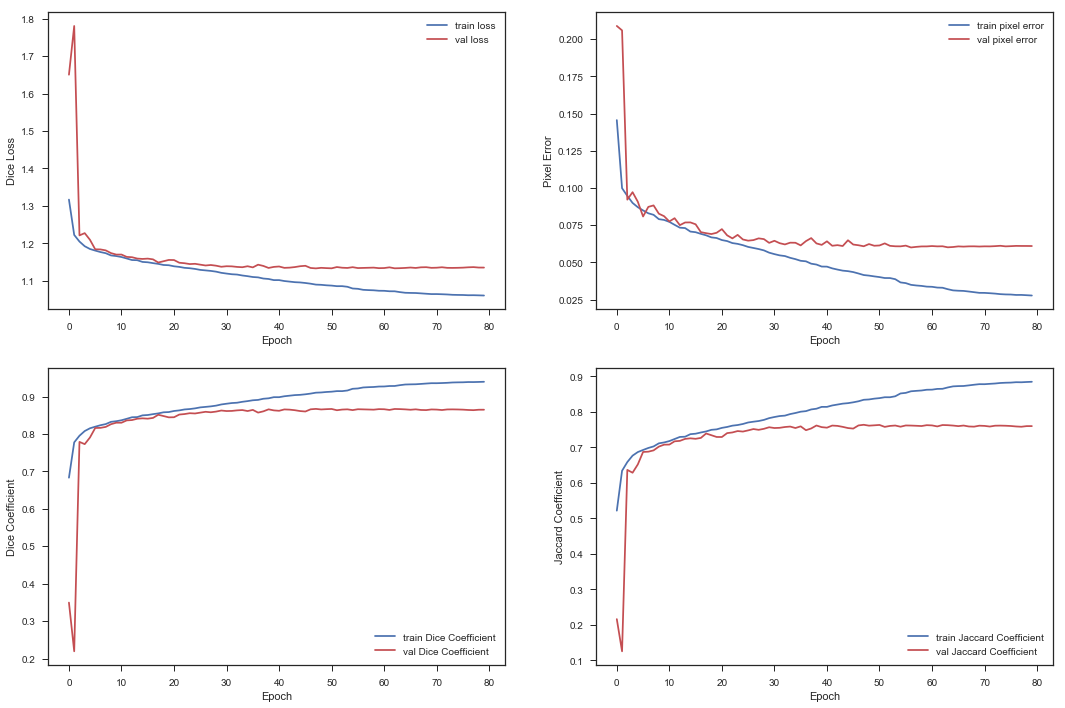

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['ofuse_loss']], 'b-', label='train loss')
ax[0, 0].plot(results.epoch, [x + 1 for x in results.history['val_ofuse_loss']], 'r-', label='val loss')
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Dice Loss')
ax[0, 1].plot(results.epoch, results.history['ofuse_pixel_error'], 'b-', label='train pixel error')
ax[0, 1].plot(results.epoch, results.history['val_ofuse_pixel_error'], 'r-', label='val pixel error')
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Pixel Error')
ax[1, 0].plot(results.epoch, results.history['ofuse_dice_coef'], 'b-', label='train Dice Coefficient')
ax[1, 0].plot(results.epoch, results.history['val_ofuse_dice_coef'], 'r-', label='val Dice Coefficient')
ax[1, 0].legend(loc='lower right')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Dice Coefficient')
ax[1, 1].plot(results.epoch, results.history['ofuse_jaccard_coef'], 'b-', label='train Jaccard Coefficient')
ax[1, 1].plot(results.epoch, results.history['val_ofuse_jaccard_coef'], 'r-', label='val Jaccard Coefficient')
ax[1, 1].legend(loc='lower right')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Jaccard Coefficient')
plt.show()

In [17]:
np.save(RESULT_PATH + 'history_Unet_fuse_v7_2.npy', results.history)

model_unet_fuse_v7_2.save_weights(WEIGHT_PATH + 'UNET_fuse_v7_2_weight.h5')
model_unet_fuse_v7_2.save(MODEL_PATH + 'UNET_fuse_v7_2_model.h5')
model_json = model_unet_fuse_v7_2.to_json()
with open(MODEL_PATH + 'UNET_fuse_v7_2_model.json', "w") as json_file:
    json_file.write(model_json)
    
model_unet_fuse_v7_2= u_net_fuse_v7_2(input_shape=(512, 512, 1))
model_unet_fuse_v7_2.load_weights(WEIGHT_PATH + 'UNET_fuse_v7_2_weight.h5')

y_pred = model_unet_fuse_v7_2.predict(X_test, batch_size=5)
result_fuse = (1 - y_pred[-1]).astype(np.float32)
result_fuse.shape

(30, 512, 512, 1)

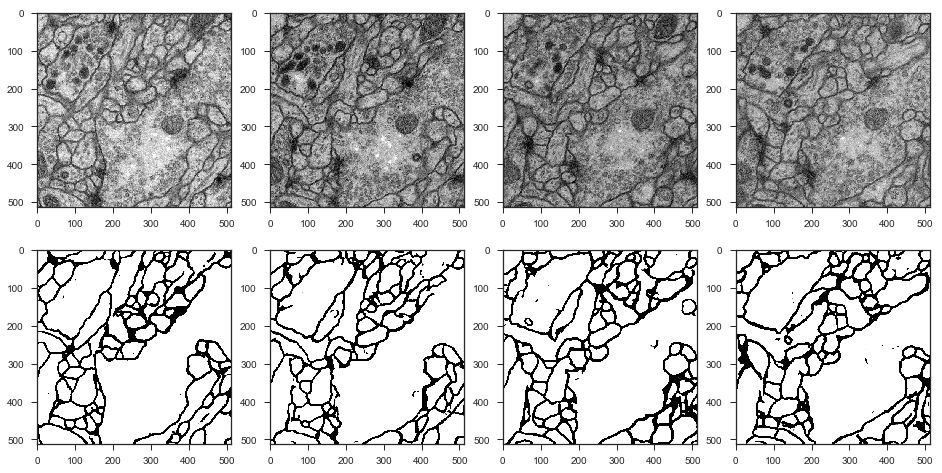

In [18]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v7_2_' + timestamp + '.tif', result_fuse, dtype=np.float32)
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v7_2_' + timestamp + '.tif')

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='gray')

plt.show()